# Init conditions for WLC

In this script we calculate $F(R/N)$ and draw equilibrium samples for the WLC.  

After specifying parameters number of beads $N$, WLC inter-bead stiffness $k$, Lennard-Jones parameters $\sigma_{LJ}, \epsilon_{LJ}$, and external radial spring constant $k_\mathrm{ext}$; as well as the center of radial wells $\lambda_i$ and $\lambda_f$ (for $U_A$ and $U_B$ respectively), this script 

(1) conducts a Metropolis-adjusted langevin algorithm (MALA) simulation under $U_\phi(\vec{\phi})$ (we do this instead of using $U = U_\phi + U_\mathrm{LJ}$, because the latter has much lower mixing rate / higher correlation time); and

(2) collects equilibrium samples for $U_A = U_\phi + U_\mathrm{LJ} + U_{\mathrm{ext},A}$ and $U_B = U_\phi + U_\mathrm{LJ} + U_{\mathrm{ext},B}$ by accepting each sample with probability 

\begin{equation}
  P_\mathrm{acc} = \exp \bigg[ - \bigg( U_\mathrm{LJ}(\vec{\phi}) + \frac{(R(\vec{\phi}) - \lambda_{i,j})^2}{2} \bigg) \bigg].
\end{equation}


As a bonus, by keeping track of all samples, we can plot $F(R/N)$, giving the ground truth against which we can validate the $\Delta F$-estimator algorithm. 


In [1]:
# standard packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt

# for just-in-time compilation and parallelization, to speed up code execution
from numba import jit


from scipy.special import iv, ive
from scipy.optimize import minimize

In [2]:
# parameters for WLC are: number of beads, interbead spring constant, 
#                          (for first-last bead LJ interaction) sigma_LJ, epsilon_LJ, 
#                           pulling spring constant
n_beads, k, sig_LJ, eps_LJ, k_ext = 15, 6.0, 4.0, 8.0, 100.0
problemtype, problemparams = "WLC", (n_beads, k, sig_LJ, eps_LJ, k_ext)
lambda_i, lambda_f = sig_LJ*(2**(1./6)), 0.9*n_beads



# Energy and dynamics

Here we specify $U_\mathrm{LJ}(\vec{\phi})$ and $U_\phi(\vec{\phi})$, as well as their gradients.

As a reminder, we have 

\begin{equation}
  \vec{\phi} \in [0, 2\pi)^{N},
\end{equation}

with $(x_n(\vec{\phi}), y_n(\vec{\phi})) = (\sum_{m = 1}^n \cos \phi_m, \sum_{m = 1}^n \sin \phi_m)$ the coordinates of the $n$-th bead, and end-to-end distance $R(\vec{\phi}) = \sqrt{x_N(\vec{\phi})^2 + y_N(\vec{\phi})^2}$, the potentials 

\begin{equation}
  U_\phi(\vec{\phi}) = k \sum_{n=1}^{N - 1} [1 - \cos (\phi_{n+1} - \phi_n)]
\end{equation}

and

\begin{equation}
  U_\mathrm{LJ}(\vec{\phi}) = 4 \epsilon_\mathrm{LJ} \bigg[ \bigg(\frac{\sigma_\mathrm{LJ}}{R(\vec{\phi})}\bigg)^{12} - \bigg(\frac{\sigma_\mathrm{LJ}}{R(\vec{\phi})}\bigg)^{6} \bigg].
\end{equation}



In [3]:
@jit(nopython=True)
def U_LJ(x):
    x_N, y_N = np.sum(np.cos(x)), np.sum(np.sin(x))
    R2 = x_N**2 + y_N**2
    U_eval = 4*eps_LJ*(sig_LJ**12 / R2**6 - sig_LJ**6 / R2**3)
    return U_eval

@jit(nopython=True)
def U_phi(x):
    return k*np.sum(1 - np.cos(x[1:] - x[:-1]))


# gradients, in principle obtainable through automatic differentiation
@jit(nopython=True)
def gradU_LJ(x):
    x_N, y_N = np.sum(np.cos(x)), np.sum(np.sin(x))
    R2 = x_N**2 + y_N**2
    gradU_eval = 4*eps_LJ*(-6*sig_LJ**12 / R2**7 + 3*sig_LJ**6 / R2**4)*(2*x_N*(-np.sin(x)) + 2*y_N*np.cos(x))
    return gradU_eval

@jit(nopython=True)
def gradU_phi(x):
    gradU_eval = np.zeros(len(x))
    gradU_eval[1:]  += k*np.sin(x[1:] - x[:-1])
    gradU_eval[:-1] += k*np.sin(x[:-1] - x[1:])
    return gradU_eval


# Visualization script

Here is a script that helps visualize polymers.

plotting a random polymer under U_phi (linearized approximation)


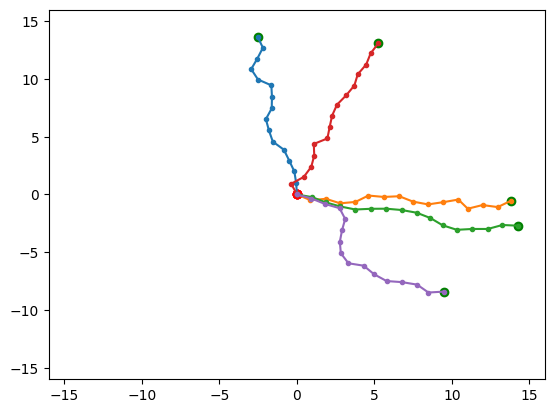

In [4]:
def plot_polymer(x, t = 0):
    "makes a 2d plot!"
    r_x, r_y = np.zeros(n_beads + 1), np.zeros(n_beads+1)
    r_x[1:] = np.cumsum(np.cos(x))
    r_y[1:] = np.cumsum(np.sin(x))

    if t == 0:
        plt.plot(r_x, r_y, '.-')
    else:
        plt.plot(r_x, r_y, '.-', label = "time = " + str(t), ms = 10, alpha = .5)
    
    plt.scatter(0,0,color='red')
    plt.scatter(r_x[-1],r_y[-1],color='green')

    plt.xlim([-len(r_x), len(r_x)])
    plt.ylim([-len(r_x), len(r_y)])


print("plotting a random polymer under U_phi (linearized approximation)")

for _ in range(5):
    x_random = (1/np.sqrt(k))*np.random.randn(n_beads) + np.random.uniform(0, 2*np.pi) # + (1/np.sqrt(k))*np.random.randn(n_beads)
    plot_polymer(x_random)


initial condition:


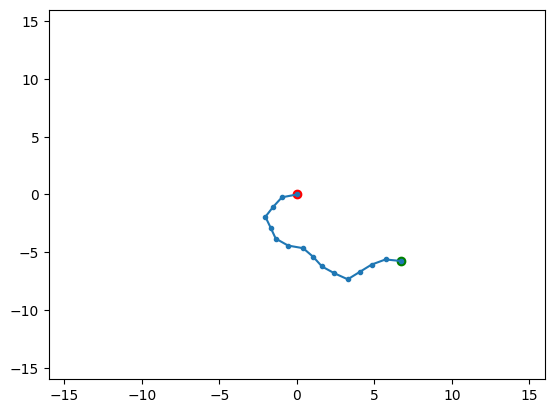

In [5]:
@jit(nopython = True)
def MALA(x0, dt, N_steps, verbose = True):
    "metropolis-adjusted algorithm for just U_phi"
    if verbose: 
        print("total time", dt*N_steps)
    
    n = 0
    n_rejection = 0
    
    x = x0.copy()
    
    R2s = np.zeros(N_steps)
    
    gradU_eval = gradU_phi(x) # + gradU_LJ(x)
    while n < N_steps:
        dB = np.sqrt(dt)*np.random.randn(len(x))
        dx_p = -gradU_eval*dt + np.sqrt(2)*dB # p for proposal
        x_p = x + dx_p
        gradU_eval_p = gradU_phi(x_p)  # + gradU_LJ(x_p) 
        
        alpha = min(1, np.exp(-(# U_LJ(x_p) + 
                                U_phi(x_p) + np.sum((dx_p - dt*gradU_eval_p)**2) / (4.*dt))
                              +(# U_LJ(x) + 
                                U_phi(x) + np.sum((dx_p + dt*gradU_eval)**2) / (4.*dt))))
                                        
        if alpha > np.random.random():
            R2s[n] = (np.sum(np.cos(x))**2 + np.sum(np.sin(x))**2)
            
            # accept!
            x = x_p.copy()
            gradU_eval = gradU_eval_p
            n += 1
            
            if n % (N_steps // 20) == 0 and verbose:
                print("done with", n // (N_steps // 20), "of 20, rejection rate", n_rejection / (n + n_rejection))
                # print(f"done with {n // (N_steps // 100)} of 100, rejection rate: {n_rejection / (n + n_rejection)}")                
        else:
            n_rejection += 1
            if n_rejection % (N_steps // 100) == 0 and verbose:
                print("we have", n_rejection, "rejections")
                # print(alpha)
            continue
            
    return x
                 
    
x0 = (1/np.sqrt(k))*np.random.randn(n_beads) + np.random.uniform(0, 2*np.pi)

# start algorithm, generate initial condition
x = MALA(x0, 5e-2, 10000, verbose = False) 

print("initial condition:") 
plot_polymer(x)


These are the acceptance weighting functions for x0_A, x0_B


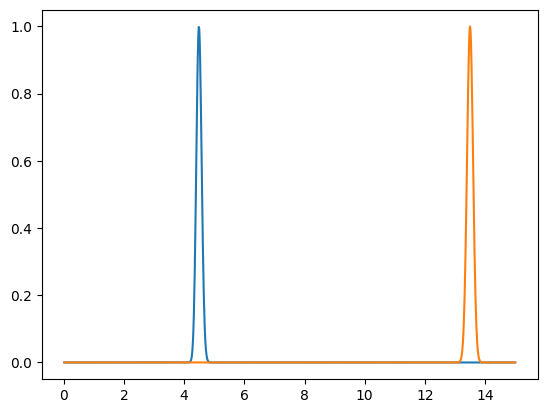

In [6]:
@jit(nopython=True)
def rho_A_weighting(R):
    return (4*eps_LJ*(sig_LJ**12 / R**12 - sig_LJ**6 / R**6)) + k_ext*(R - lambda_i)**2/2

@jit(nopython=True)
def rho_B_weighting(R):
    return (4*eps_LJ*(sig_LJ**12 / R**12 - sig_LJ**6 / R**6)) + k_ext*(R - lambda_f)**2/2

rho_A_weighting_offset = minimize(rho_A_weighting, 1.0).fun
rho_B_weighting_offset = minimize(rho_B_weighting, 1.0).fun


Rs_plot = np.linspace(0, n_beads, 1001)

print("These are the acceptance weighting functions for x0_A, x0_B")
plt.plot(Rs_plot, np.exp(-(rho_A_weighting(Rs_plot) - rho_A_weighting_offset)))
plt.plot(Rs_plot, np.exp(-(rho_B_weighting(Rs_plot) - rho_B_weighting_offset)))

plt.show()

starting sample collection, until we have 1000 samples for U_A and U_B. continually saves to array
total number of samples 5000
samples for U_A 4
samples for U_B 374


/var/folders/wd/8xh1mkm92tg7nmjt067vzplm0000gn/T/ipykernel_16089/391740176.py:58: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins[1:], -np.log(ns) - min(-np.log(ns)))


dF = F_B - F_A estimate from reweighting: [3.5364668648414277]


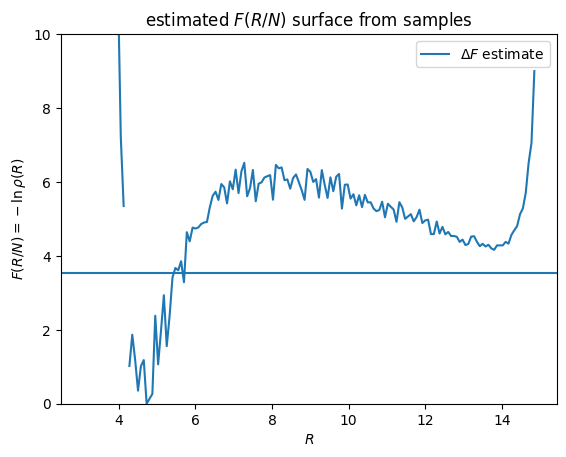

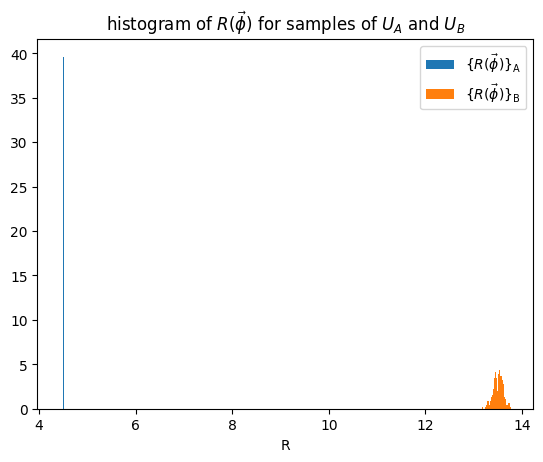

total number of samples 10000
samples for U_A 14
samples for U_B 723
dF = F_B - F_A estimate from reweighting: [4.055911361388546]


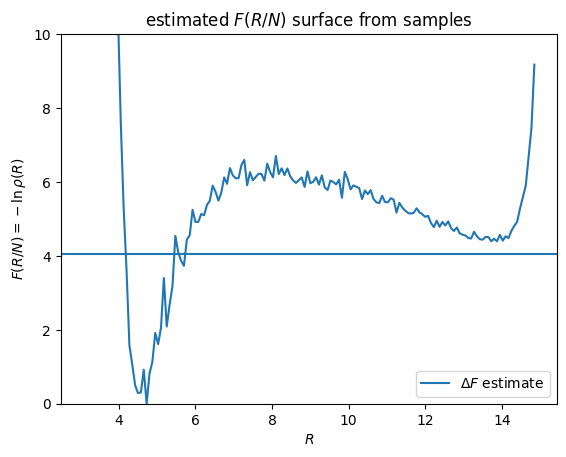

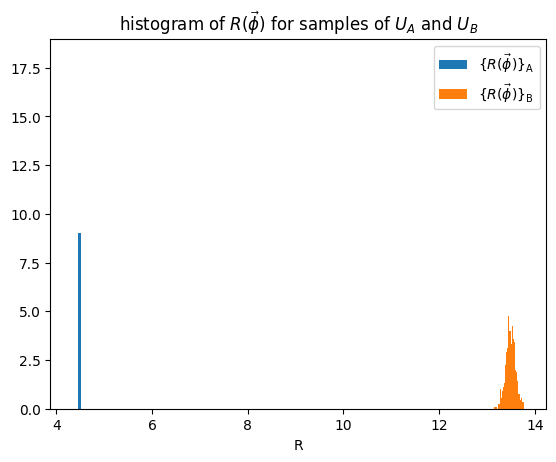

total number of samples 15000
samples for U_A 25
samples for U_B 1126
dF = F_B - F_A estimate from reweighting: [4.088592127513545]


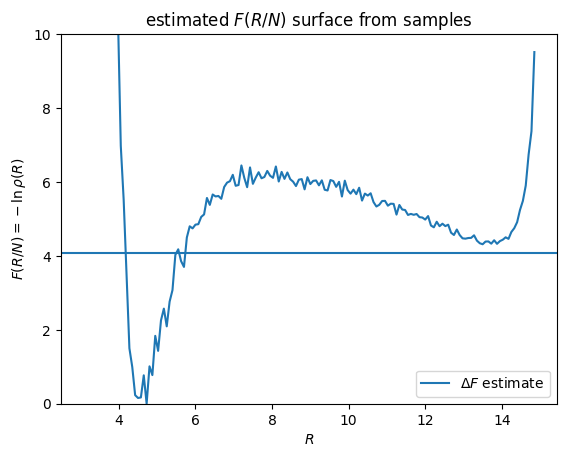

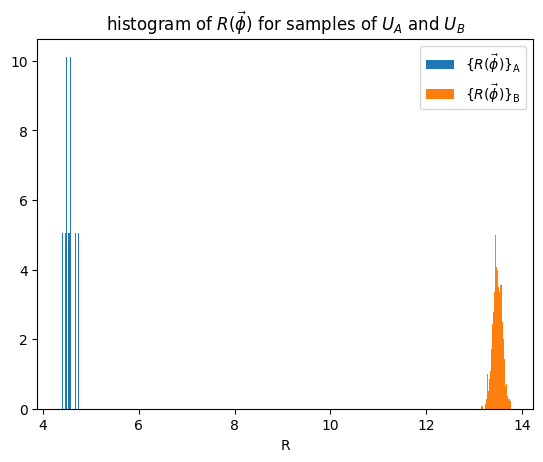

total number of samples 20000
samples for U_A 33
samples for U_B 1504
dF = F_B - F_A estimate from reweighting: [4.12267832076029]


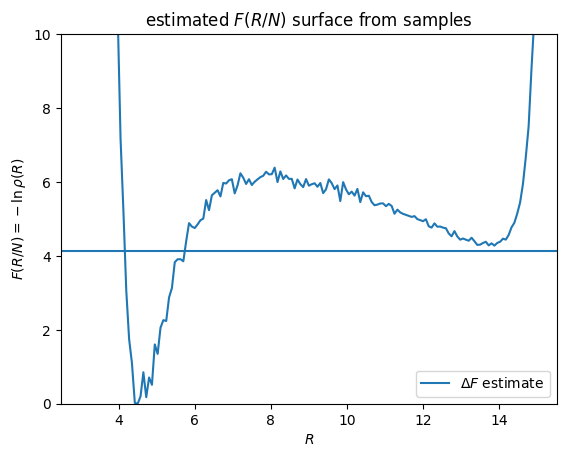

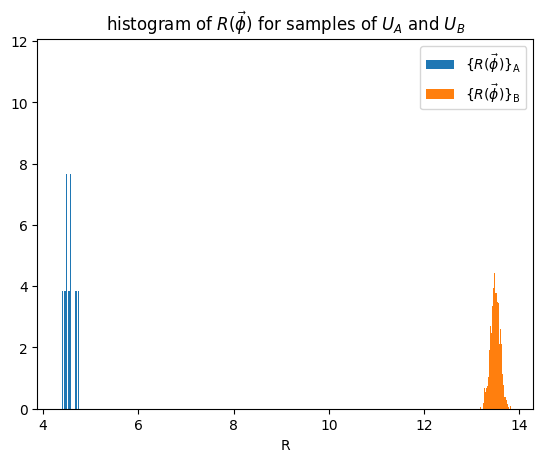

total number of samples 25000
samples for U_A 38
samples for U_B 1899
dF = F_B - F_A estimate from reweighting: [4.021101191367897]


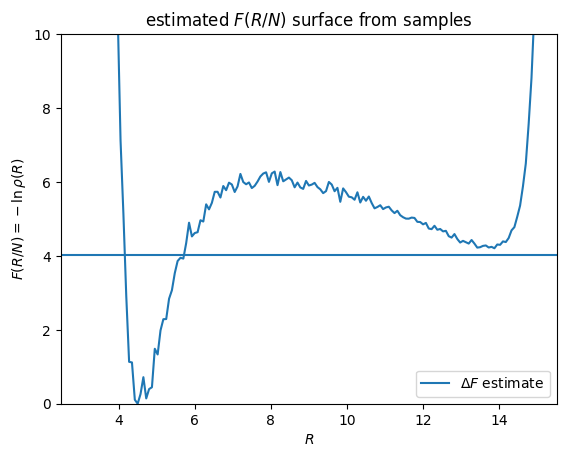

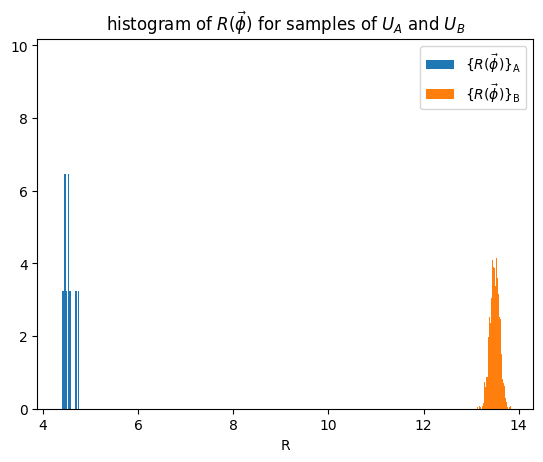

total number of samples 30000
samples for U_A 45
samples for U_B 2279
dF = F_B - F_A estimate from reweighting: [4.023009037887035]


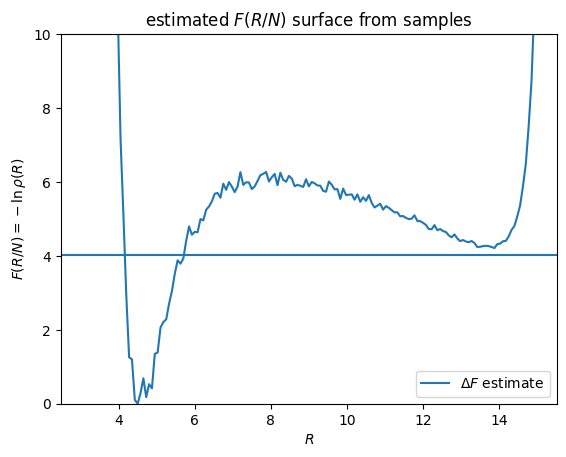

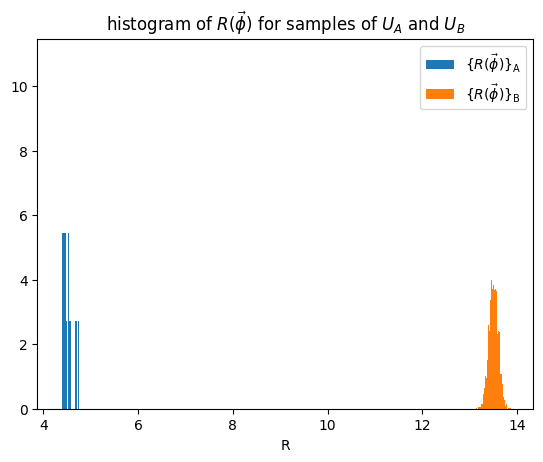

total number of samples 35000
samples for U_A 51
samples for U_B 2661
dF = F_B - F_A estimate from reweighting: [4.018480864015181]


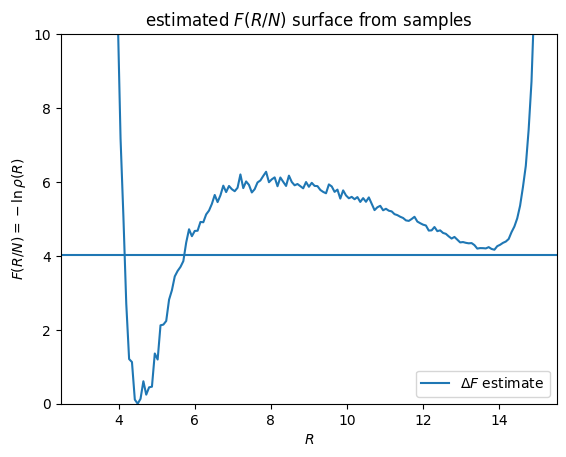

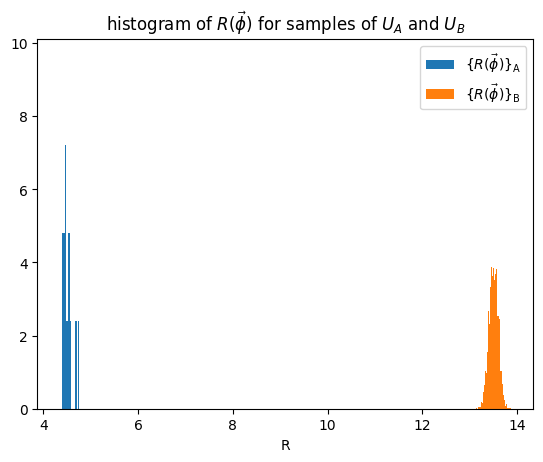

total number of samples 40000
samples for U_A 58
samples for U_B 3044
dF = F_B - F_A estimate from reweighting: [4.020479403346853]


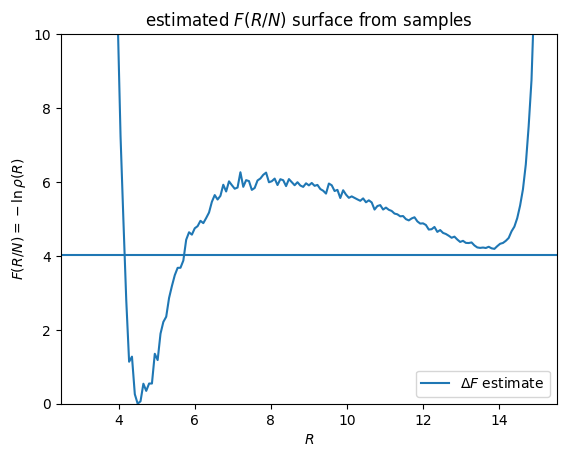

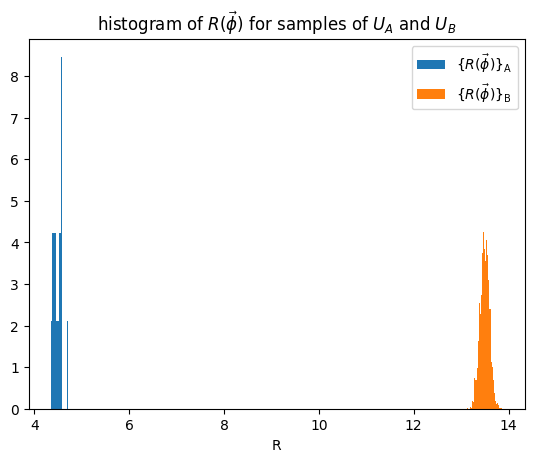

total number of samples 45000
samples for U_A 67
samples for U_B 3409
dF = F_B - F_A estimate from reweighting: [4.057204765330427]


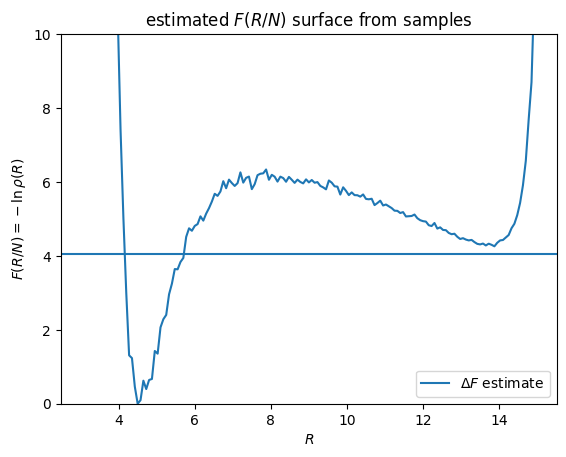

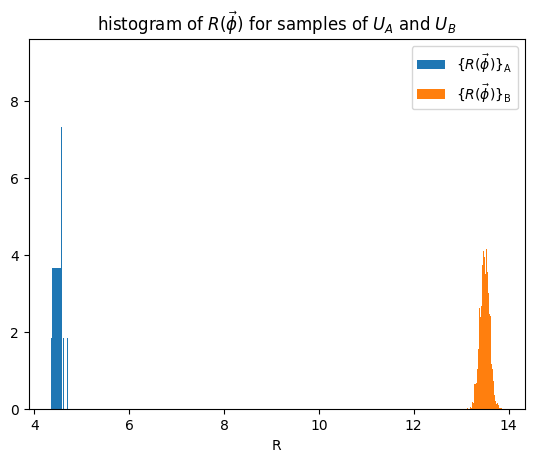

total number of samples 50000
samples for U_A 77
samples for U_B 3816
dF = F_B - F_A estimate from reweighting: [4.064137613515847]


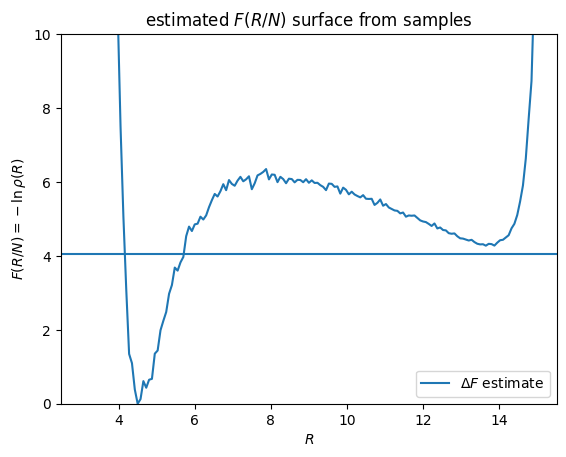

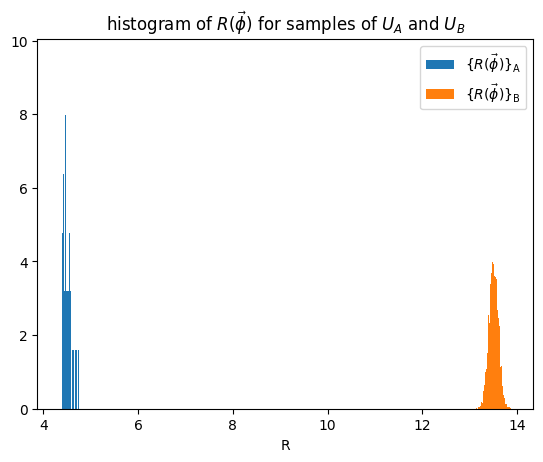

total number of samples 55000
samples for U_A 88
samples for U_B 4202
dF = F_B - F_A estimate from reweighting: [4.090916321322458]


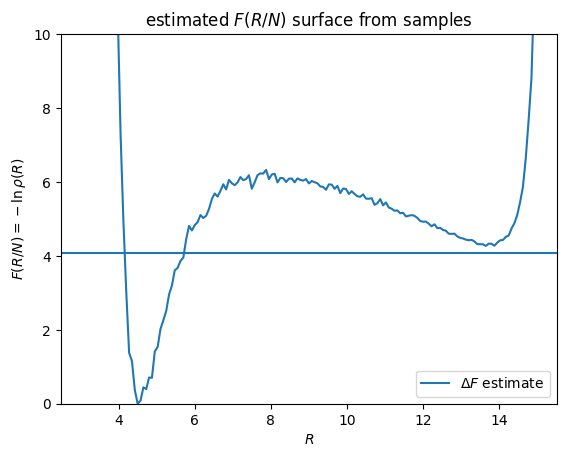

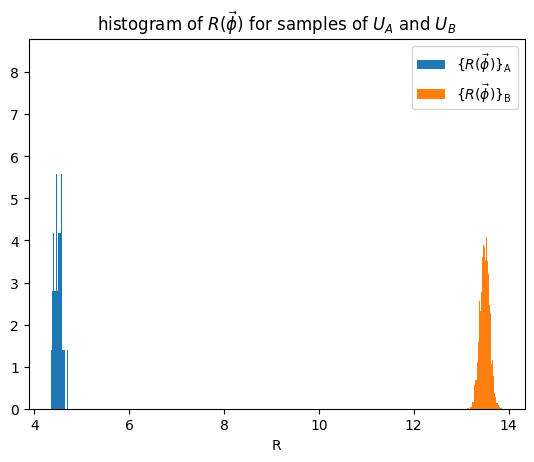

total number of samples 60000
samples for U_A 94
samples for U_B 4610
dF = F_B - F_A estimate from reweighting: [4.077545951243907]


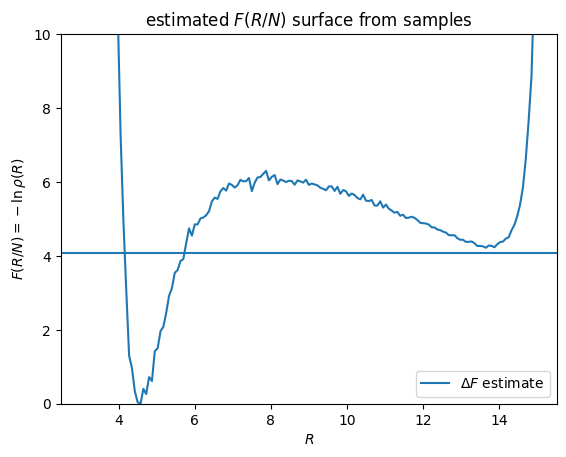

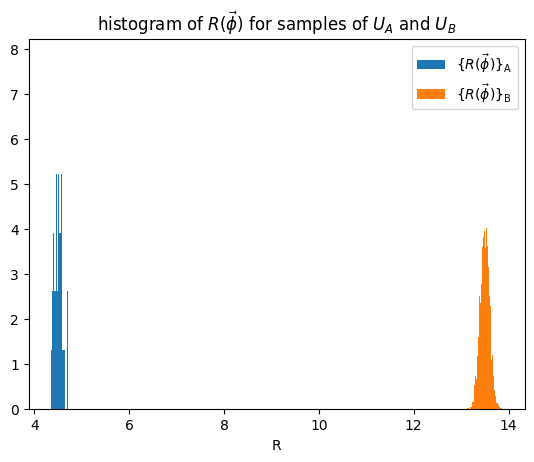

total number of samples 65000
samples for U_A 101
samples for U_B 4959
dF = F_B - F_A estimate from reweighting: [4.096720203402636]


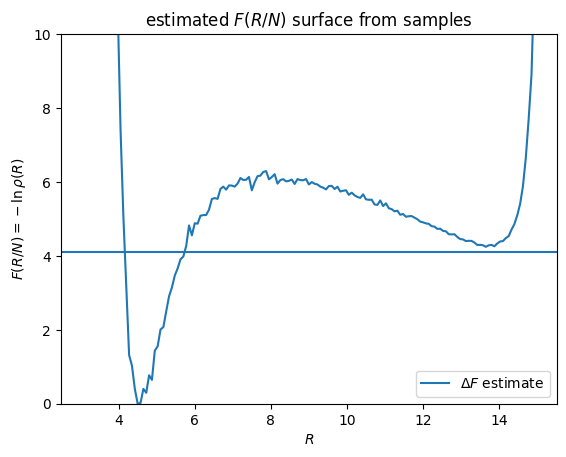

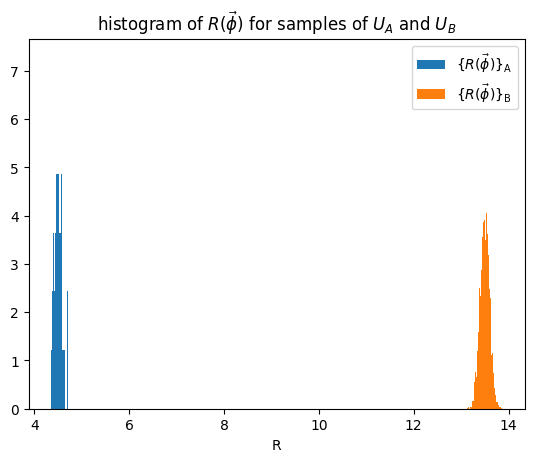

total number of samples 70000
samples for U_A 106
samples for U_B 5354
dF = F_B - F_A estimate from reweighting: [4.071569398148126]


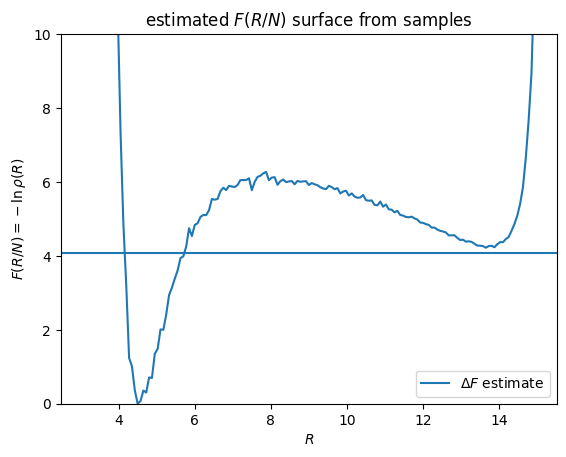

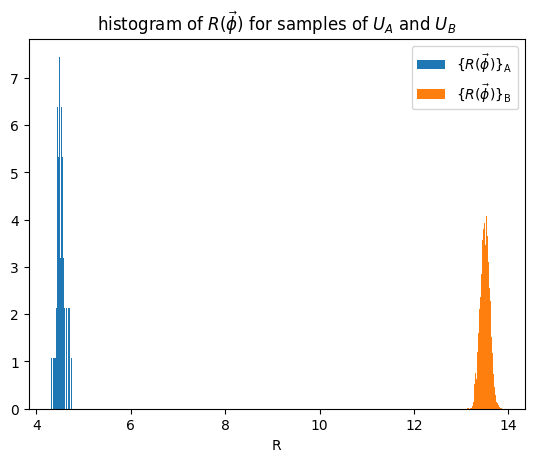

total number of samples 75000
samples for U_A 117
samples for U_B 5748
dF = F_B - F_A estimate from reweighting: [4.112373834736452]


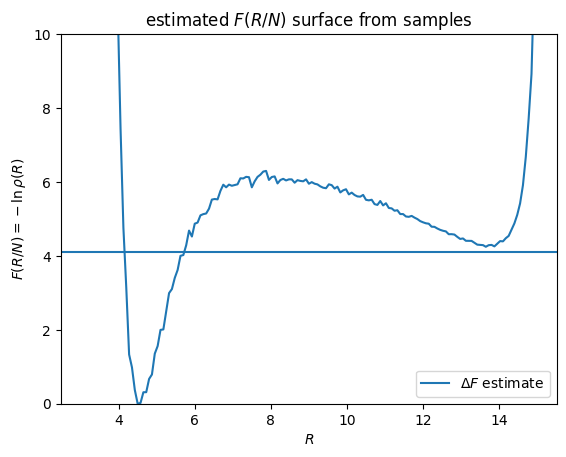

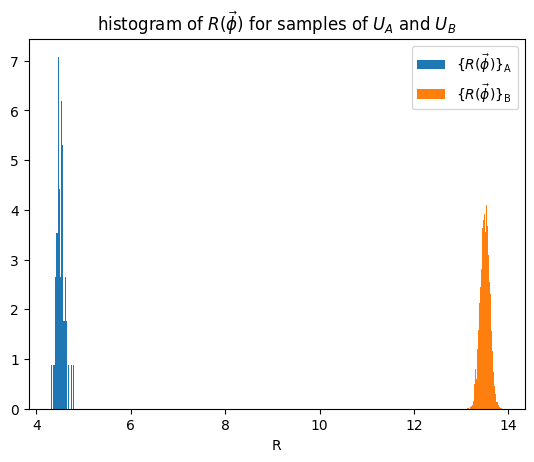

total number of samples 80000
samples for U_A 124
samples for U_B 6107
dF = F_B - F_A estimate from reweighting: [4.11583602630742]


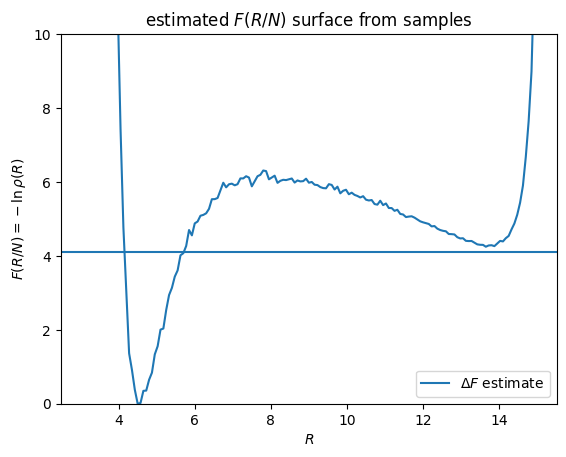

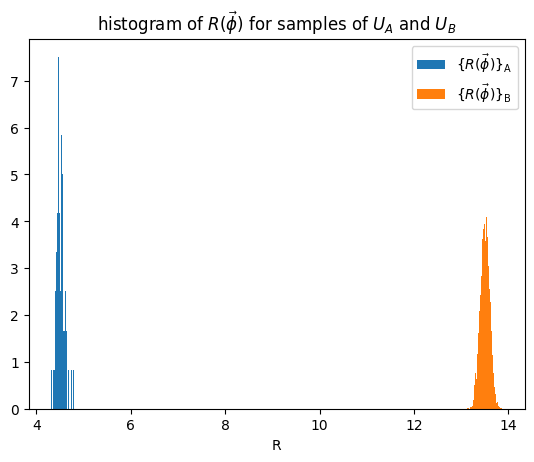

total number of samples 85000
samples for U_A 131
samples for U_B 6502
dF = F_B - F_A estimate from reweighting: [4.103544119994337]


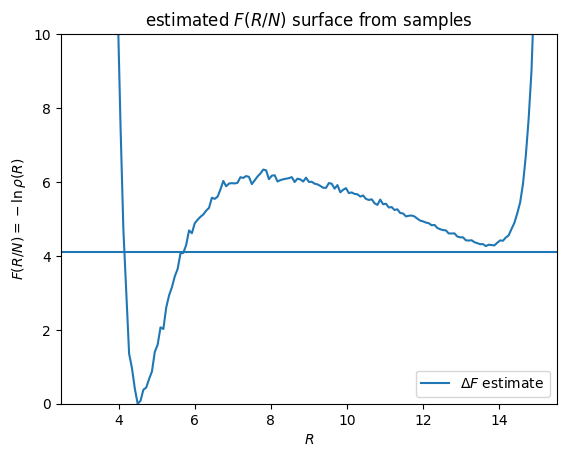

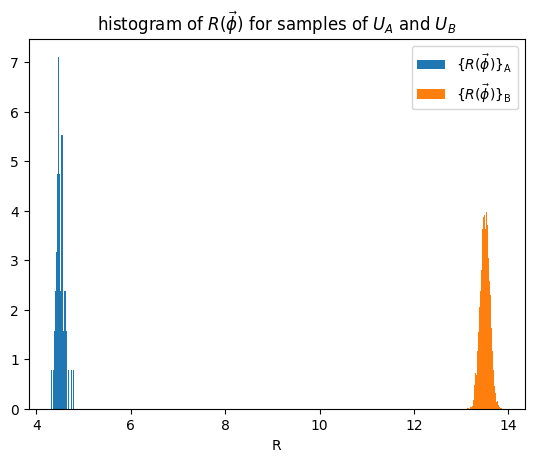

total number of samples 90000
samples for U_A 143
samples for U_B 6875
dF = F_B - F_A estimate from reweighting: [4.125686390831072]


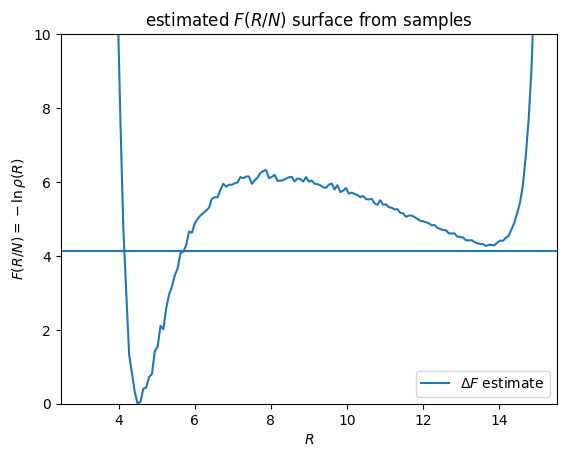

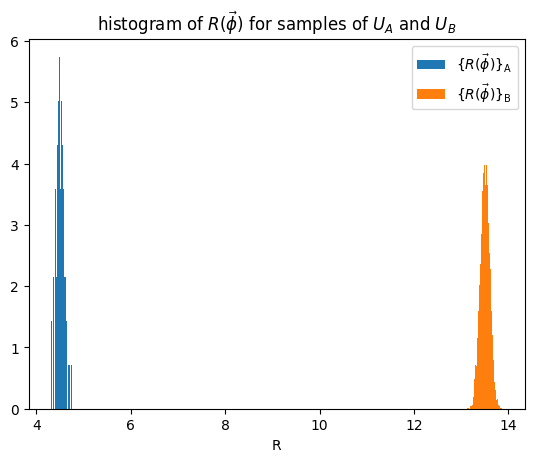

total number of samples 95000
samples for U_A 151
samples for U_B 7254
dF = F_B - F_A estimate from reweighting: [4.137696924721308]


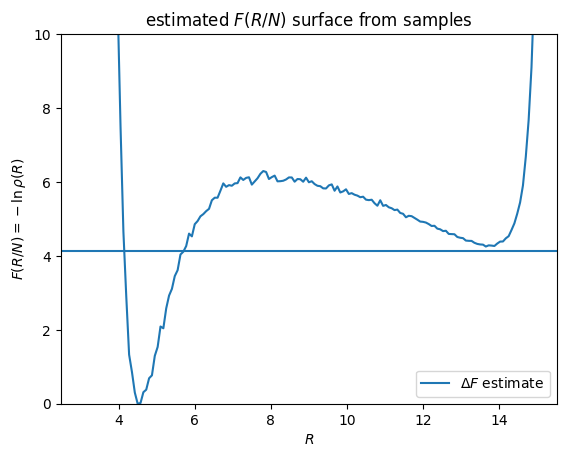

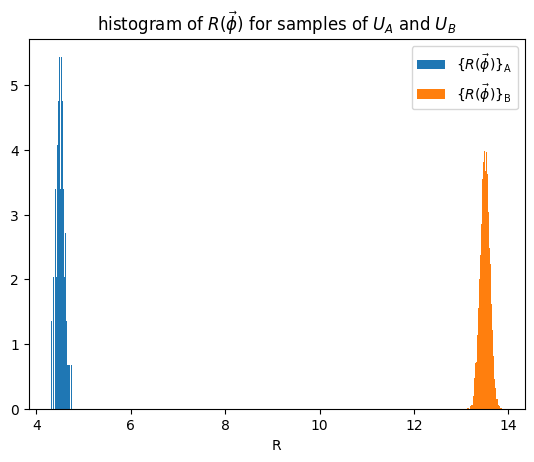

total number of samples 100000
samples for U_A 156
samples for U_B 7632
dF = F_B - F_A estimate from reweighting: [4.112580541164002]


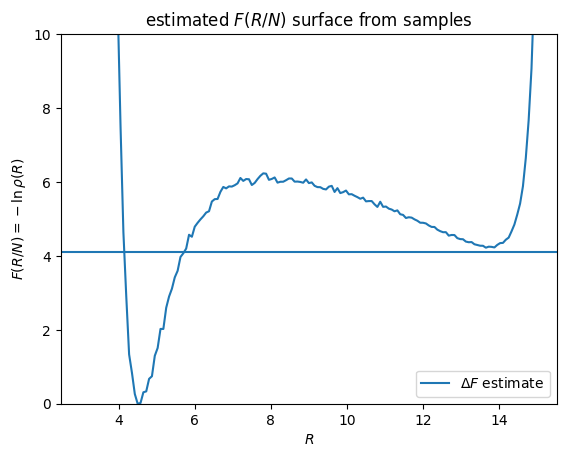

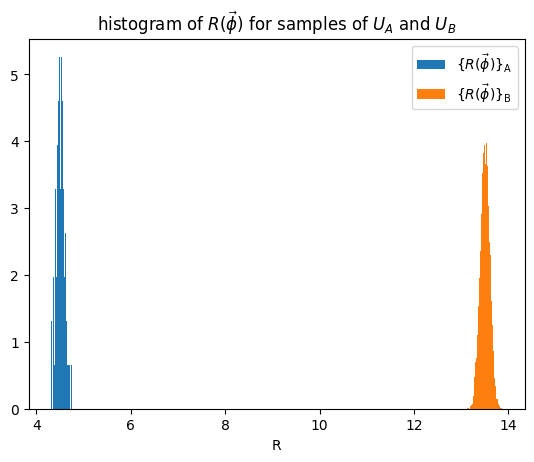

total number of samples 105000
samples for U_A 166
samples for U_B 7990
dF = F_B - F_A estimate from reweighting: [4.106305460623812]


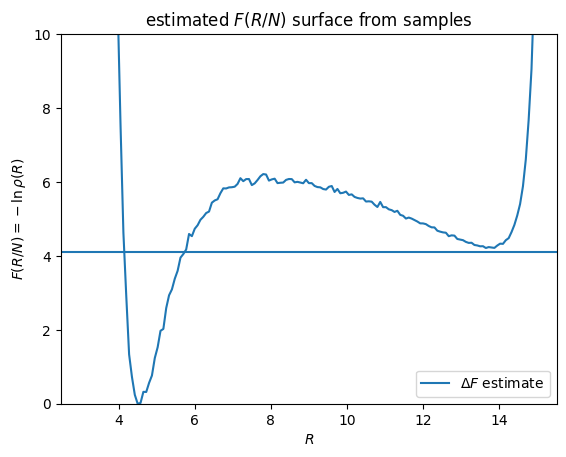

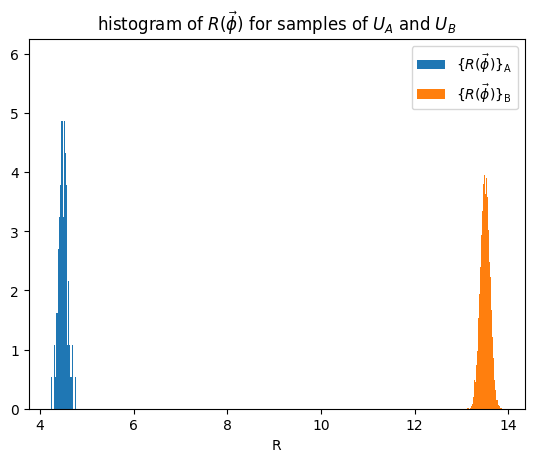

total number of samples 110000
samples for U_A 171
samples for U_B 8382
dF = F_B - F_A estimate from reweighting: [4.097074269374589]


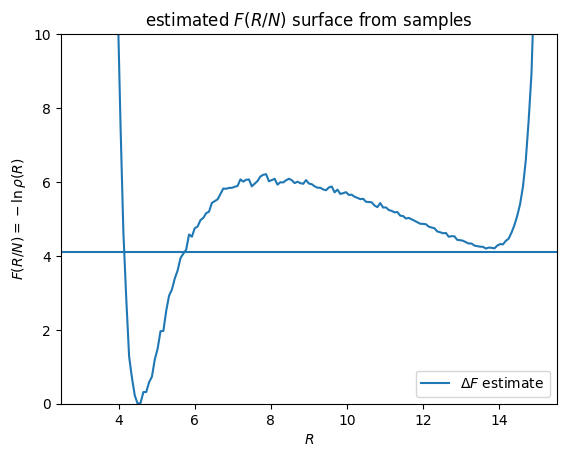

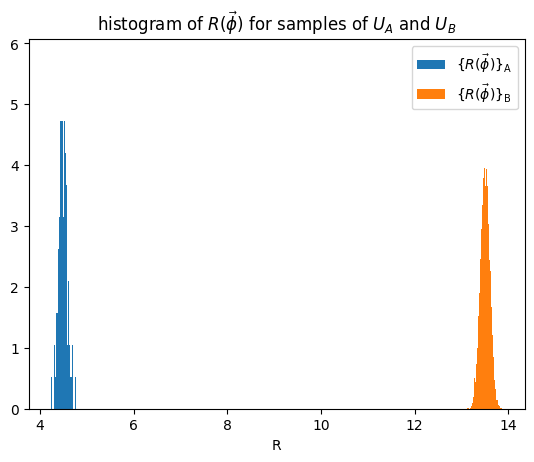

total number of samples 115000
samples for U_A 183
samples for U_B 8777
dF = F_B - F_A estimate from reweighting: [4.1208209799497215]


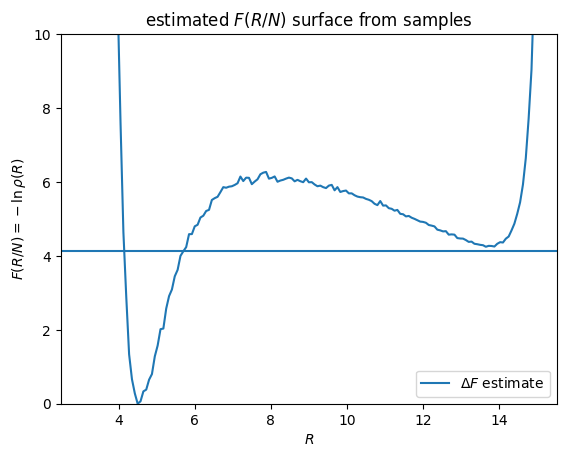

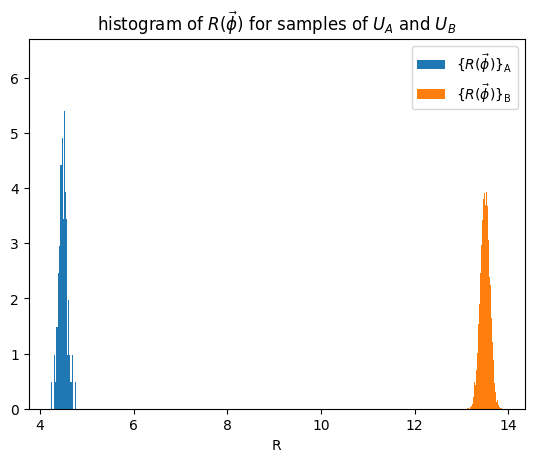

total number of samples 120000
samples for U_A 194
samples for U_B 9166
dF = F_B - F_A estimate from reweighting: [4.1269348655571925]


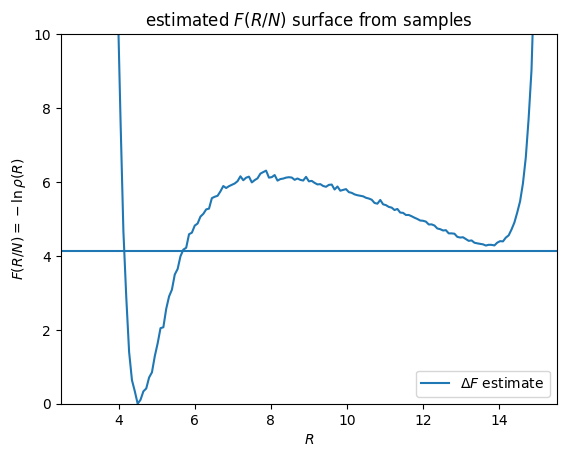

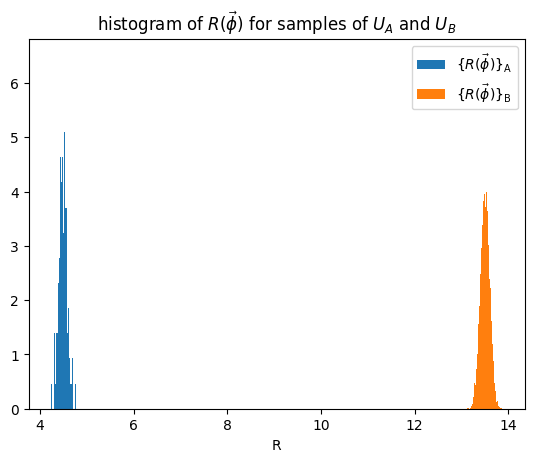

total number of samples 125000
samples for U_A 199
samples for U_B 9574
dF = F_B - F_A estimate from reweighting: [4.113673015860833]


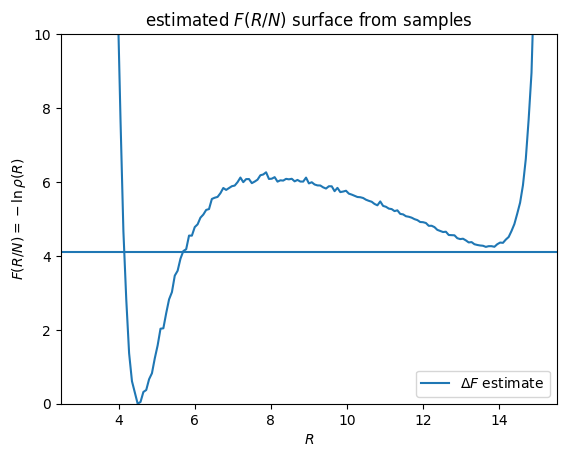

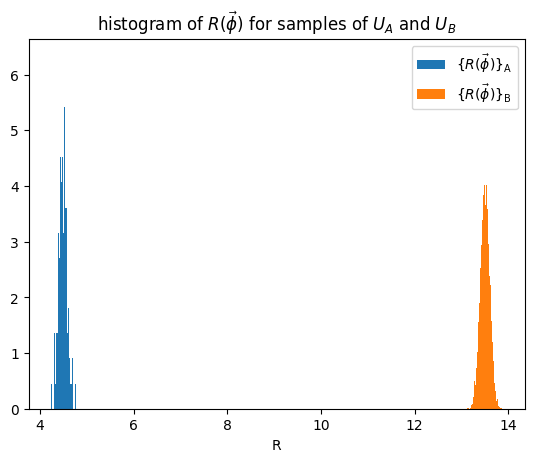

total number of samples 130000
samples for U_A 210
samples for U_B 9926
dF = F_B - F_A estimate from reweighting: [4.119864125521916]


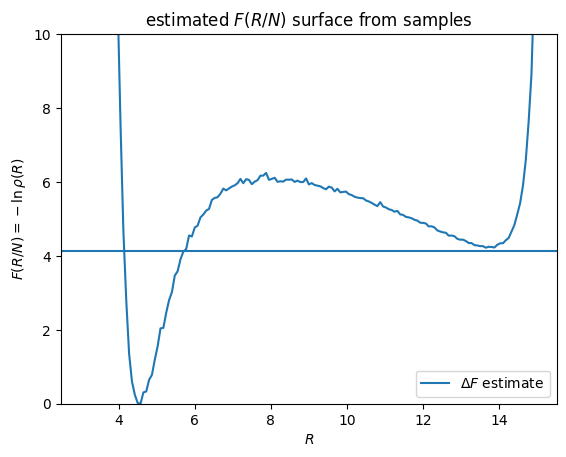

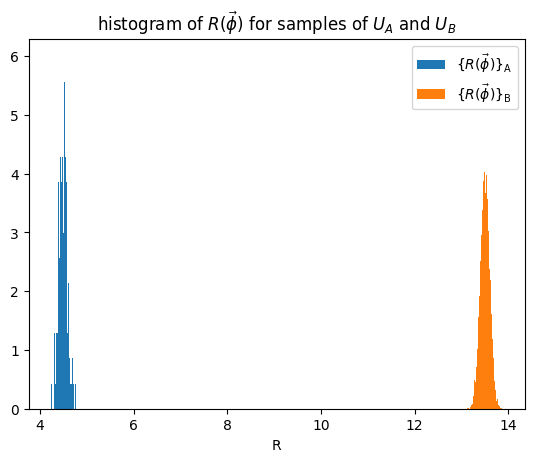

total number of samples 135000
samples for U_A 222
samples for U_B 10295
dF = F_B - F_A estimate from reweighting: [4.130421397863106]


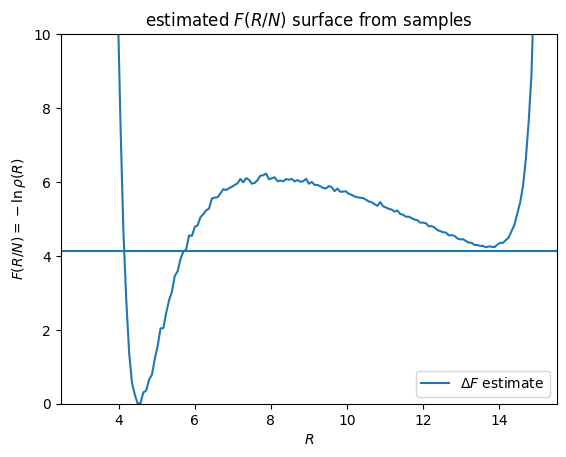

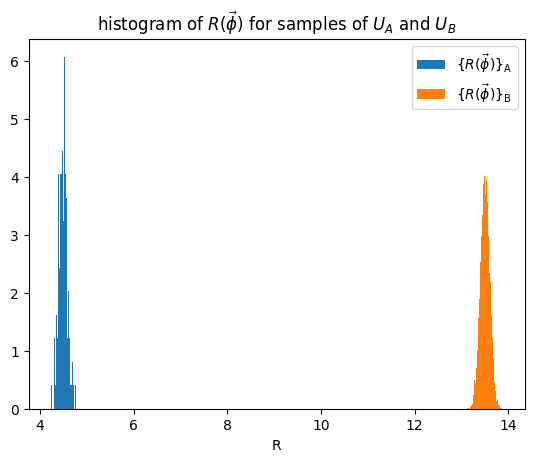

total number of samples 140000
samples for U_A 226
samples for U_B 10648
dF = F_B - F_A estimate from reweighting: [4.128624175380001]


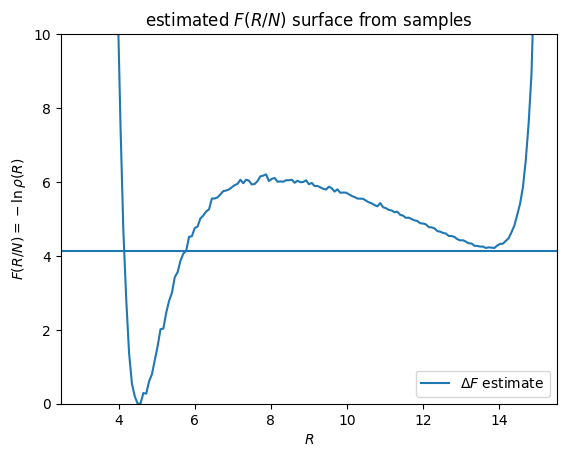

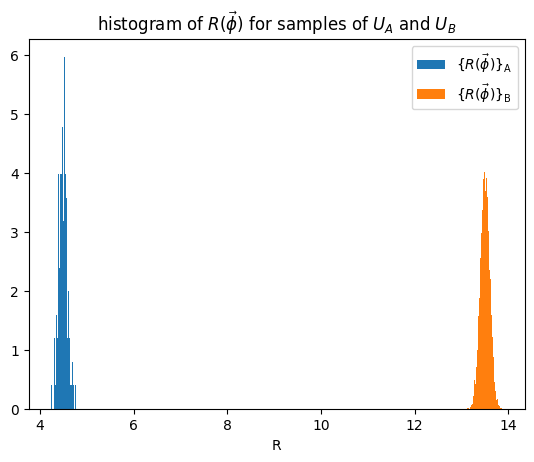

total number of samples 145000
samples for U_A 237
samples for U_B 10993
dF = F_B - F_A estimate from reweighting: [4.148831781658515]


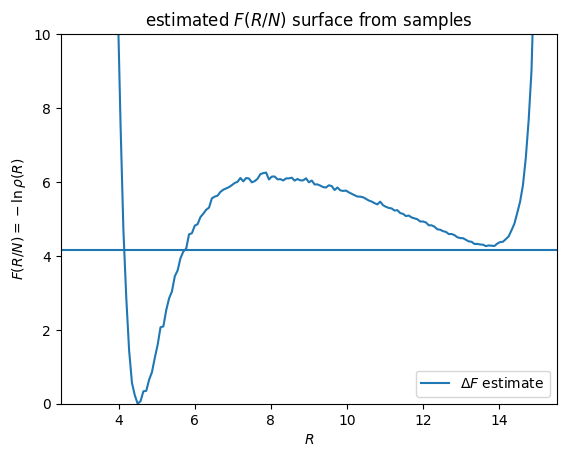

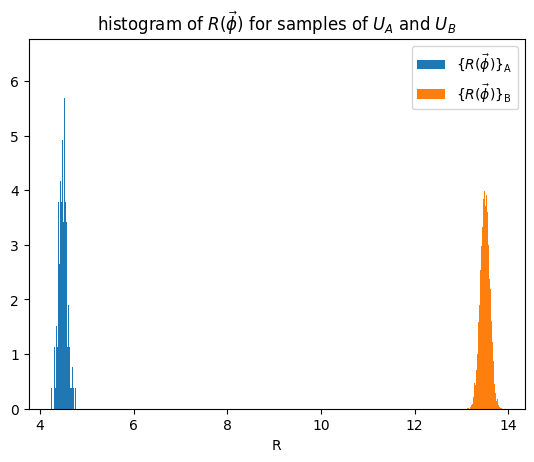

total number of samples 150000
samples for U_A 244
samples for U_B 11376
dF = F_B - F_A estimate from reweighting: [4.153817046785884]


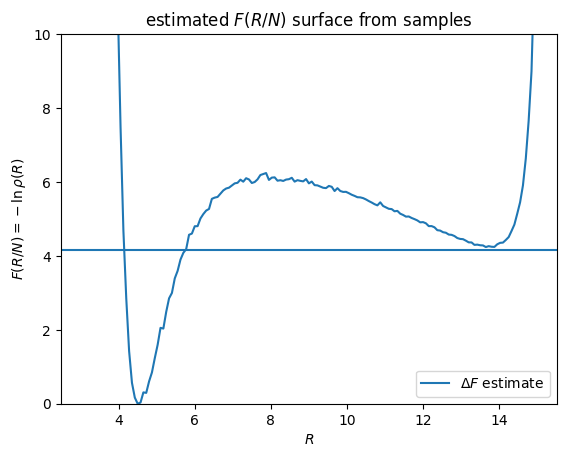

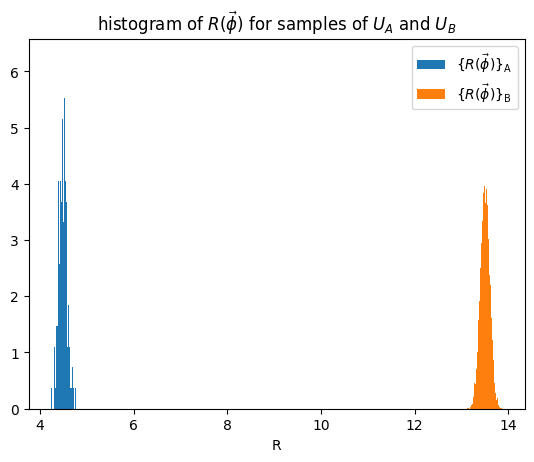

total number of samples 155000
samples for U_A 259
samples for U_B 11729
dF = F_B - F_A estimate from reweighting: [4.170431117644812]


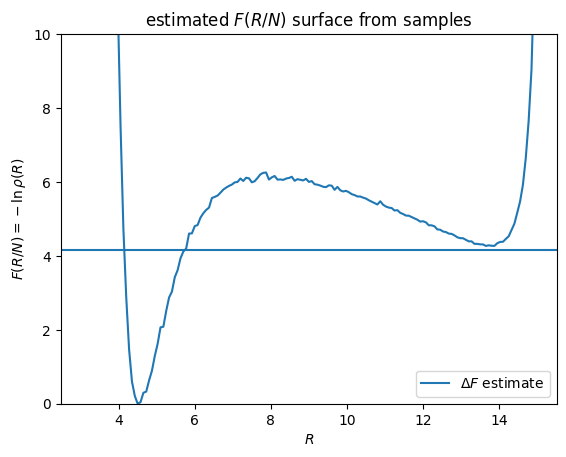

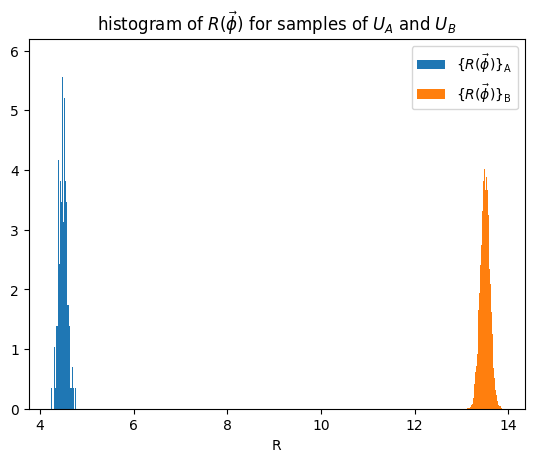

total number of samples 160000
samples for U_A 267
samples for U_B 12100
dF = F_B - F_A estimate from reweighting: [4.16933738527549]


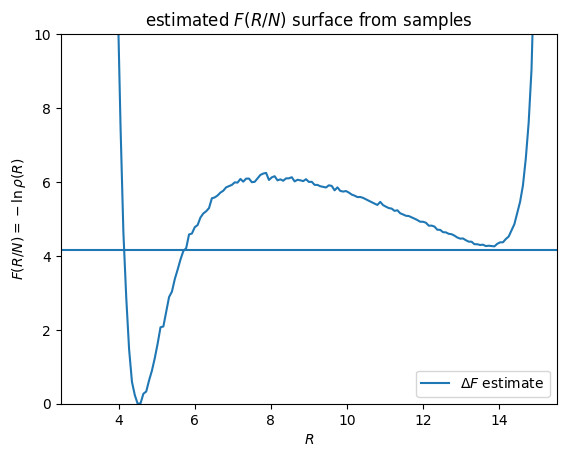

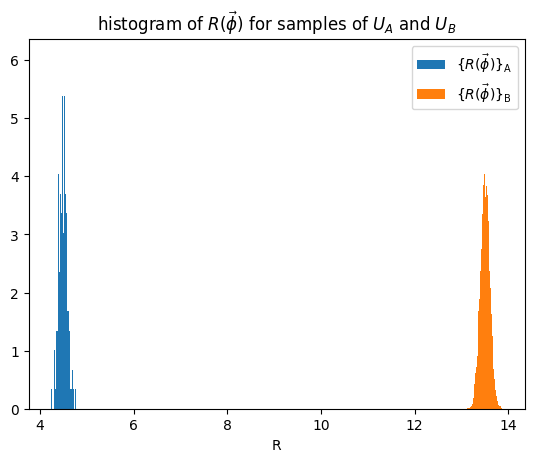

total number of samples 165000
samples for U_A 274
samples for U_B 12464
dF = F_B - F_A estimate from reweighting: [4.17080699402125]


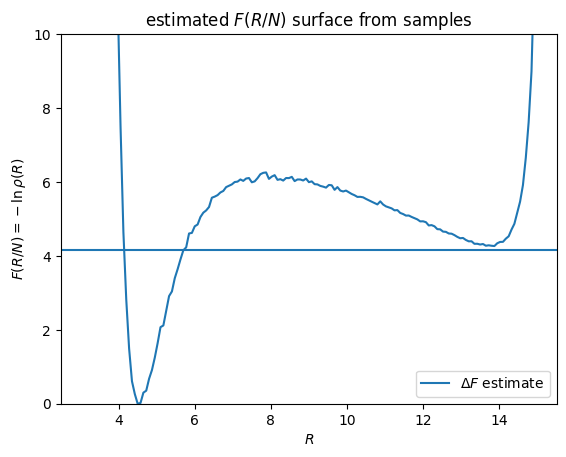

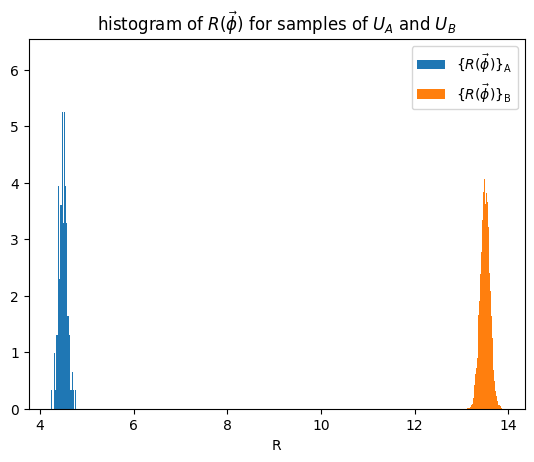

total number of samples 170000
samples for U_A 282
samples for U_B 12844
dF = F_B - F_A estimate from reweighting: [4.160700379340668]


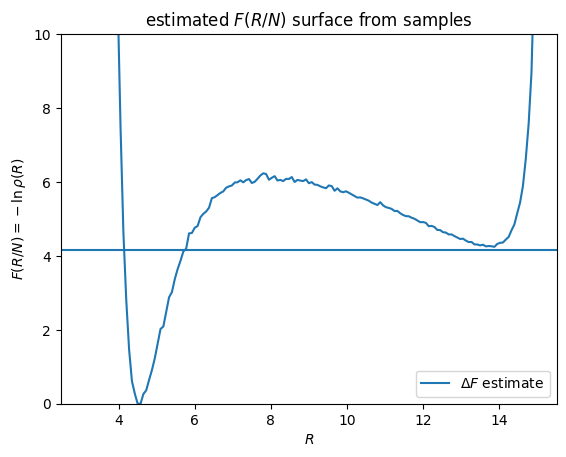

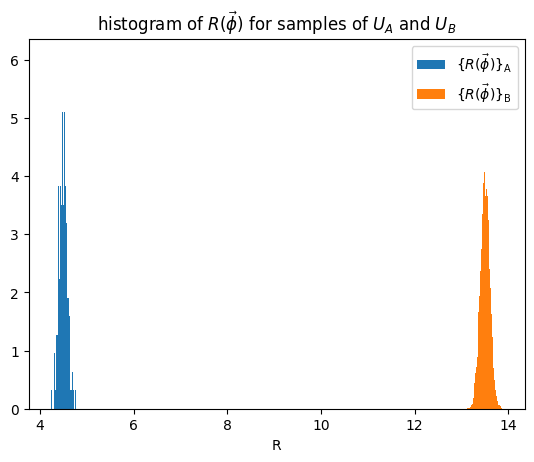

total number of samples 175000
samples for U_A 293
samples for U_B 13237
dF = F_B - F_A estimate from reweighting: [4.170847706217296]


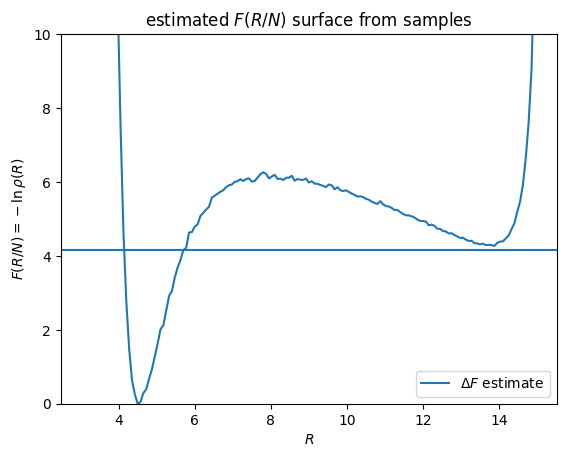

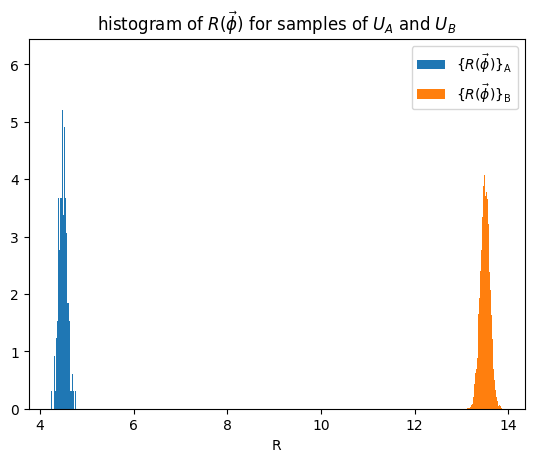

total number of samples 180000
samples for U_A 299
samples for U_B 13590
dF = F_B - F_A estimate from reweighting: [4.171895748066488]


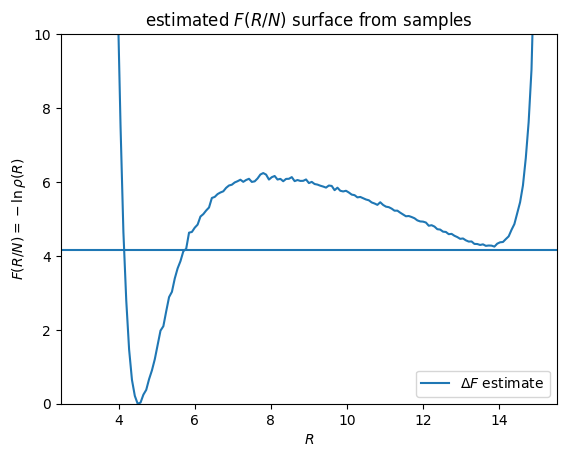

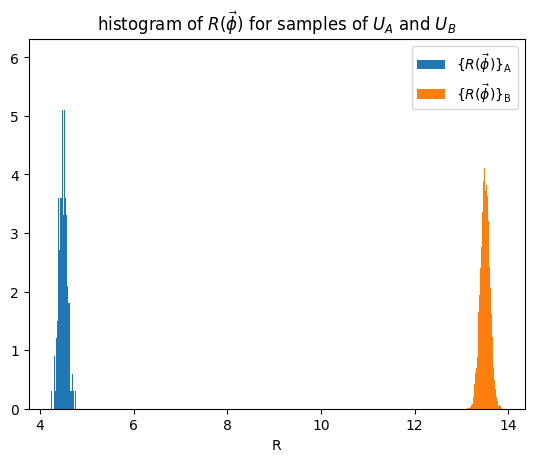

total number of samples 185000
samples for U_A 308
samples for U_B 13946
dF = F_B - F_A estimate from reweighting: [4.174073157849319]


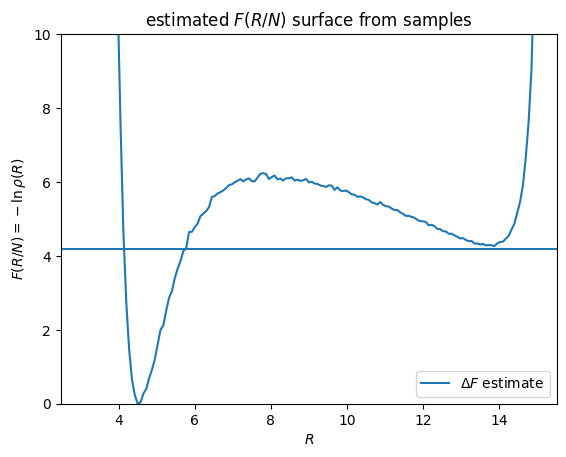

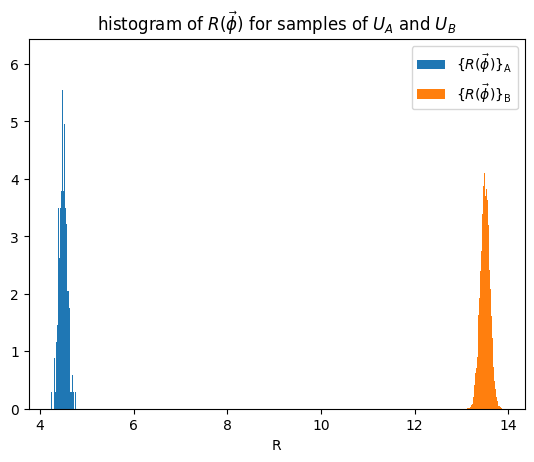

total number of samples 190000
samples for U_A 318
samples for U_B 14375
dF = F_B - F_A estimate from reweighting: [4.177507385196266]


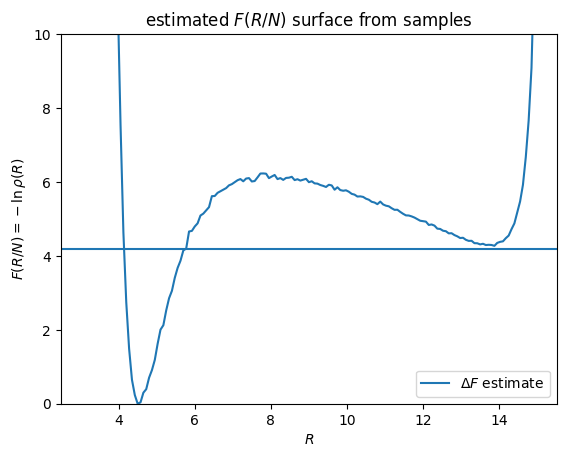

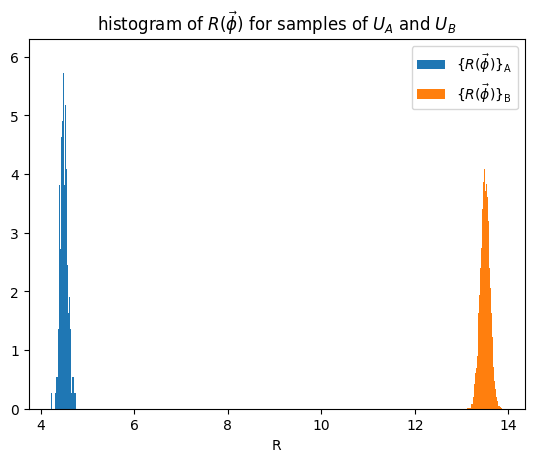

total number of samples 195000
samples for U_A 331
samples for U_B 14760
dF = F_B - F_A estimate from reweighting: [4.193467867830826]


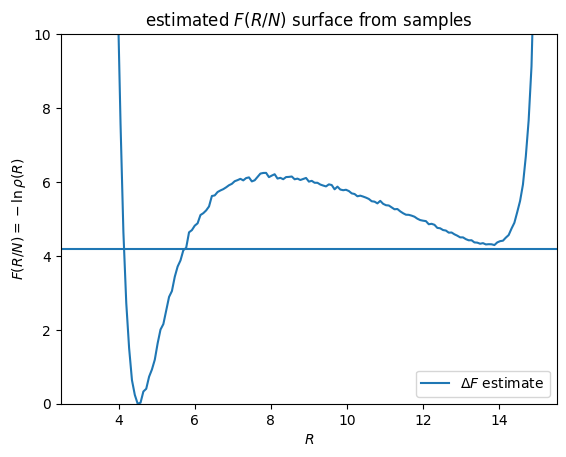

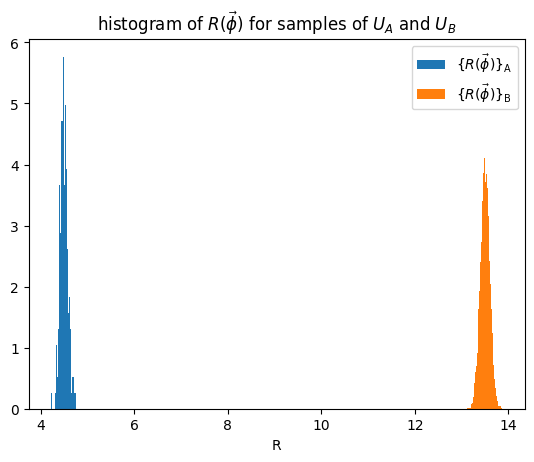

total number of samples 200000
samples for U_A 337
samples for U_B 15169
dF = F_B - F_A estimate from reweighting: [4.184013929184919]


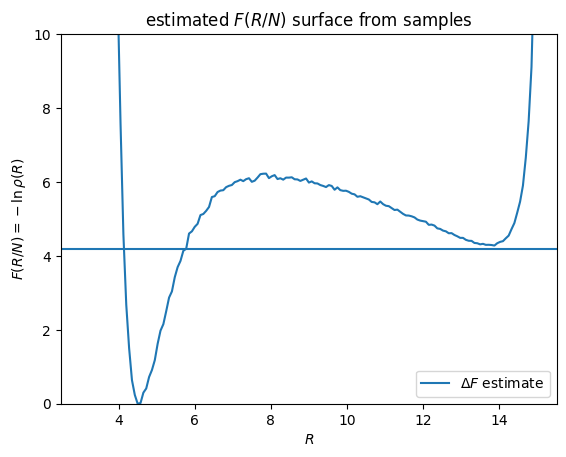

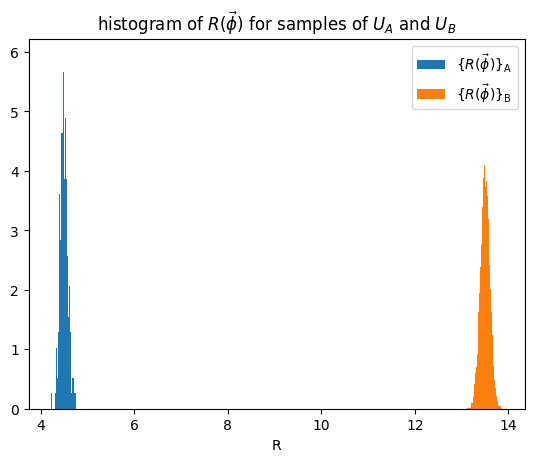

total number of samples 205000
samples for U_A 343
samples for U_B 15537
dF = F_B - F_A estimate from reweighting: [4.177514185993781]


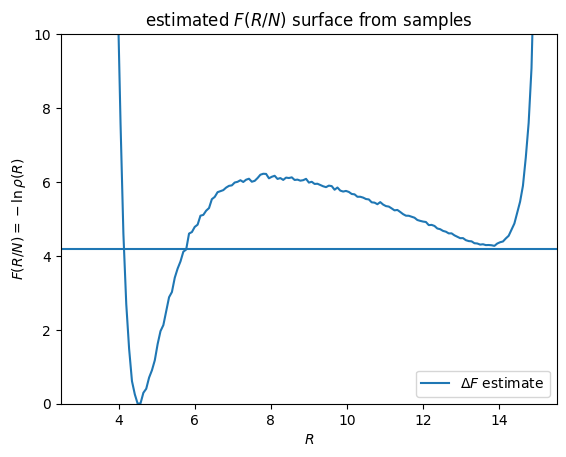

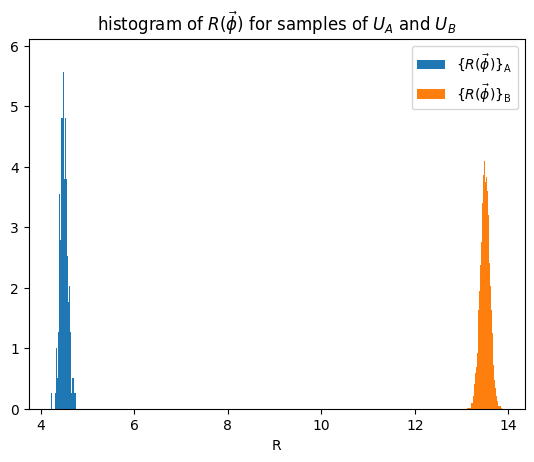

total number of samples 210000
samples for U_A 347
samples for U_B 15928
dF = F_B - F_A estimate from reweighting: [4.1654710849965735]


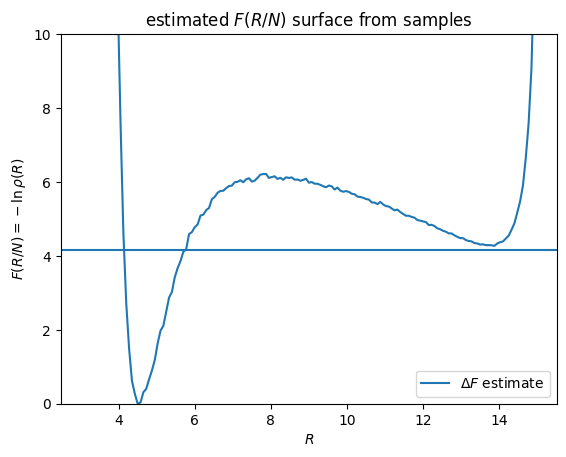

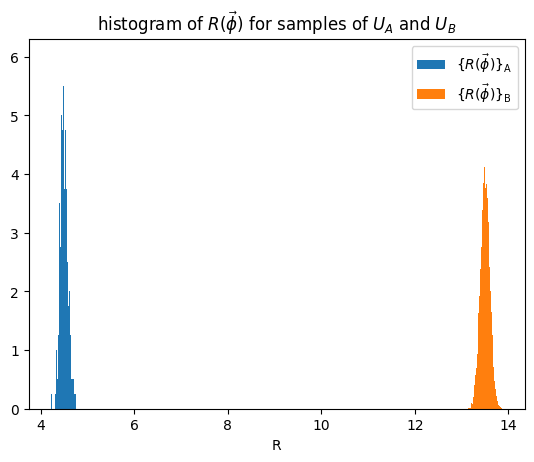

total number of samples 215000
samples for U_A 358
samples for U_B 16324
dF = F_B - F_A estimate from reweighting: [4.175228050498255]


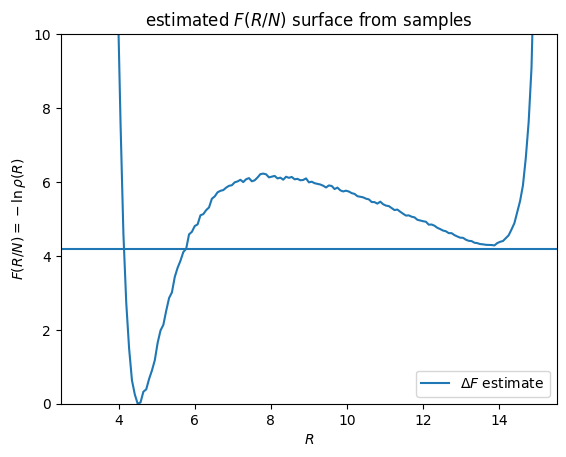

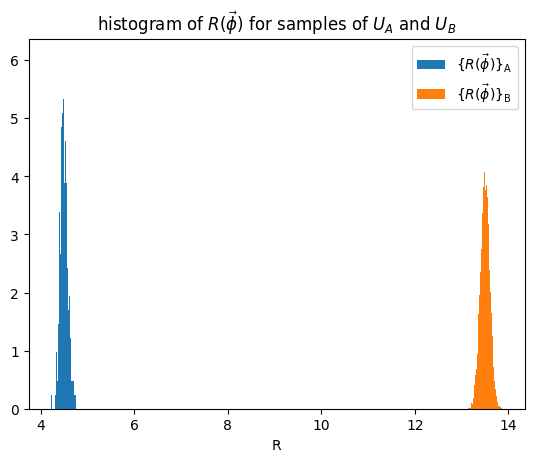

total number of samples 220000
samples for U_A 369
samples for U_B 16701
dF = F_B - F_A estimate from reweighting: [4.178316328945218]


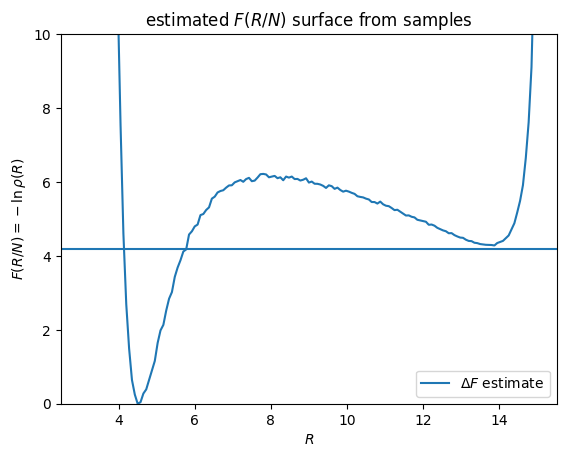

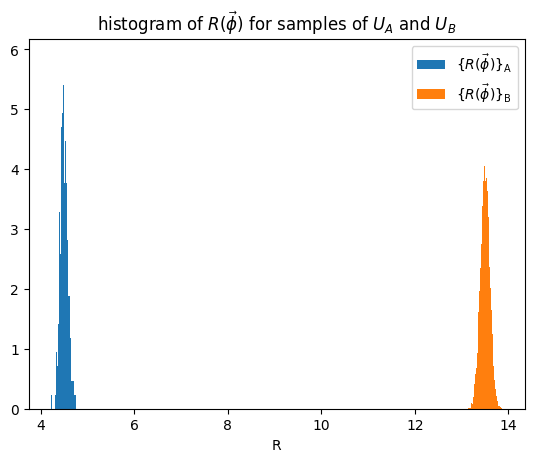

total number of samples 225000
samples for U_A 379
samples for U_B 17092
dF = F_B - F_A estimate from reweighting: [4.1826396245375985]


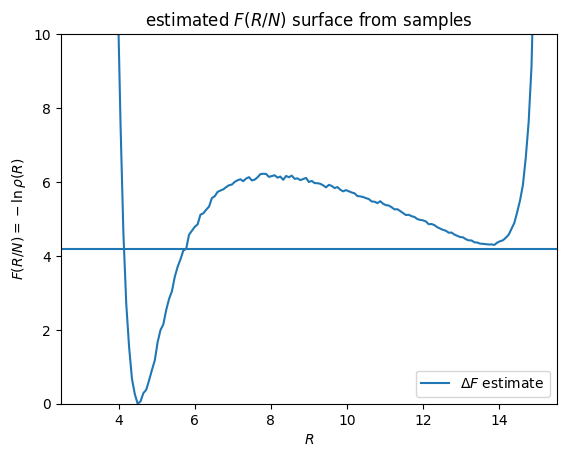

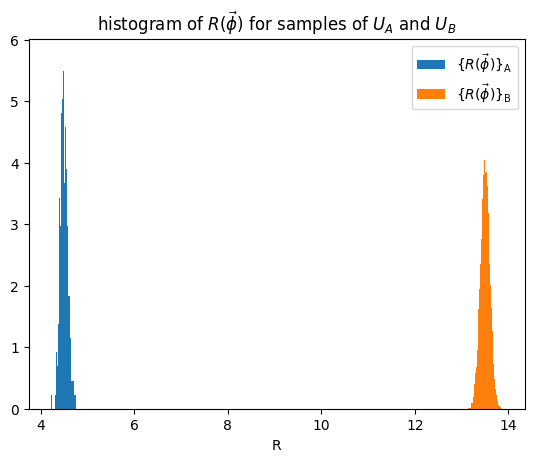

total number of samples 230000
samples for U_A 388
samples for U_B 17485
dF = F_B - F_A estimate from reweighting: [4.185559993232674]


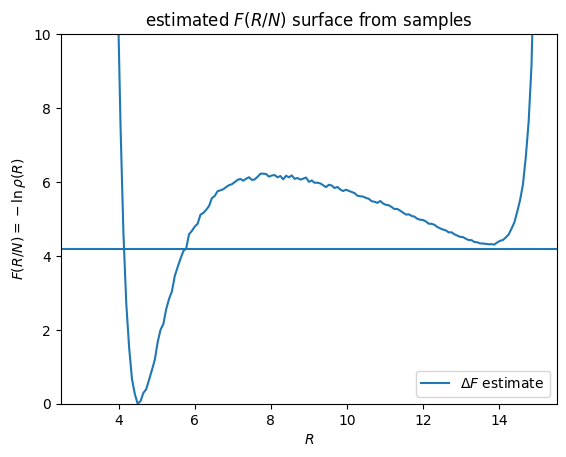

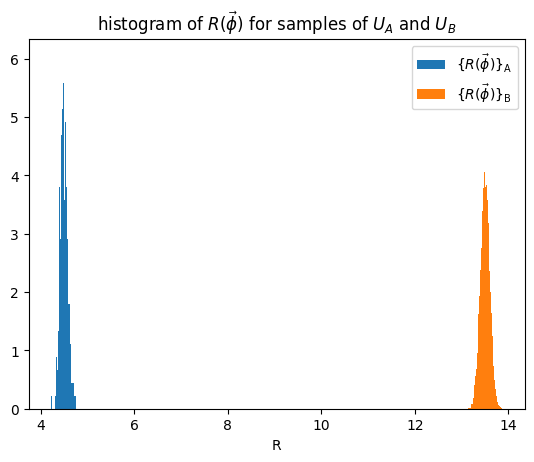

total number of samples 235000
samples for U_A 394
samples for U_B 17898
dF = F_B - F_A estimate from reweighting: [4.174357499444026]


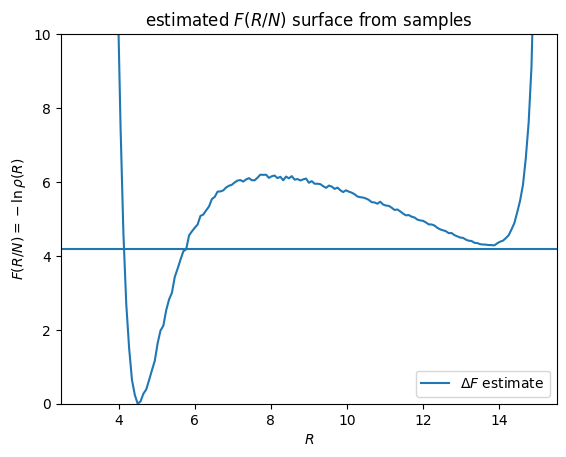

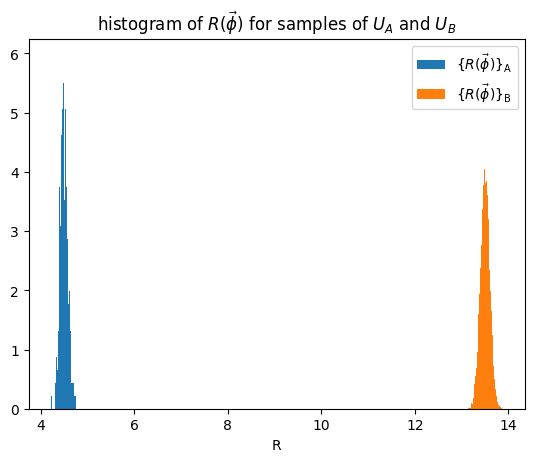

total number of samples 240000
samples for U_A 402
samples for U_B 18270
dF = F_B - F_A estimate from reweighting: [4.173475268727184]


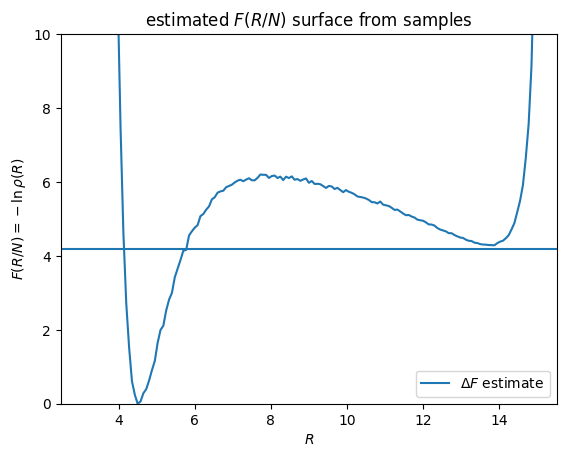

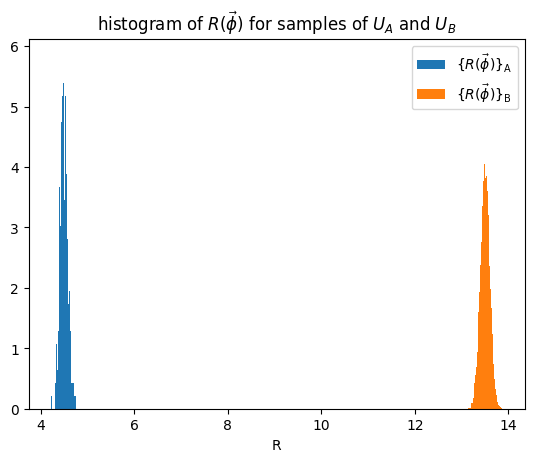

total number of samples 245000
samples for U_A 412
samples for U_B 18636
dF = F_B - F_A estimate from reweighting: [4.175157500305183]


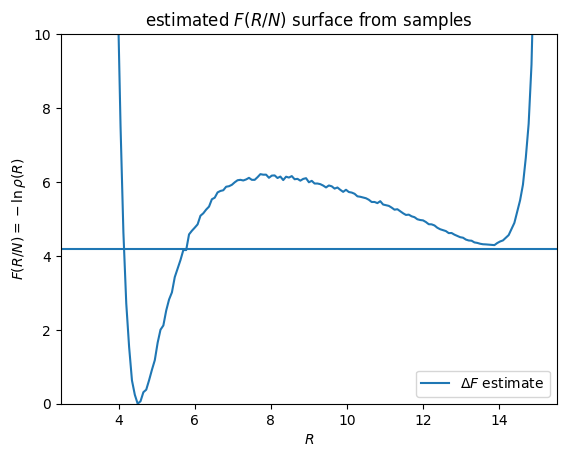

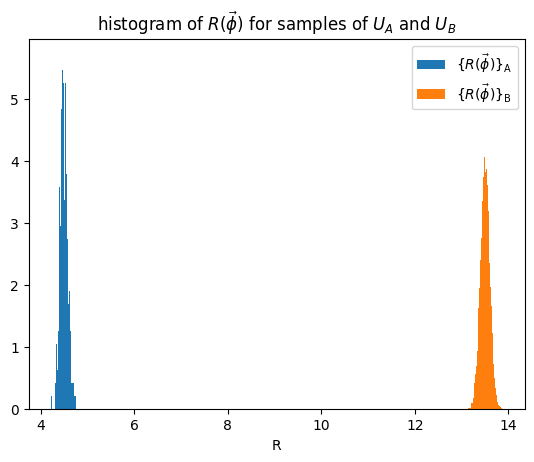

total number of samples 250000
samples for U_A 419
samples for U_B 18996
dF = F_B - F_A estimate from reweighting: [4.176666353343892]


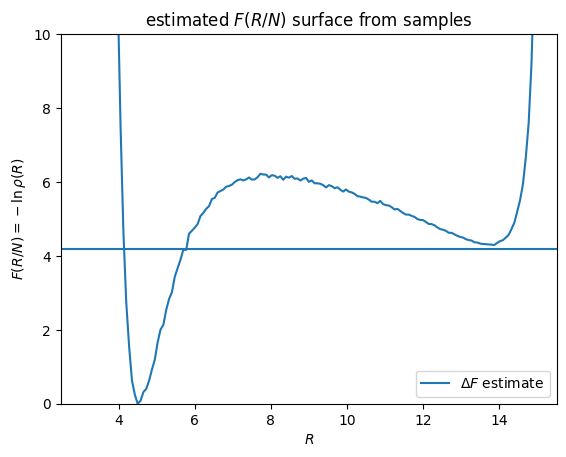

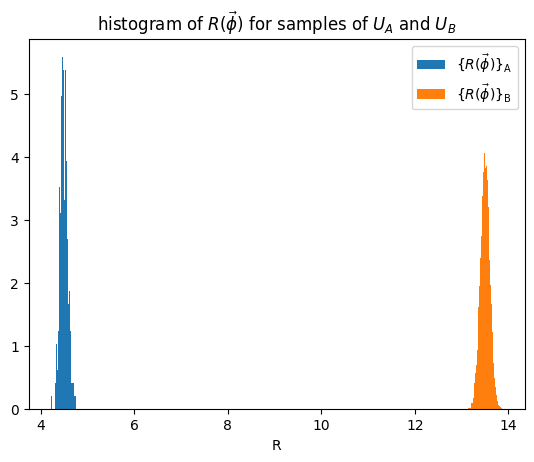

total number of samples 255000
samples for U_A 429
samples for U_B 19335
dF = F_B - F_A estimate from reweighting: [4.175849224348616]


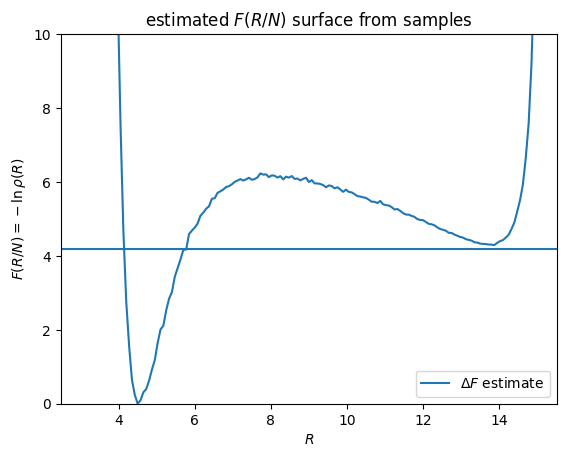

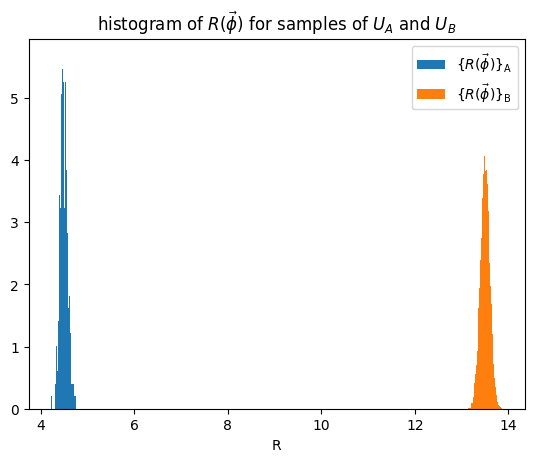

total number of samples 260000
samples for U_A 432
samples for U_B 19709
dF = F_B - F_A estimate from reweighting: [4.169899508379299]


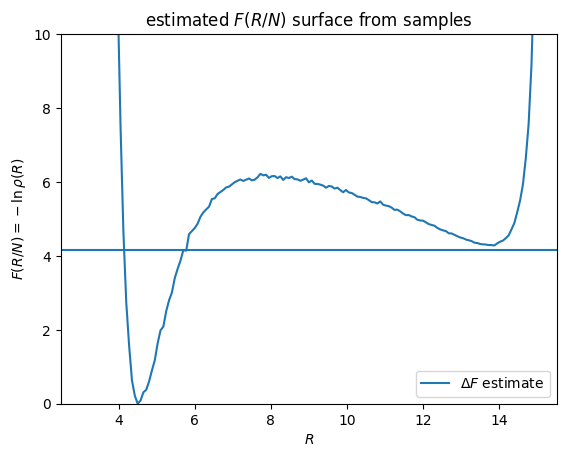

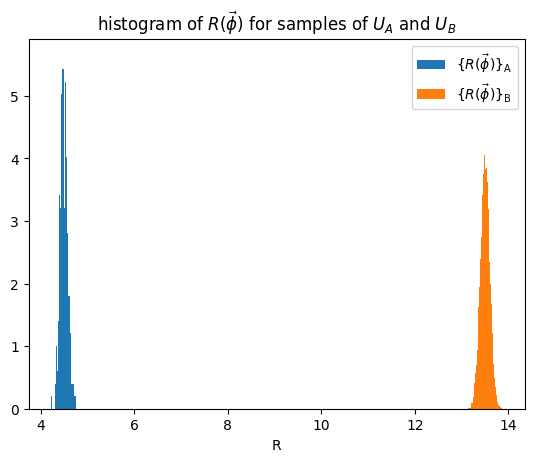

total number of samples 265000
samples for U_A 446
samples for U_B 20077
dF = F_B - F_A estimate from reweighting: [4.175898483766655]


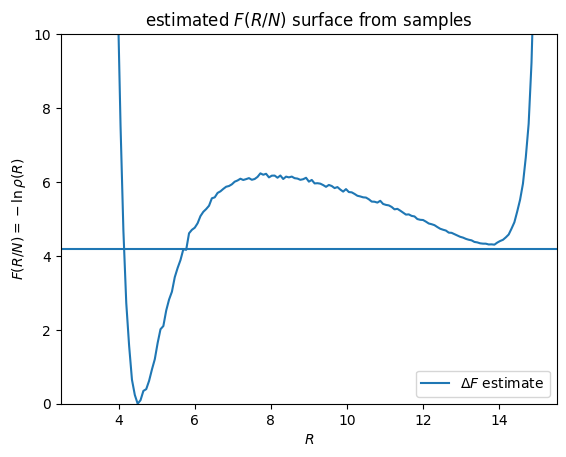

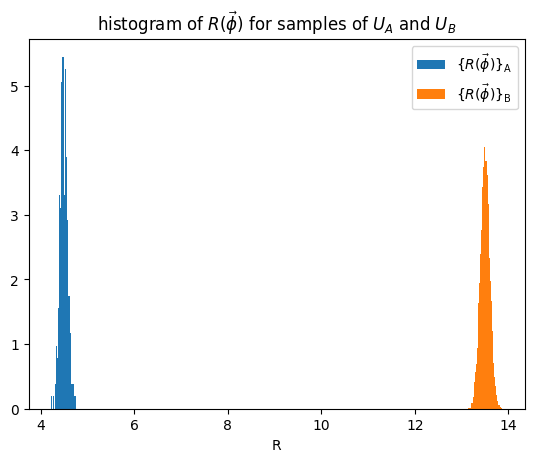

total number of samples 270000
samples for U_A 454
samples for U_B 20436
dF = F_B - F_A estimate from reweighting: [4.177241283686522]


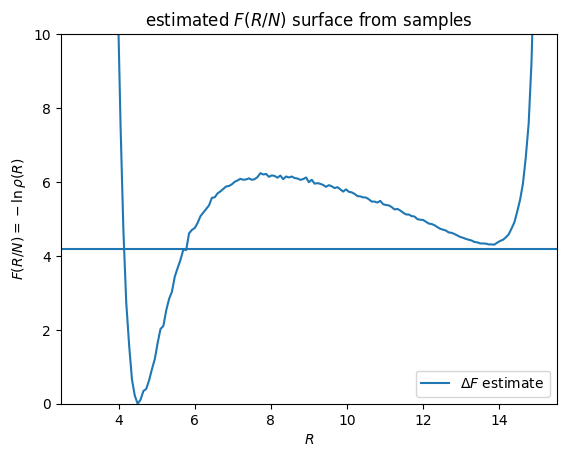

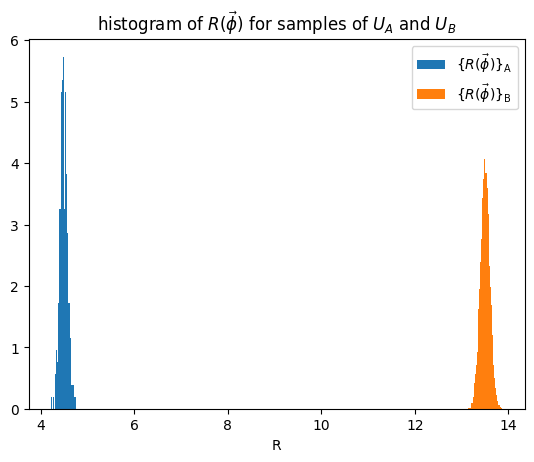

total number of samples 275000
samples for U_A 467
samples for U_B 20808
dF = F_B - F_A estimate from reweighting: [4.181093420643931]


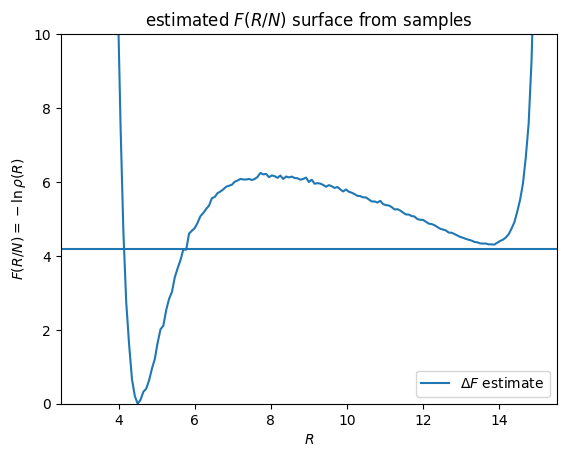

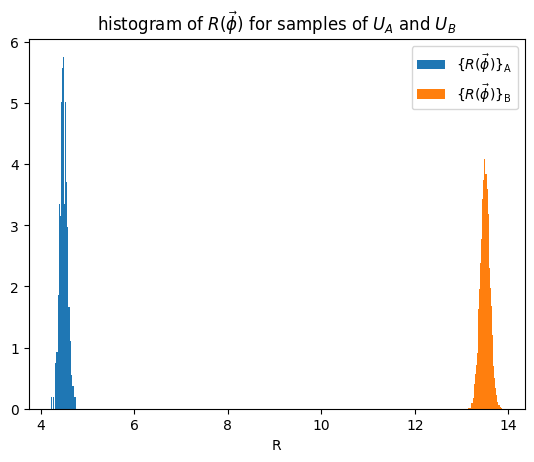

total number of samples 280000
samples for U_A 476
samples for U_B 21192
dF = F_B - F_A estimate from reweighting: [4.178622058255209]


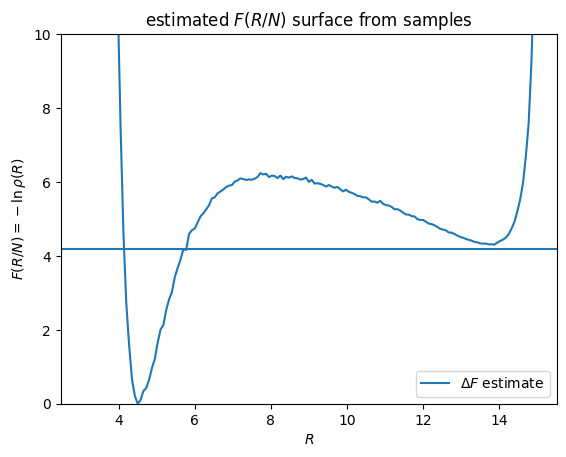

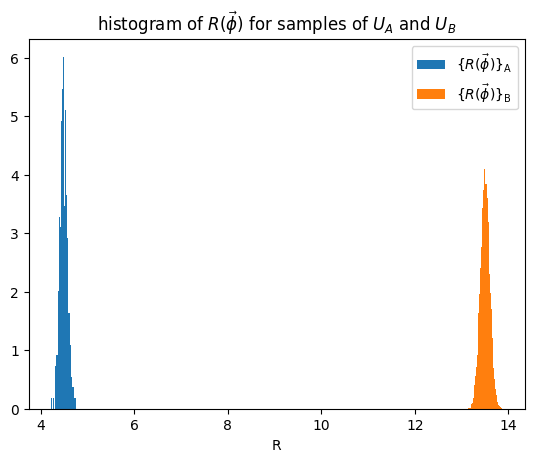

total number of samples 285000
samples for U_A 483
samples for U_B 21569
dF = F_B - F_A estimate from reweighting: [4.17742539812266]


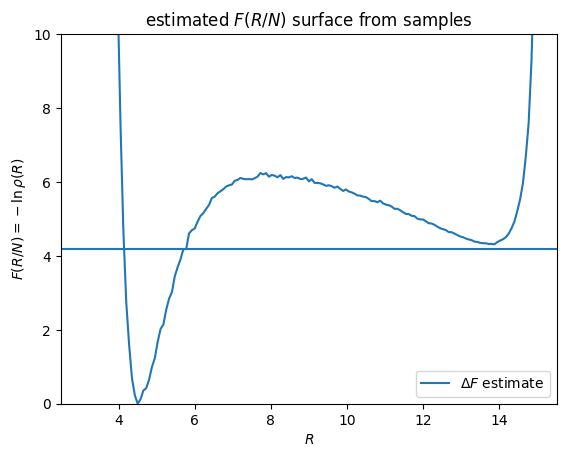

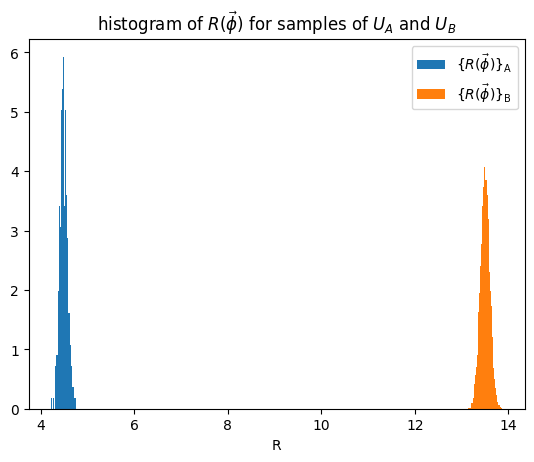

total number of samples 290000
samples for U_A 492
samples for U_B 21951
dF = F_B - F_A estimate from reweighting: [4.180491408448935]


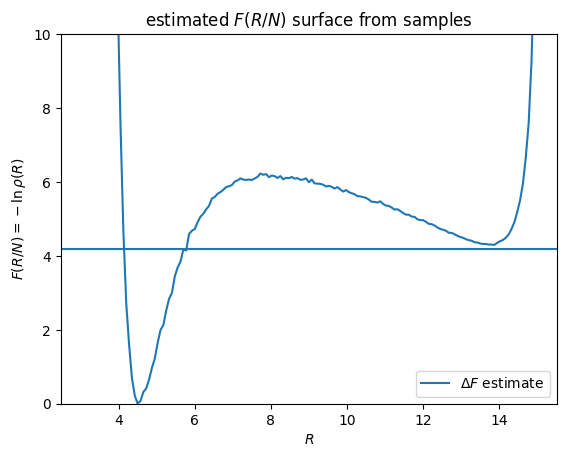

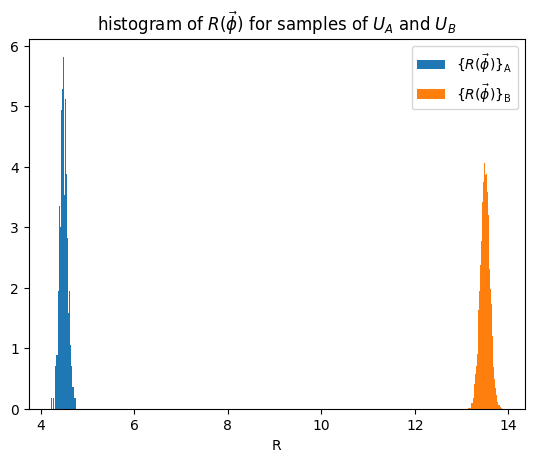

total number of samples 295000
samples for U_A 504
samples for U_B 22322
dF = F_B - F_A estimate from reweighting: [4.185489373436388]


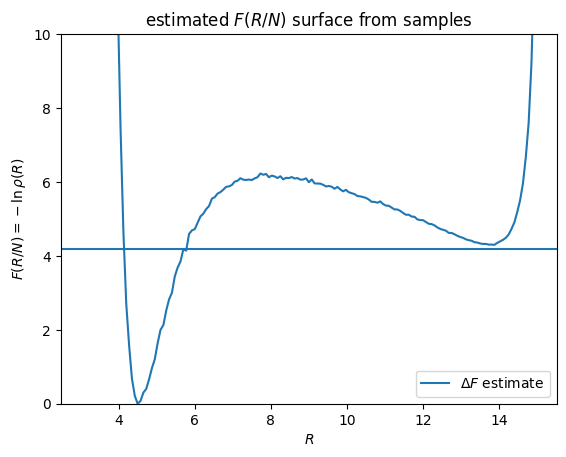

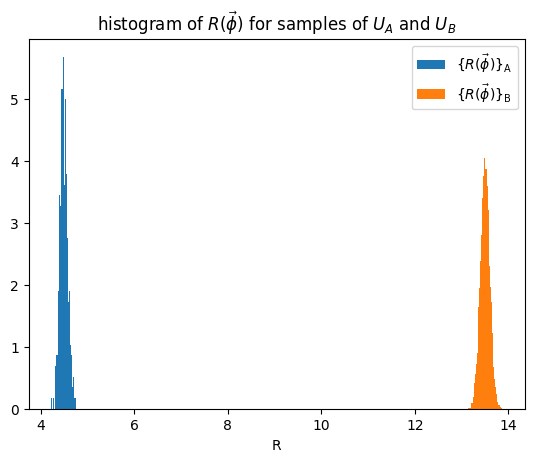

total number of samples 300000
samples for U_A 511
samples for U_B 22703
dF = F_B - F_A estimate from reweighting: [4.181088182496696]


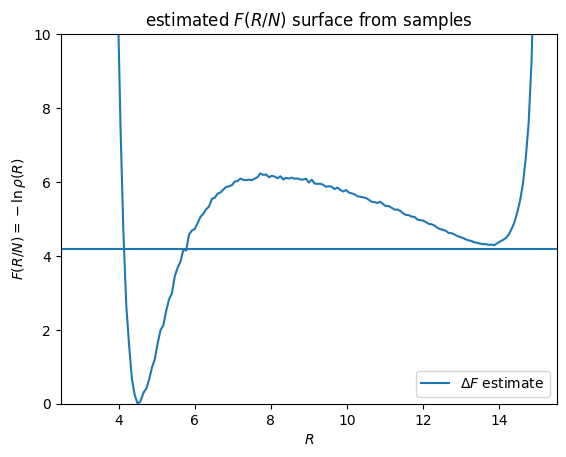

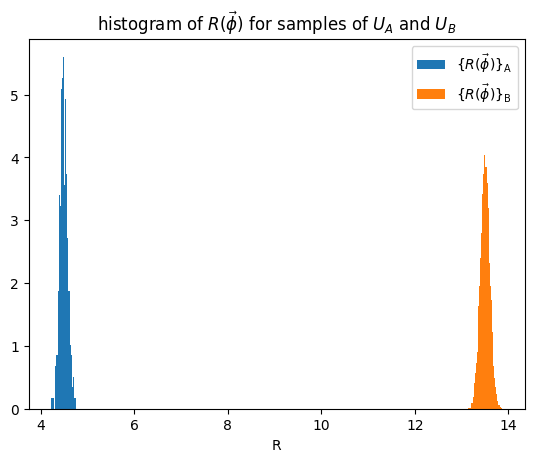

total number of samples 305000
samples for U_A 516
samples for U_B 23104
dF = F_B - F_A estimate from reweighting: [4.171046924892316]


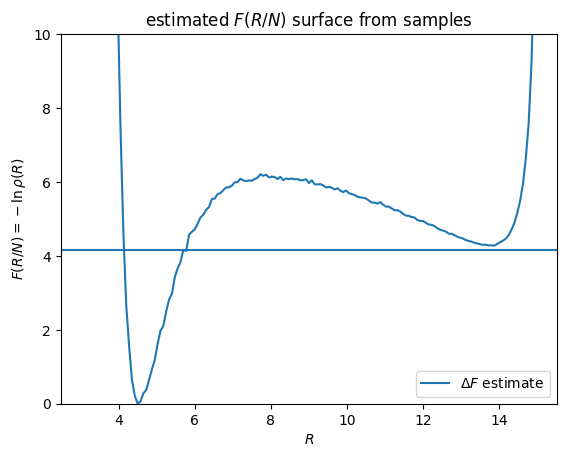

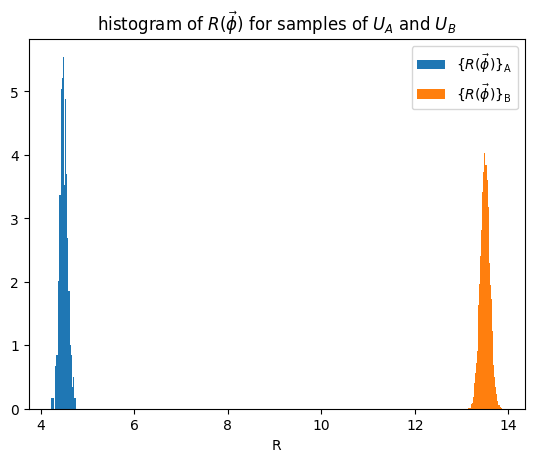

total number of samples 310000
samples for U_A 523
samples for U_B 23515
dF = F_B - F_A estimate from reweighting: [4.169629157914111]


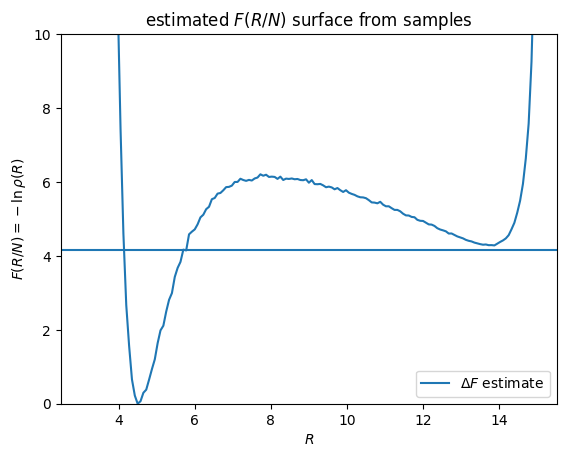

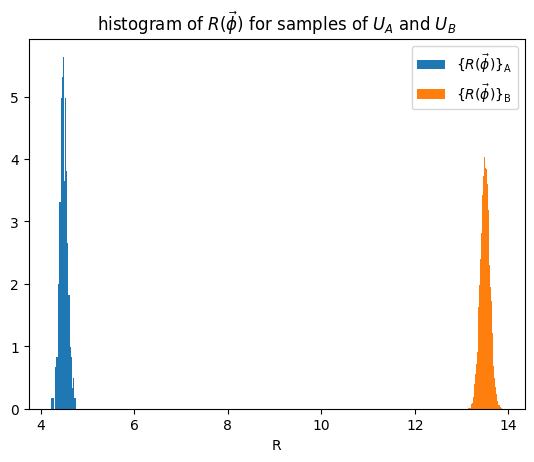

total number of samples 315000
samples for U_A 531
samples for U_B 23919
dF = F_B - F_A estimate from reweighting: [4.165709824053506]


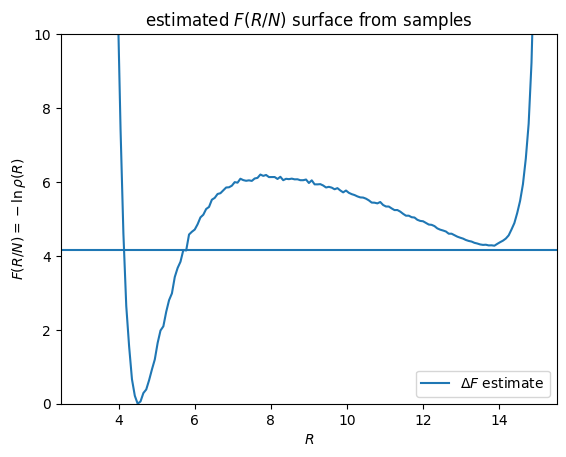

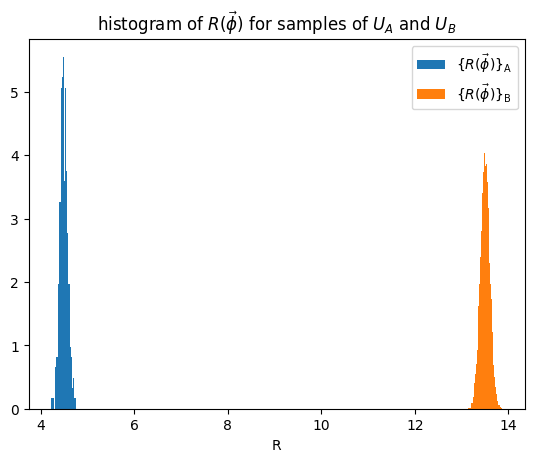

total number of samples 320000
samples for U_A 540
samples for U_B 24300
dF = F_B - F_A estimate from reweighting: [4.164368145687213]


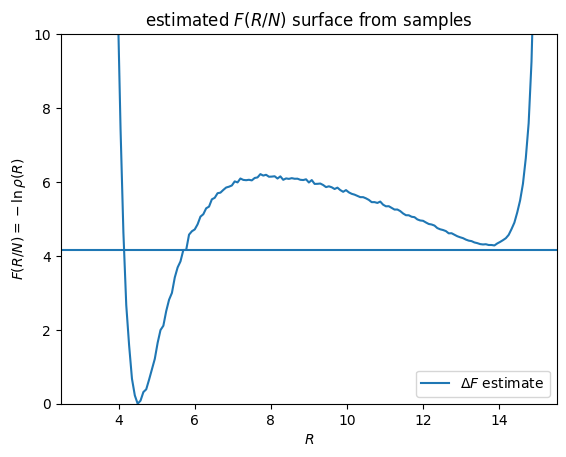

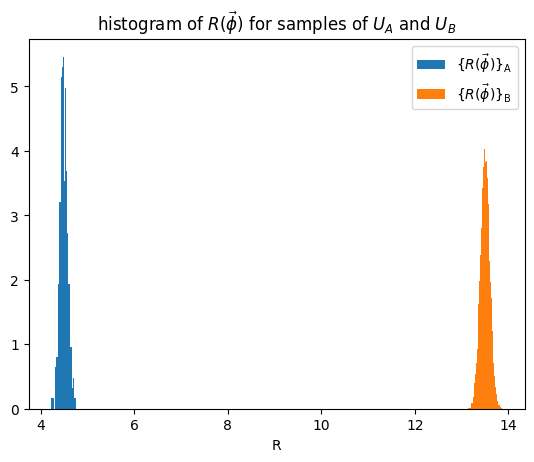

total number of samples 325000
samples for U_A 548
samples for U_B 24668
dF = F_B - F_A estimate from reweighting: [4.159346746138057]


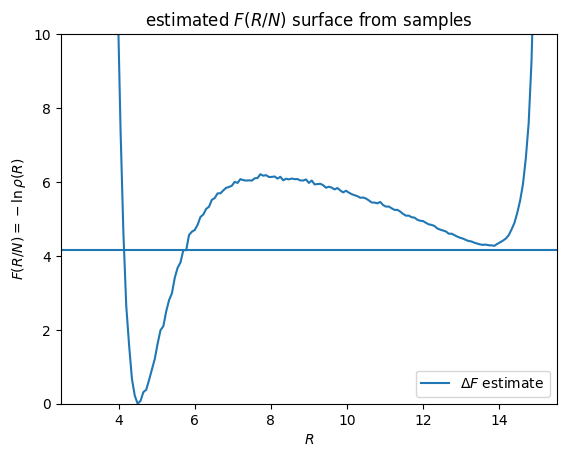

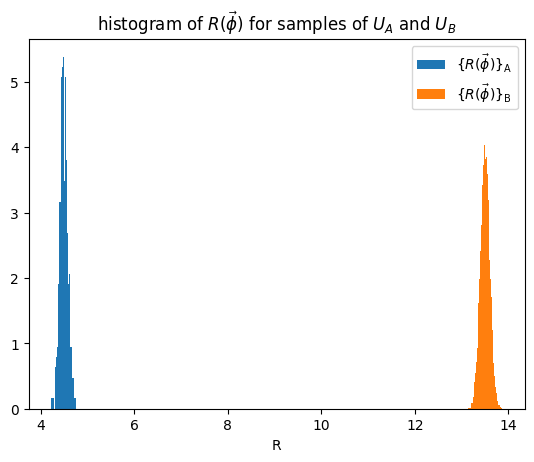

total number of samples 330000
samples for U_A 558
samples for U_B 25052
dF = F_B - F_A estimate from reweighting: [4.162772577358318]


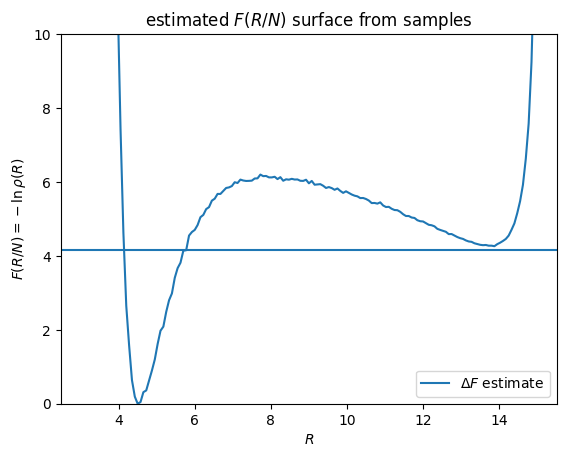

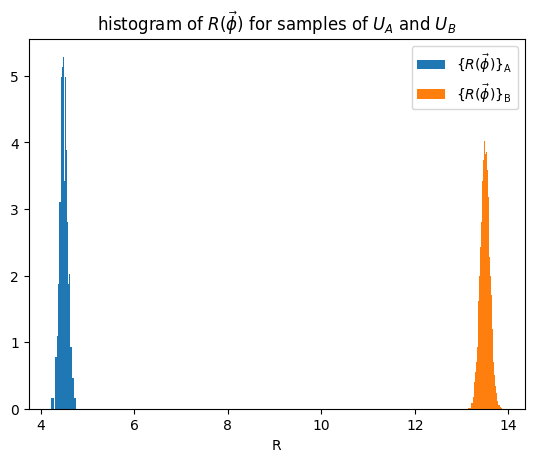

total number of samples 335000
samples for U_A 568
samples for U_B 25432
dF = F_B - F_A estimate from reweighting: [4.167482301736985]


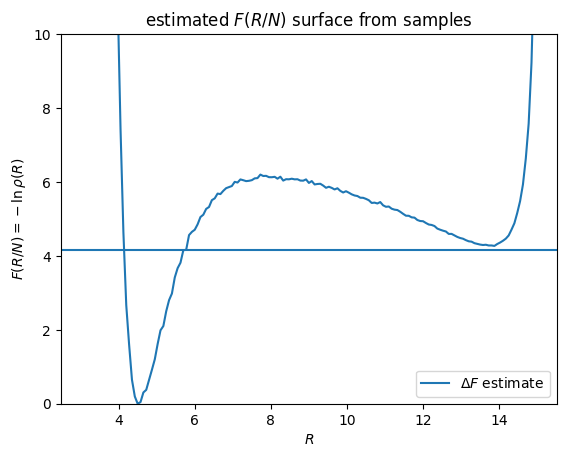

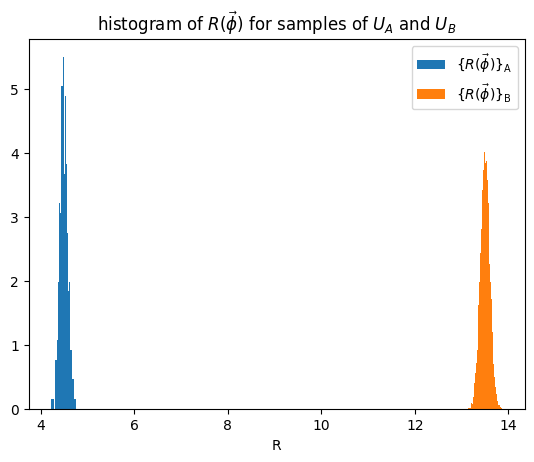

total number of samples 340000
samples for U_A 575
samples for U_B 25788
dF = F_B - F_A estimate from reweighting: [4.164440826629281]


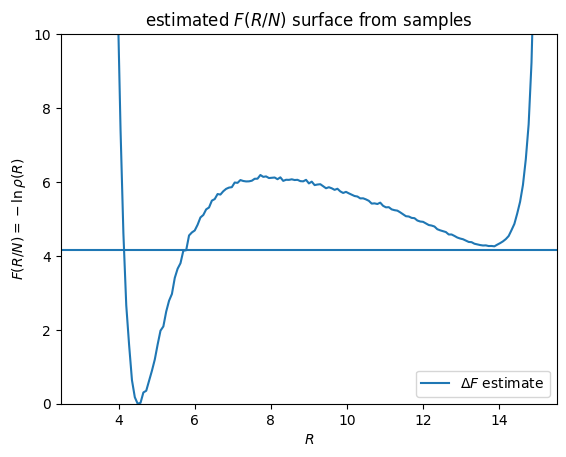

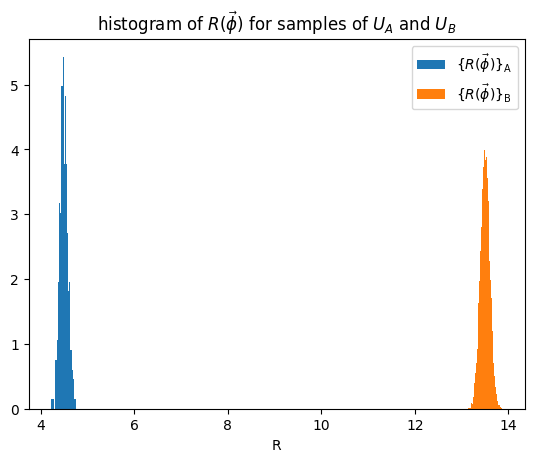

total number of samples 345000
samples for U_A 582
samples for U_B 26138
dF = F_B - F_A estimate from reweighting: [4.163339282498077]


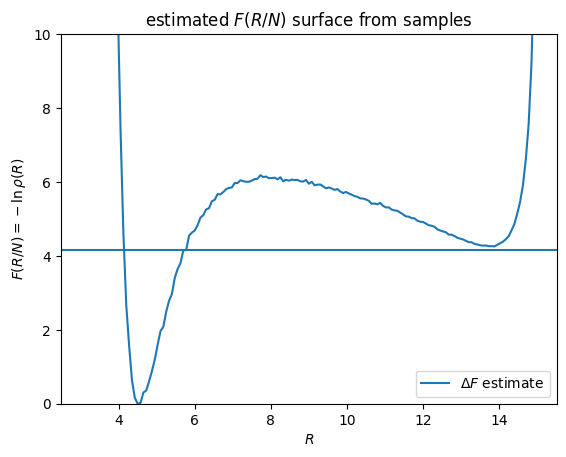

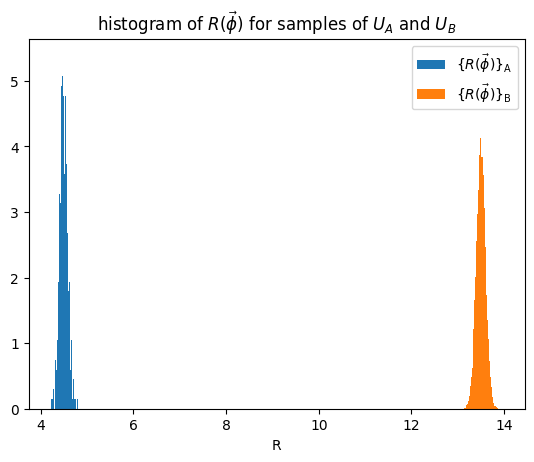

total number of samples 350000
samples for U_A 584
samples for U_B 26529
dF = F_B - F_A estimate from reweighting: [4.157209846458063]


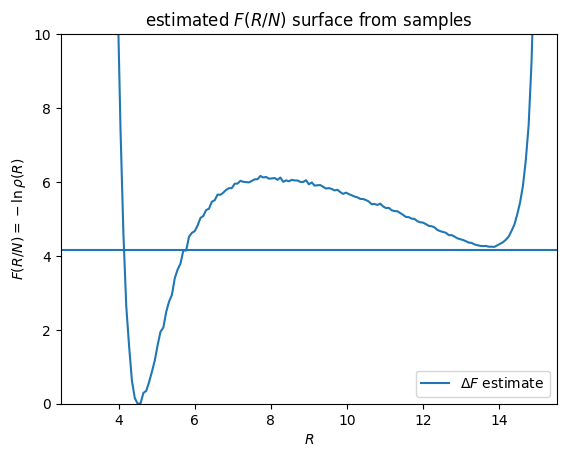

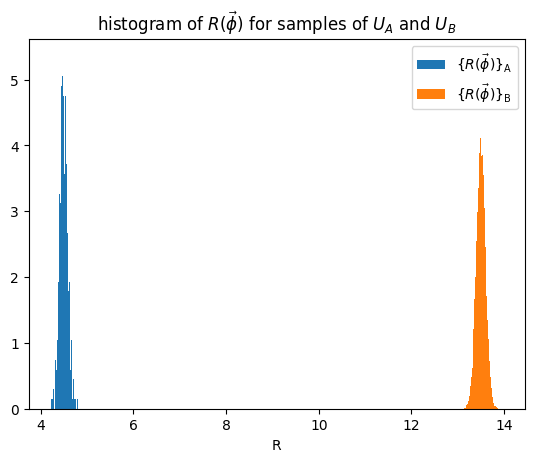

total number of samples 355000
samples for U_A 594
samples for U_B 26888
dF = F_B - F_A estimate from reweighting: [4.160904712996876]


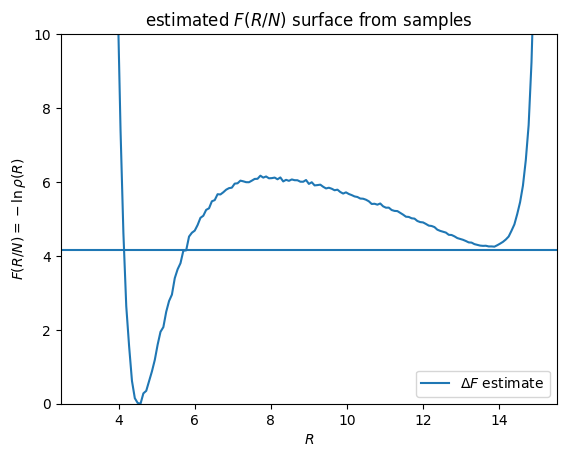

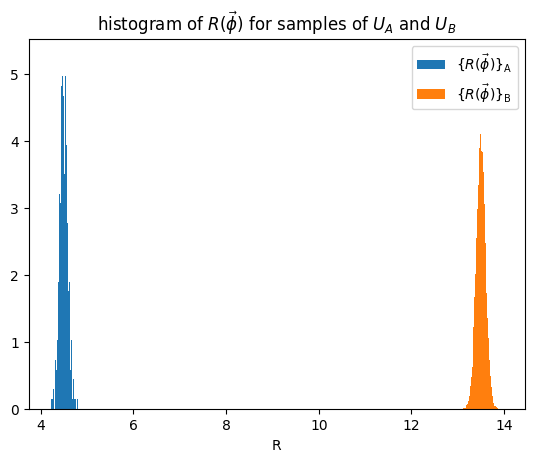

total number of samples 360000
samples for U_A 598
samples for U_B 27249
dF = F_B - F_A estimate from reweighting: [4.156470977111015]


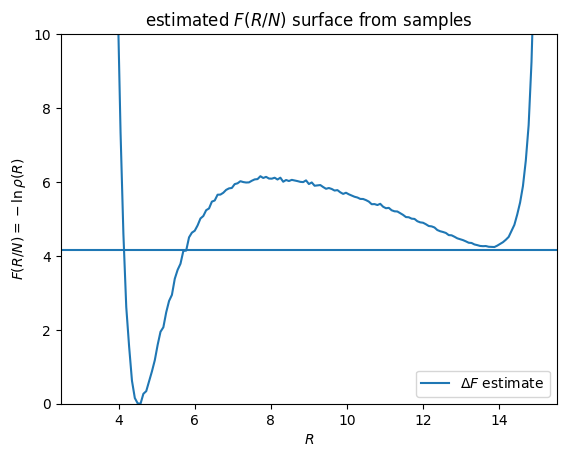

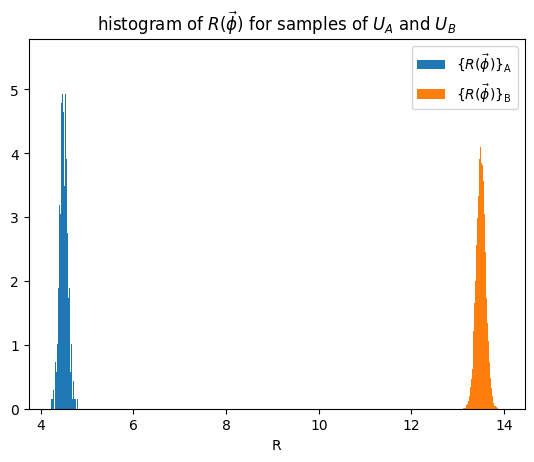

total number of samples 365000
samples for U_A 610
samples for U_B 27636
dF = F_B - F_A estimate from reweighting: [4.161489935675947]


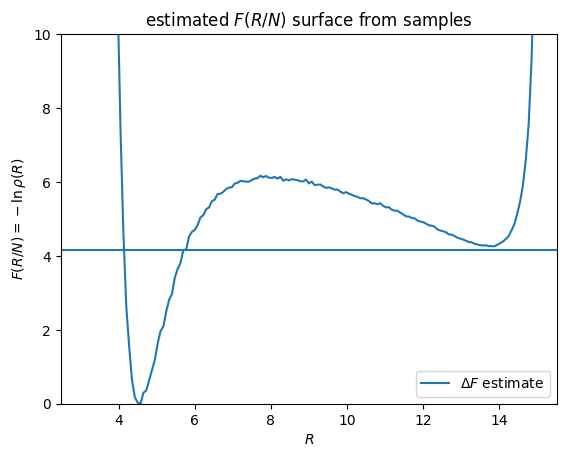

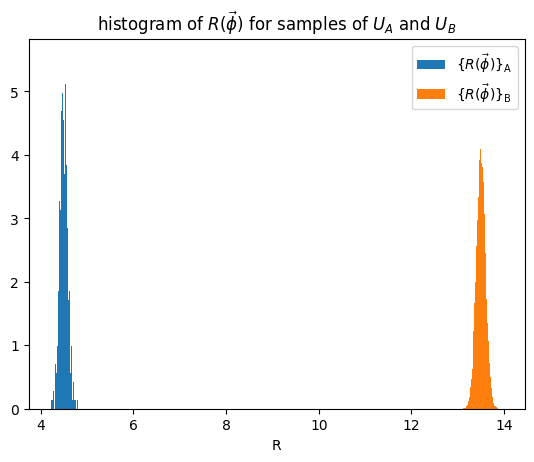

total number of samples 370000
samples for U_A 619
samples for U_B 28037
dF = F_B - F_A estimate from reweighting: [4.160686310811176]


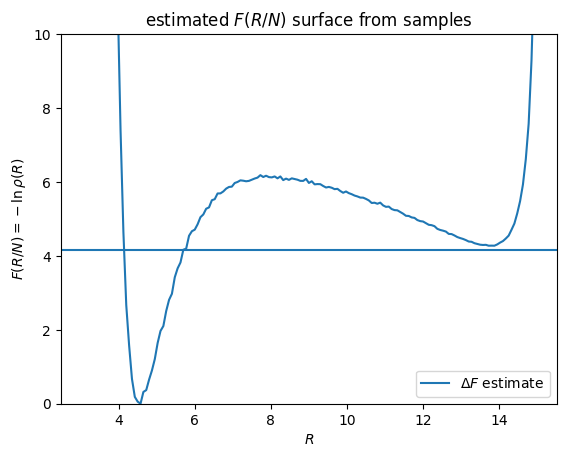

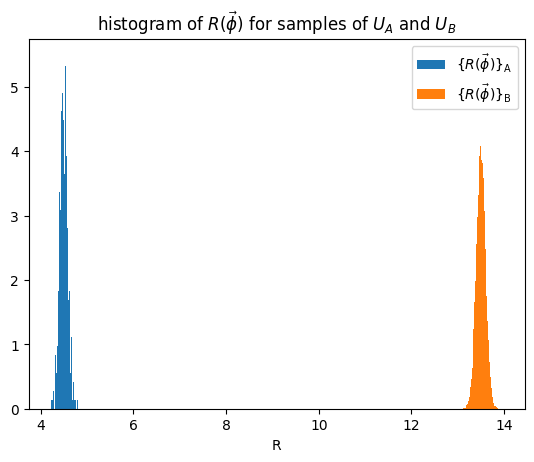

total number of samples 375000
samples for U_A 627
samples for U_B 28392
dF = F_B - F_A estimate from reweighting: [4.1626669148053566]


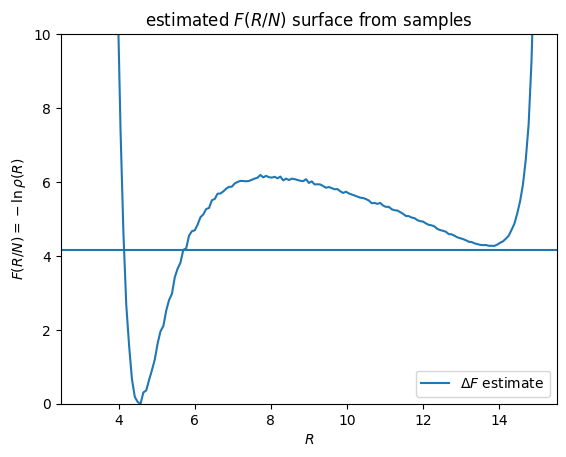

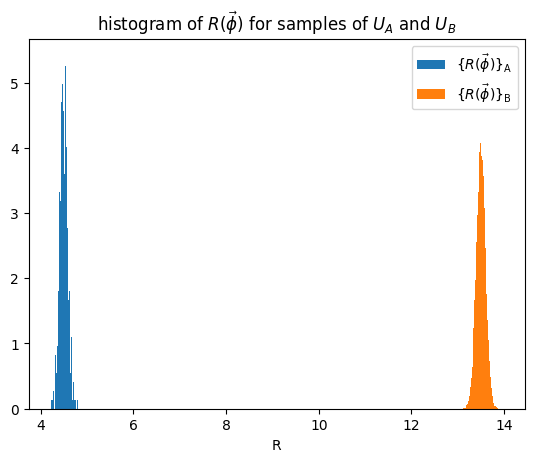

total number of samples 380000
samples for U_A 637
samples for U_B 28765
dF = F_B - F_A estimate from reweighting: [4.165920756881139]


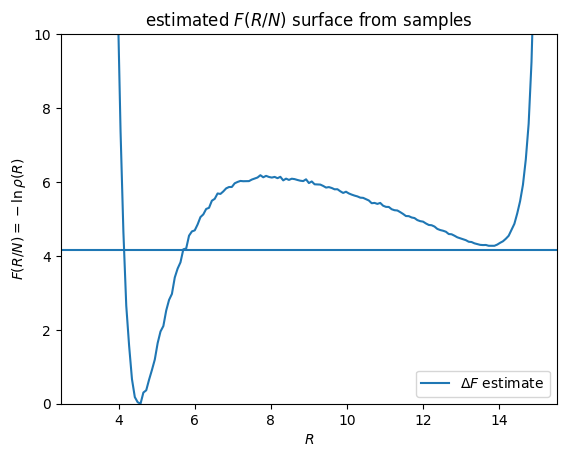

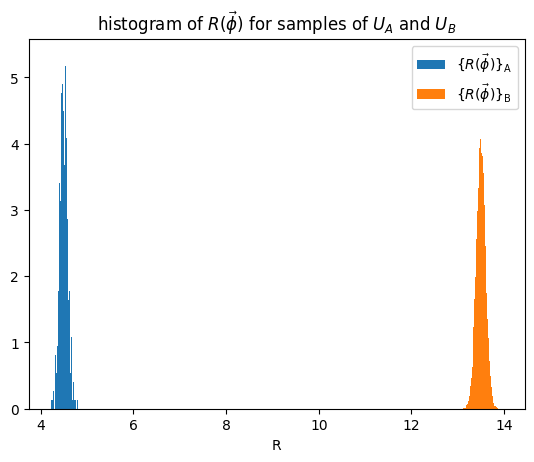

total number of samples 385000
samples for U_A 642
samples for U_B 29181
dF = F_B - F_A estimate from reweighting: [4.158665252617055]


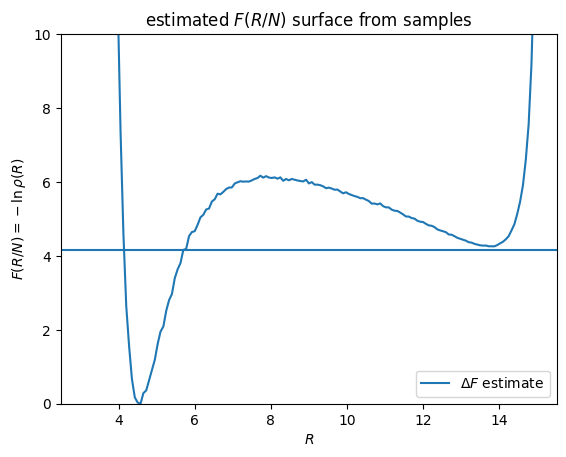

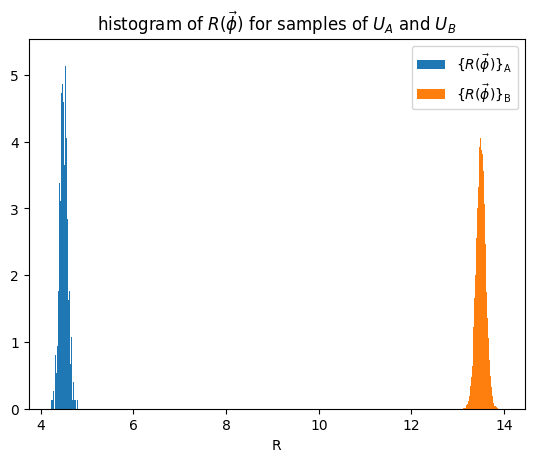

total number of samples 390000
samples for U_A 653
samples for U_B 29565
dF = F_B - F_A estimate from reweighting: [4.160067033158386]


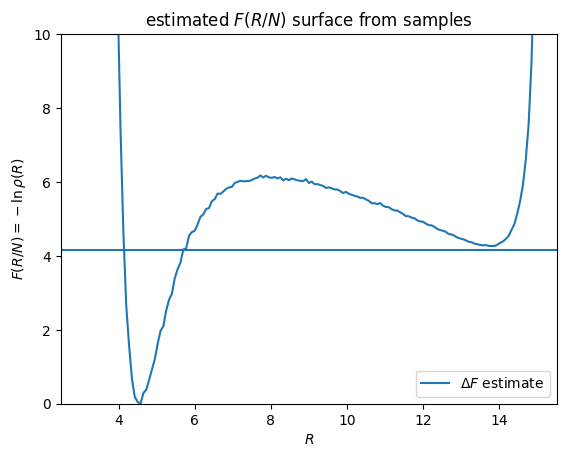

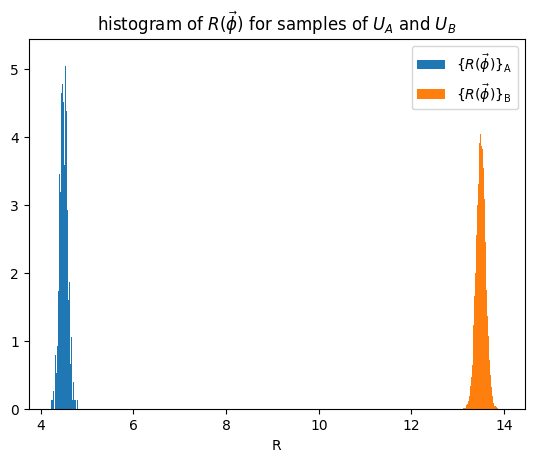

total number of samples 395000
samples for U_A 662
samples for U_B 29939
dF = F_B - F_A estimate from reweighting: [4.163976865742455]


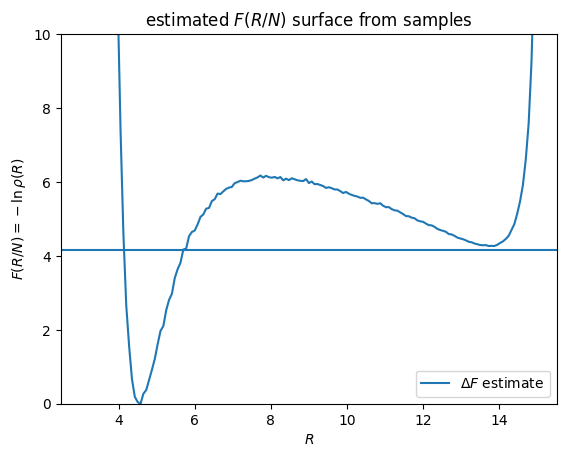

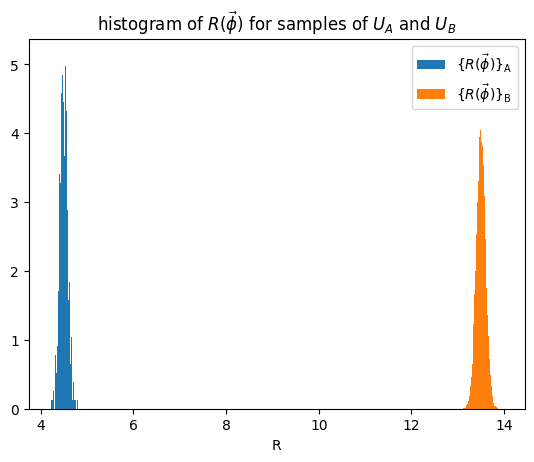

total number of samples 400000
samples for U_A 670
samples for U_B 30310
dF = F_B - F_A estimate from reweighting: [4.161513346880456]


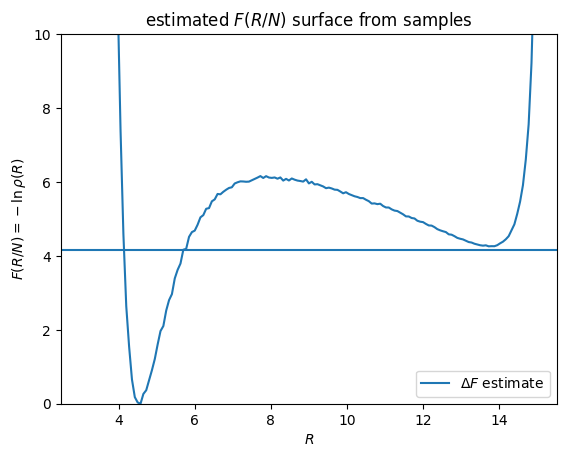

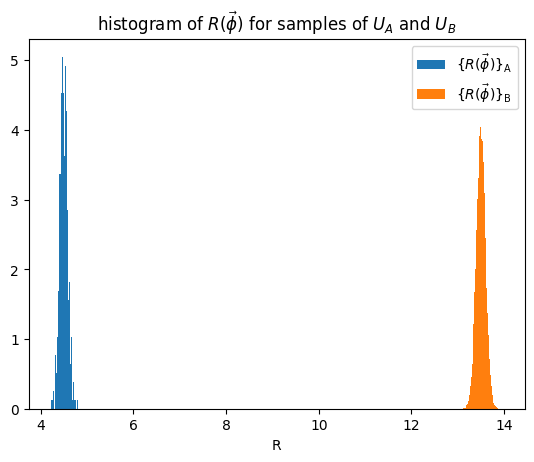

total number of samples 405000
samples for U_A 674
samples for U_B 30667
dF = F_B - F_A estimate from reweighting: [4.1621816219630325]


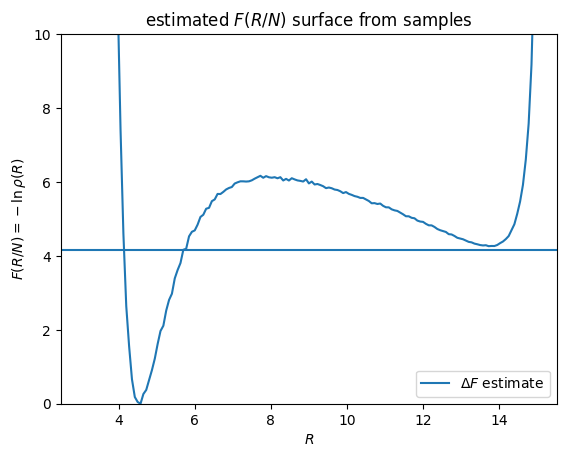

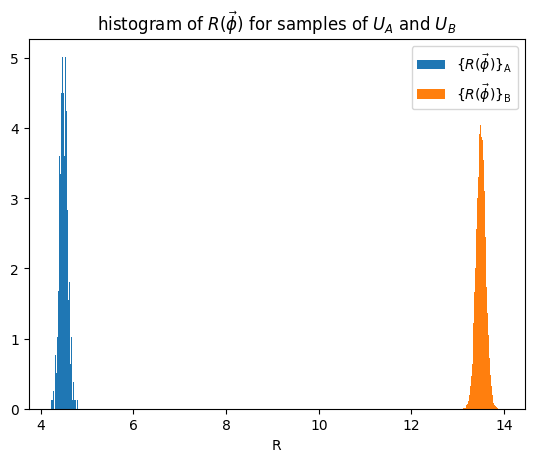

total number of samples 410000
samples for U_A 685
samples for U_B 31015
dF = F_B - F_A estimate from reweighting: [4.168842634032988]


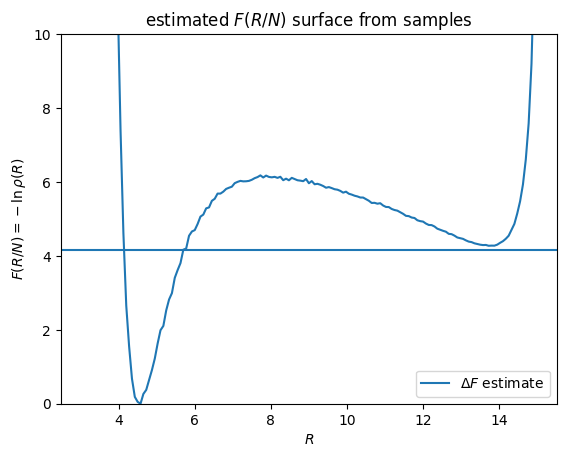

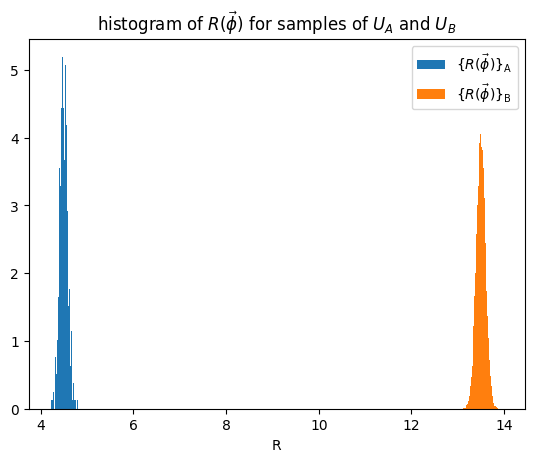

total number of samples 415000
samples for U_A 692
samples for U_B 31381
dF = F_B - F_A estimate from reweighting: [4.168478435489858]


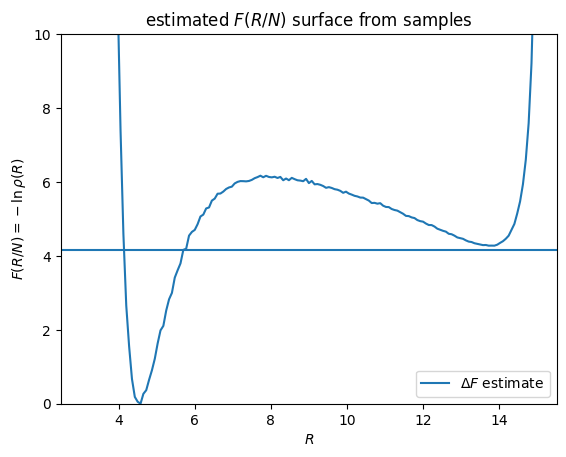

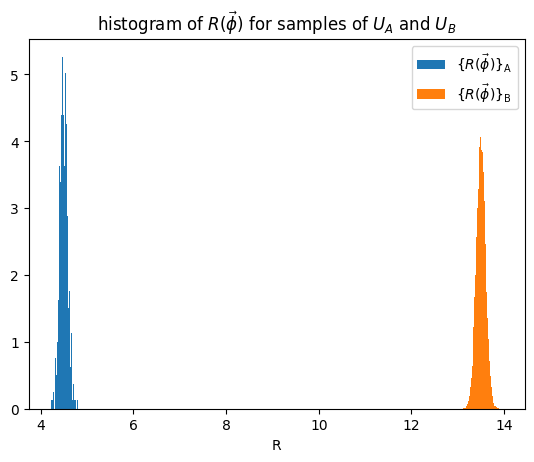

total number of samples 420000
samples for U_A 702
samples for U_B 31775
dF = F_B - F_A estimate from reweighting: [4.171395182136461]


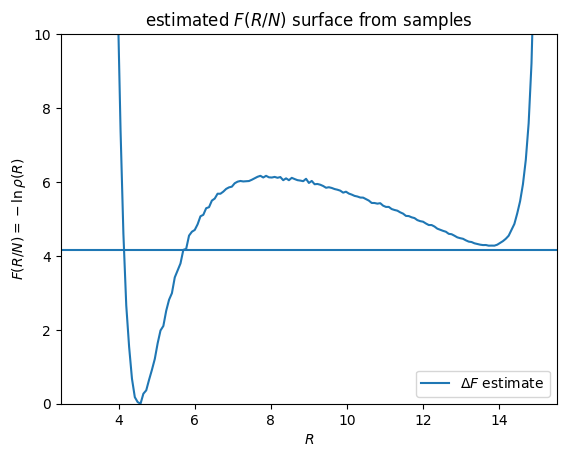

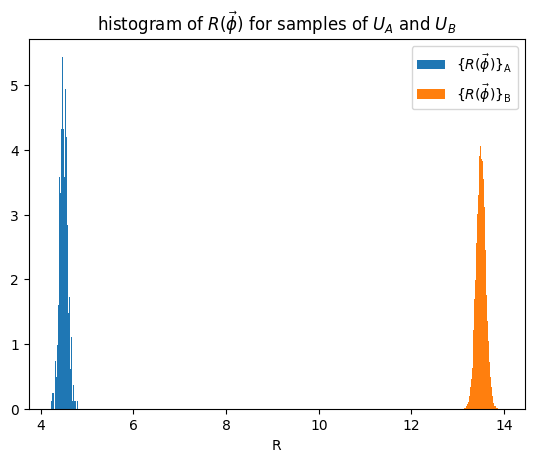

total number of samples 425000
samples for U_A 709
samples for U_B 32135
dF = F_B - F_A estimate from reweighting: [4.170385975562553]


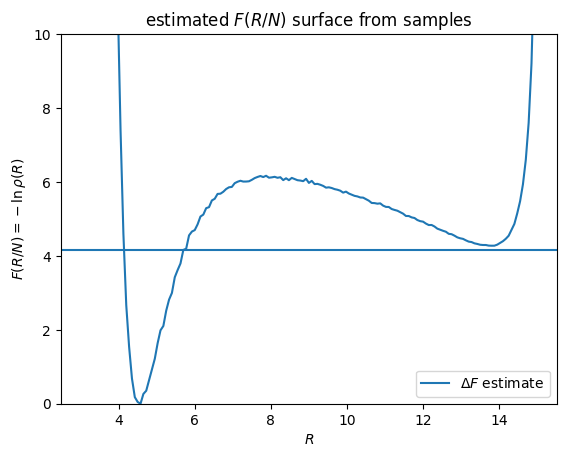

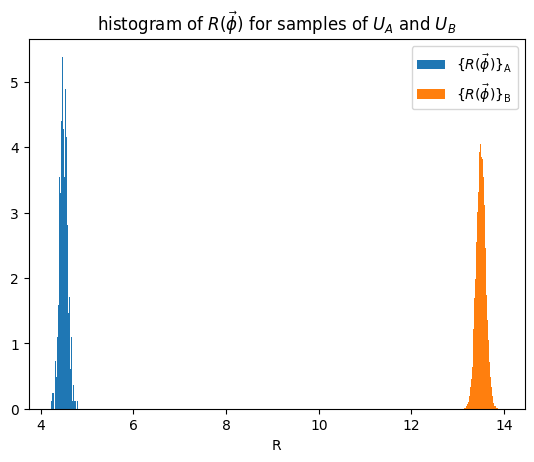

total number of samples 430000
samples for U_A 716
samples for U_B 32560
dF = F_B - F_A estimate from reweighting: [4.167404175138076]


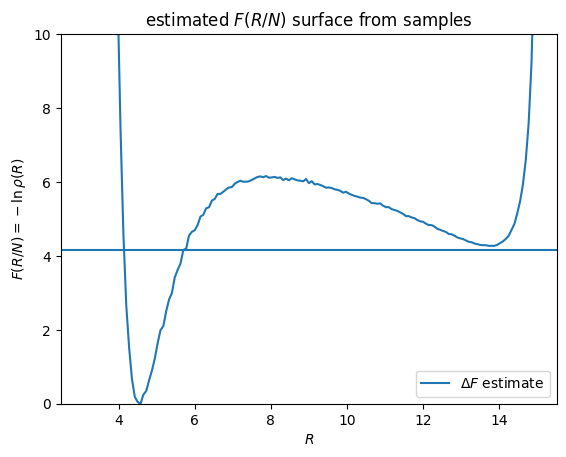

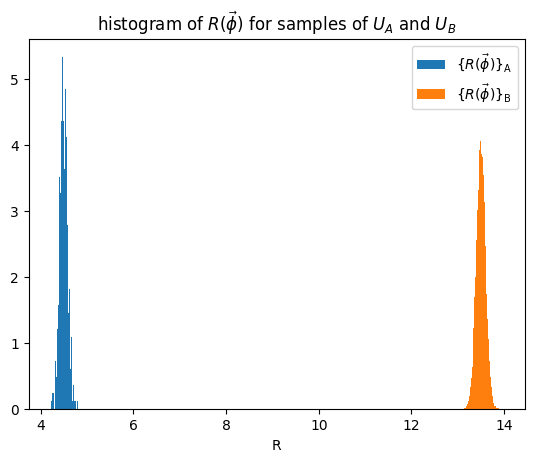

total number of samples 435000
samples for U_A 724
samples for U_B 32936
dF = F_B - F_A estimate from reweighting: [4.169397534914172]


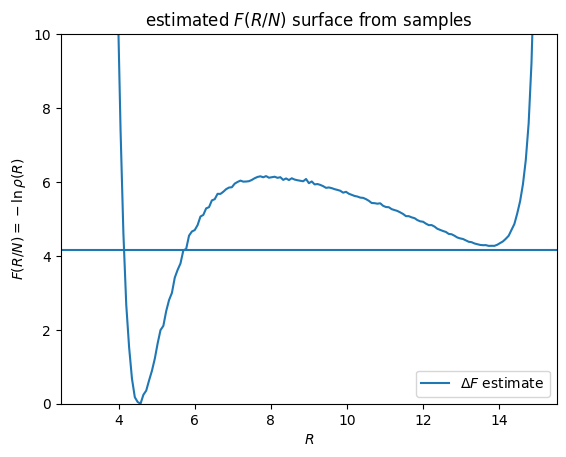

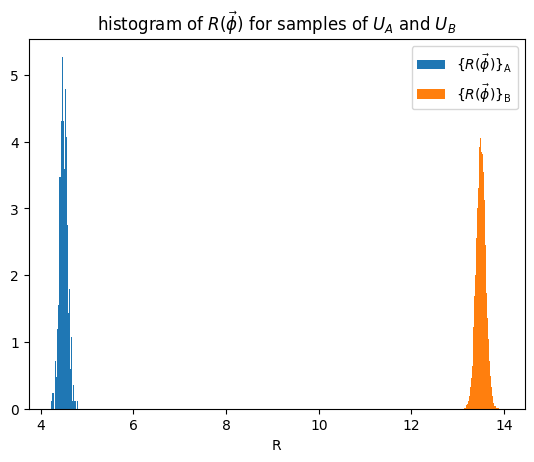

total number of samples 440000
samples for U_A 731
samples for U_B 33331
dF = F_B - F_A estimate from reweighting: [4.171044931130703]


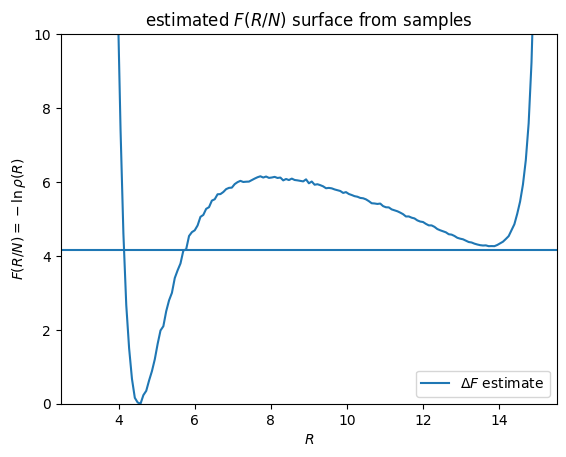

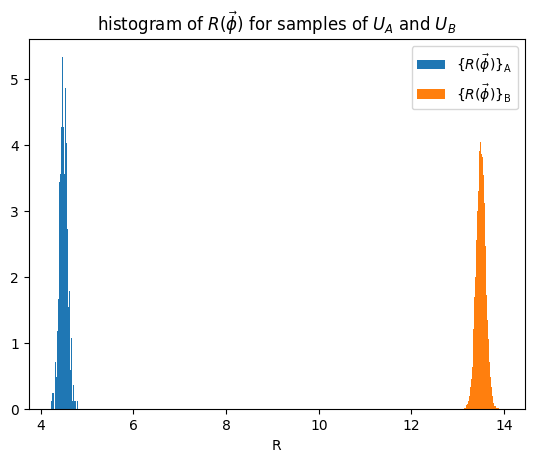

total number of samples 445000
samples for U_A 737
samples for U_B 33687
dF = F_B - F_A estimate from reweighting: [4.173354478926171]


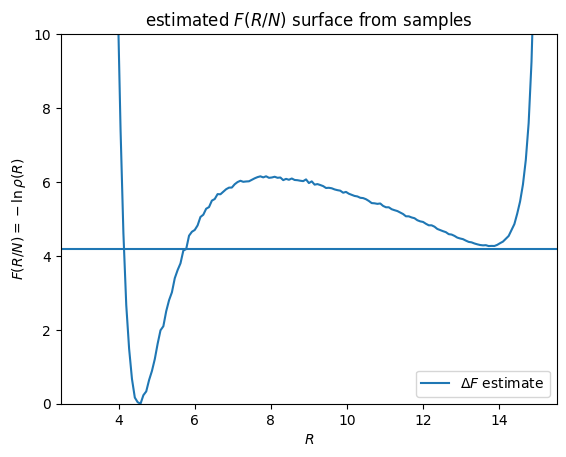

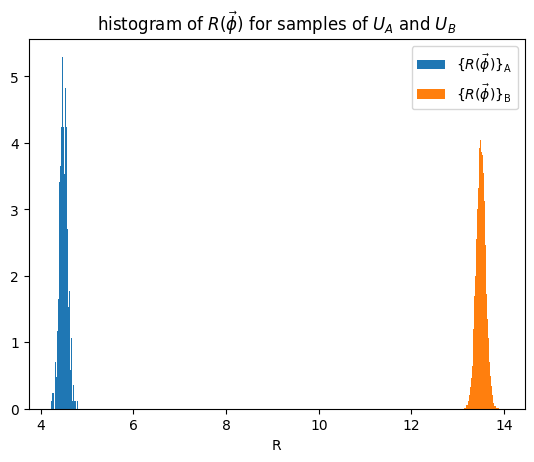

total number of samples 450000
samples for U_A 749
samples for U_B 34062
dF = F_B - F_A estimate from reweighting: [4.178361365732176]


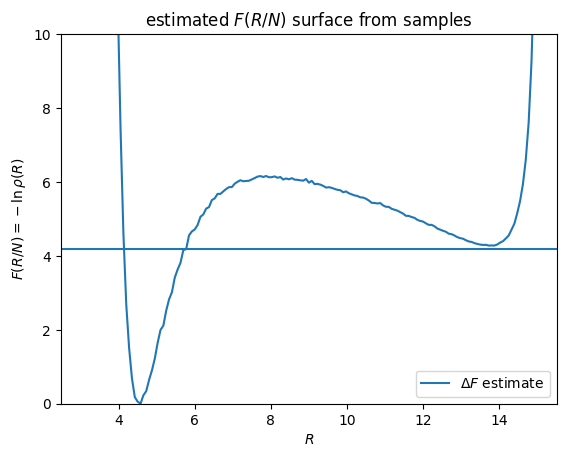

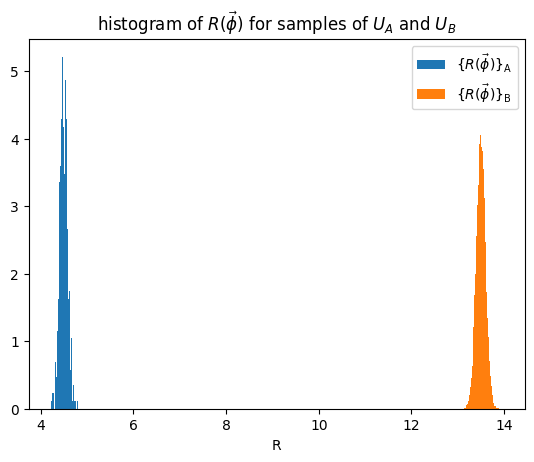

total number of samples 455000
samples for U_A 756
samples for U_B 34430
dF = F_B - F_A estimate from reweighting: [4.177953453319848]


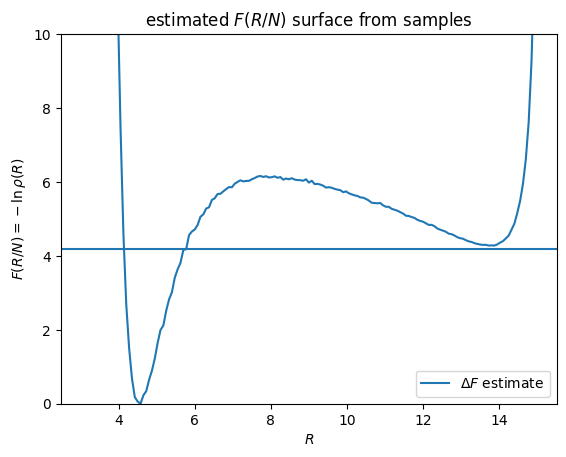

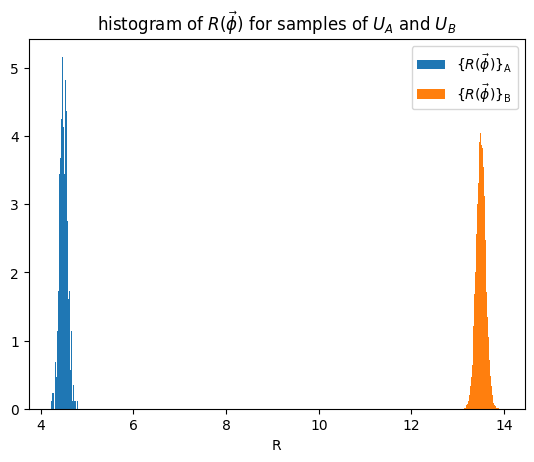

total number of samples 460000
samples for U_A 770
samples for U_B 34837
dF = F_B - F_A estimate from reweighting: [4.18088725039344]


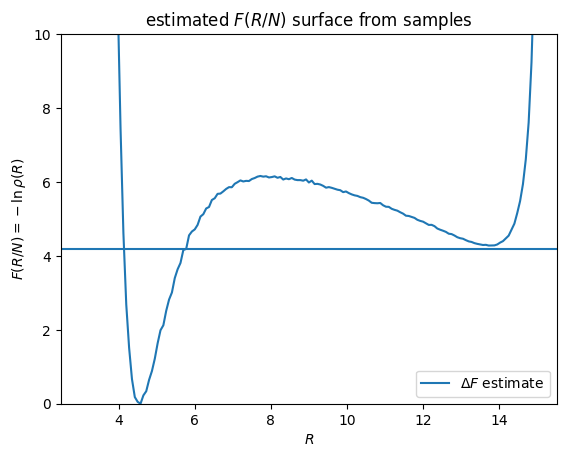

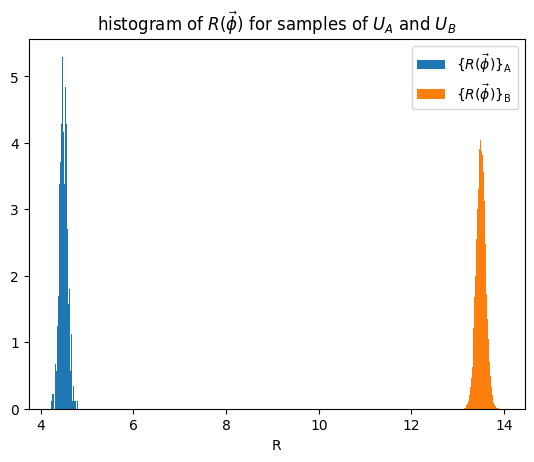

total number of samples 465000
samples for U_A 782
samples for U_B 35200
dF = F_B - F_A estimate from reweighting: [4.185547331685797]


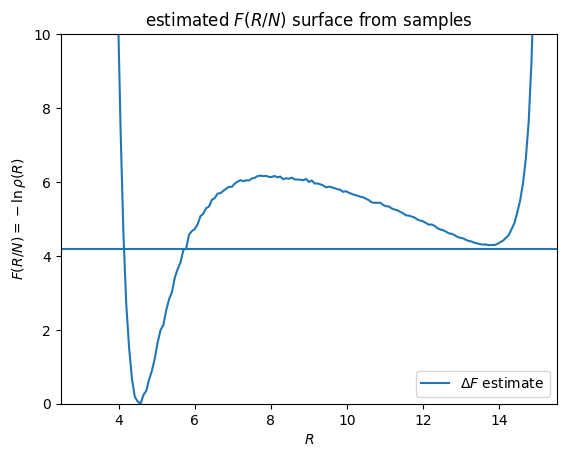

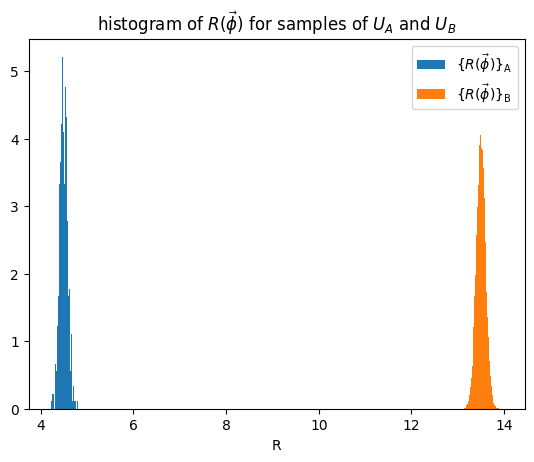

total number of samples 470000
samples for U_A 788
samples for U_B 35567
dF = F_B - F_A estimate from reweighting: [4.186550035277767]


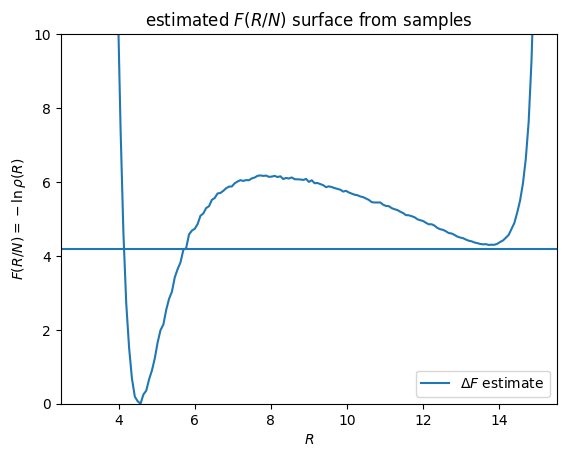

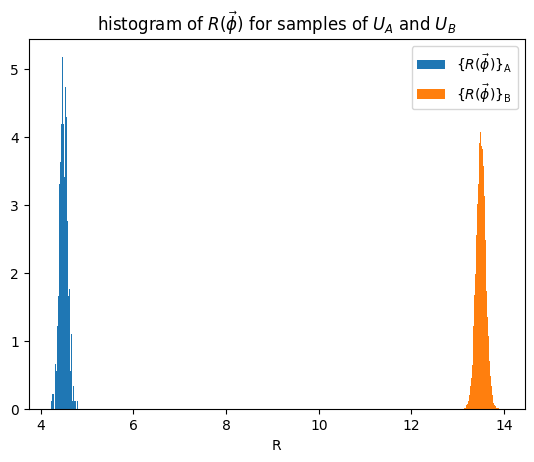

total number of samples 475000
samples for U_A 800
samples for U_B 35937
dF = F_B - F_A estimate from reweighting: [4.1909834288498615]


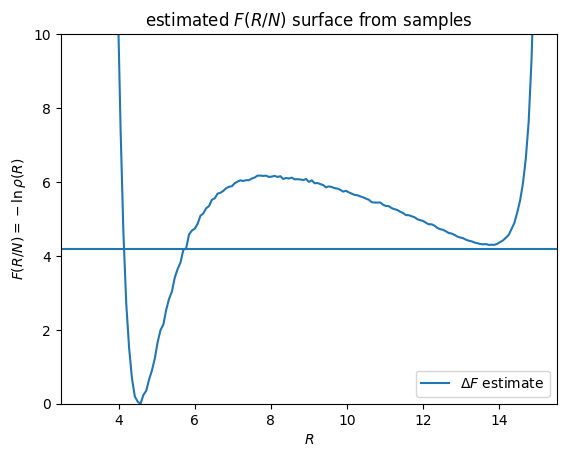

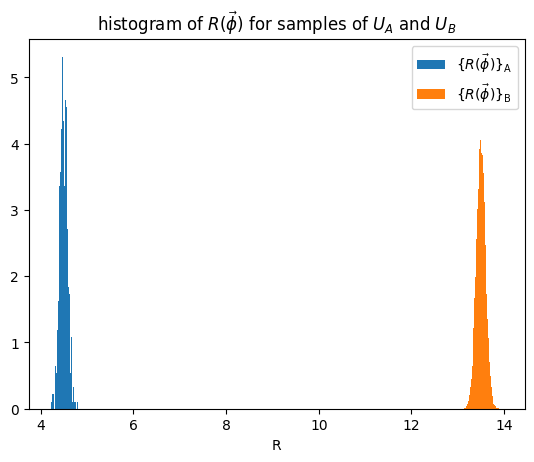

total number of samples 480000
samples for U_A 806
samples for U_B 36318
dF = F_B - F_A estimate from reweighting: [4.188363246588077]


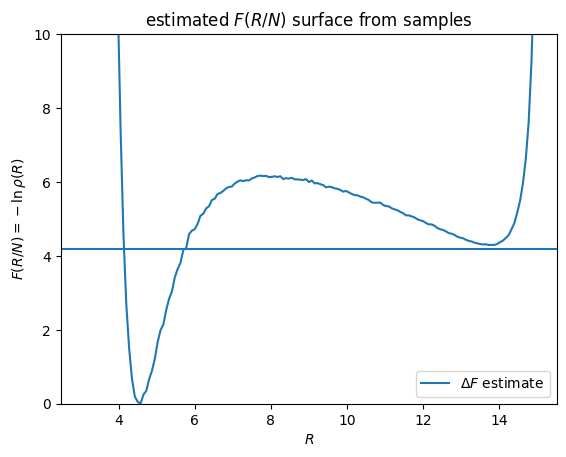

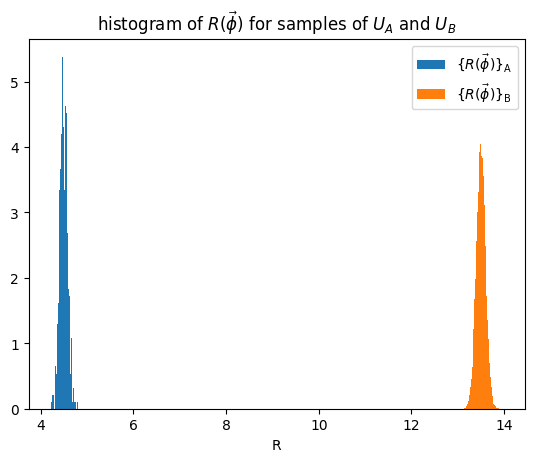

total number of samples 485000
samples for U_A 811
samples for U_B 36699
dF = F_B - F_A estimate from reweighting: [4.185479736593294]


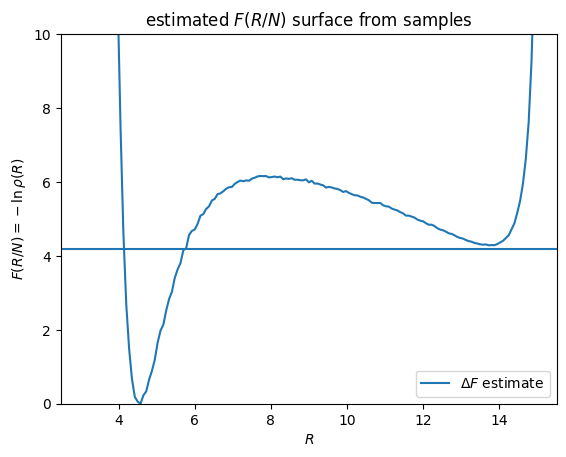

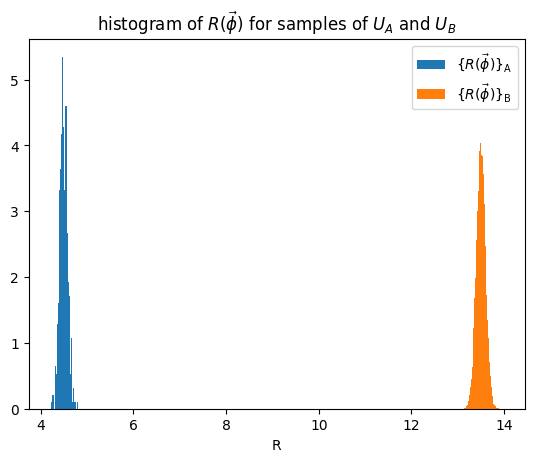

total number of samples 490000
samples for U_A 821
samples for U_B 37068
dF = F_B - F_A estimate from reweighting: [4.186631951597514]


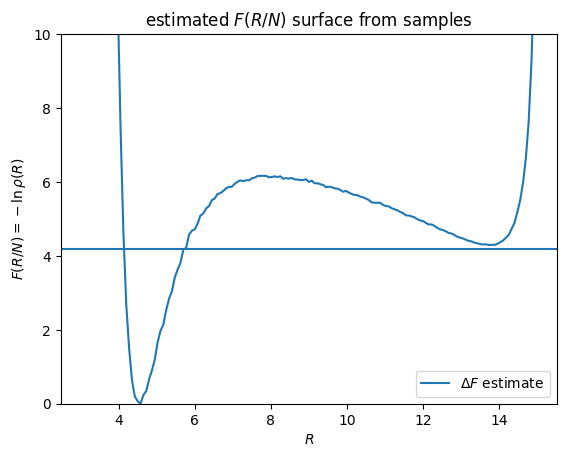

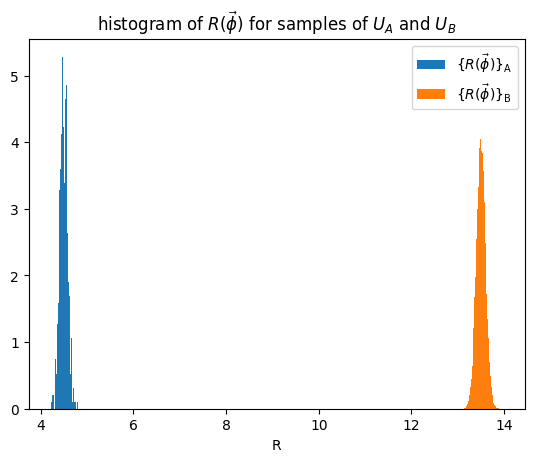

total number of samples 495000
samples for U_A 828
samples for U_B 37481
dF = F_B - F_A estimate from reweighting: [4.186820281746817]


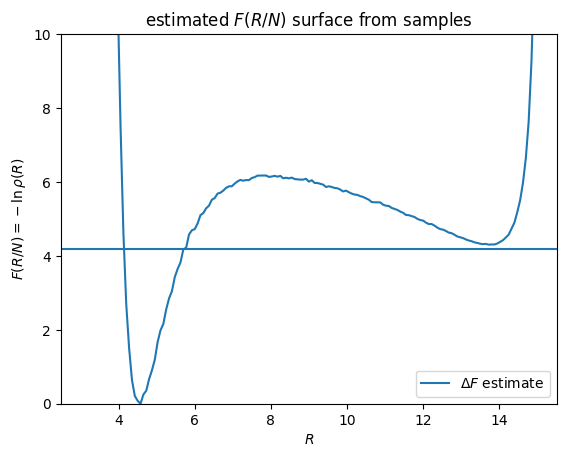

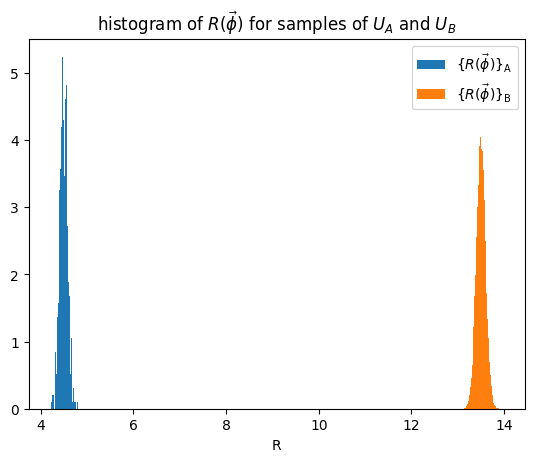

total number of samples 500000
samples for U_A 833
samples for U_B 37866
dF = F_B - F_A estimate from reweighting: [4.18249880260192]


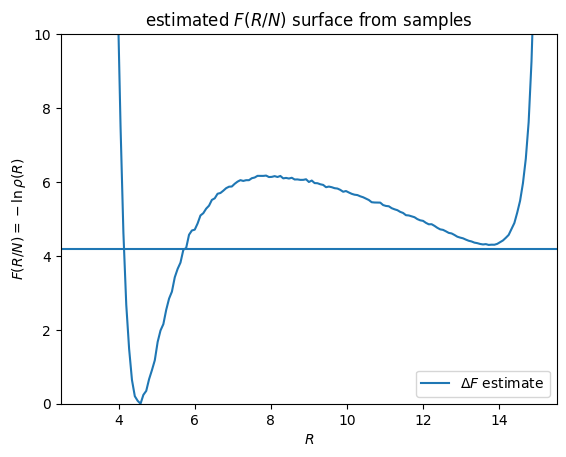

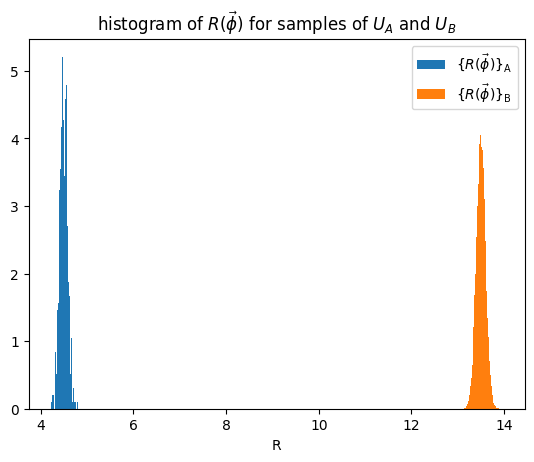

total number of samples 505000
samples for U_A 843
samples for U_B 38252
dF = F_B - F_A estimate from reweighting: [4.18512491880827]


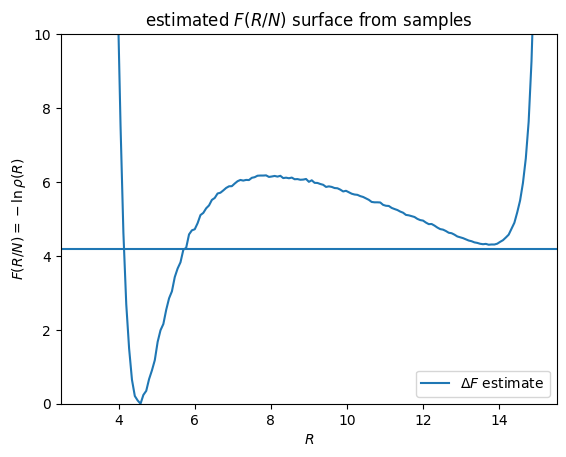

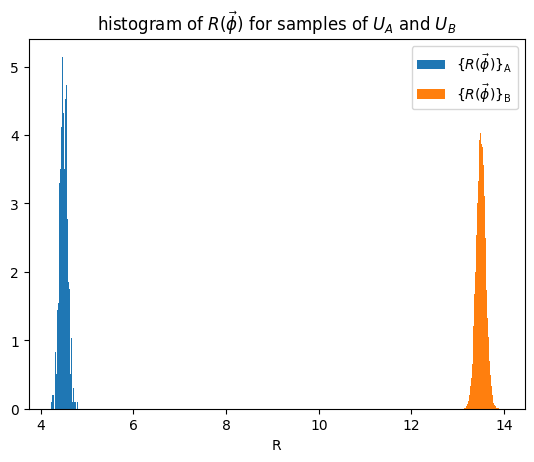

total number of samples 510000
samples for U_A 853
samples for U_B 38620
dF = F_B - F_A estimate from reweighting: [4.190288243842131]


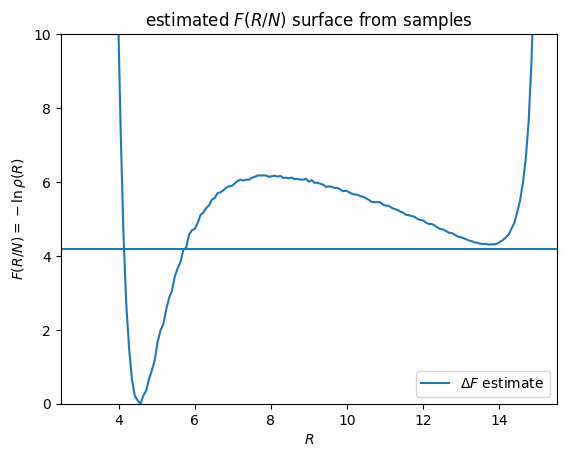

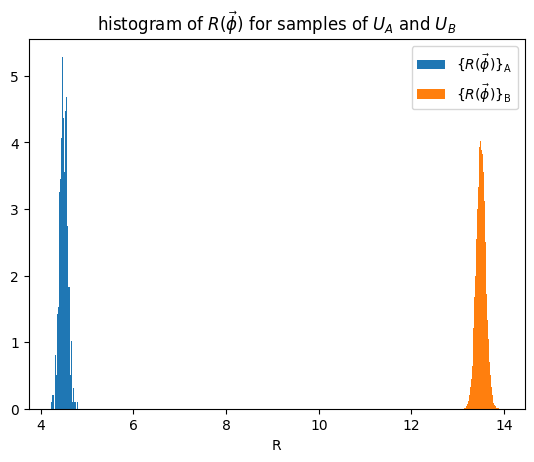

total number of samples 515000
samples for U_A 861
samples for U_B 38996
dF = F_B - F_A estimate from reweighting: [4.193719104854649]


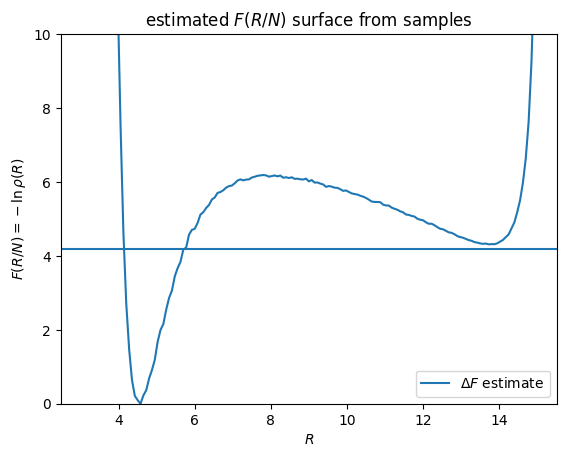

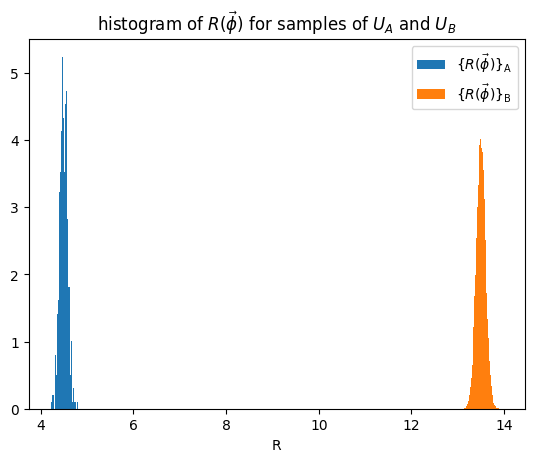

total number of samples 520000
samples for U_A 871
samples for U_B 39374
dF = F_B - F_A estimate from reweighting: [4.193689311514881]


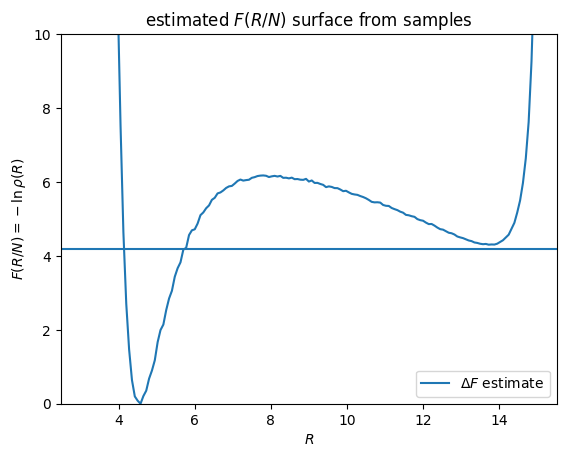

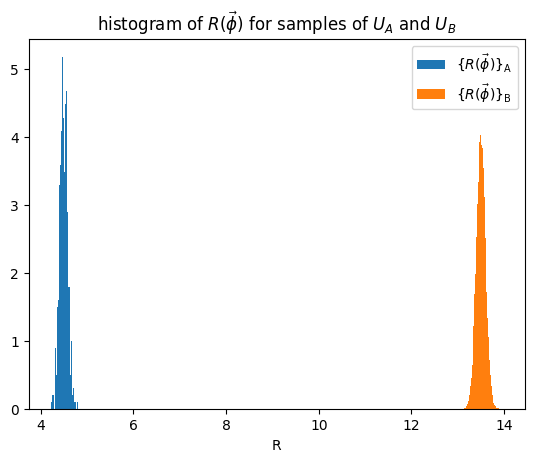

total number of samples 525000
samples for U_A 880
samples for U_B 39767
dF = F_B - F_A estimate from reweighting: [4.191685979601743]


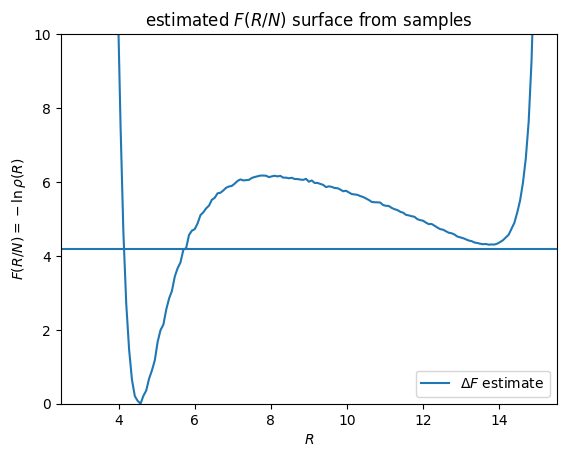

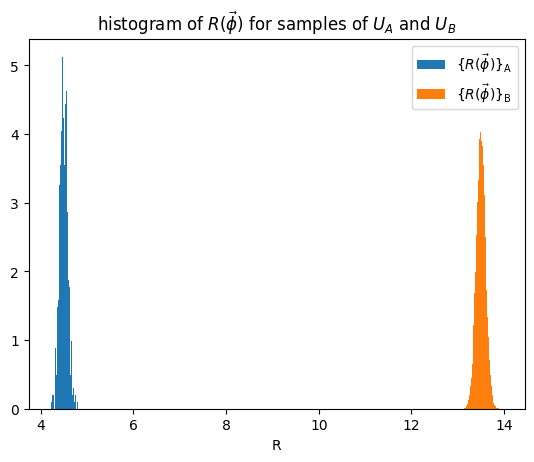

total number of samples 530000
samples for U_A 886
samples for U_B 40159
dF = F_B - F_A estimate from reweighting: [4.188248761208765]


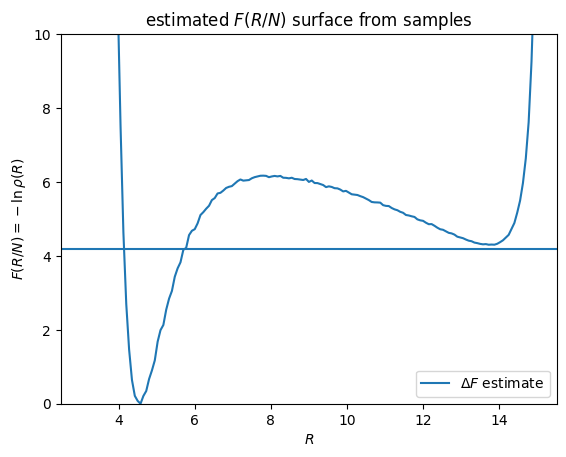

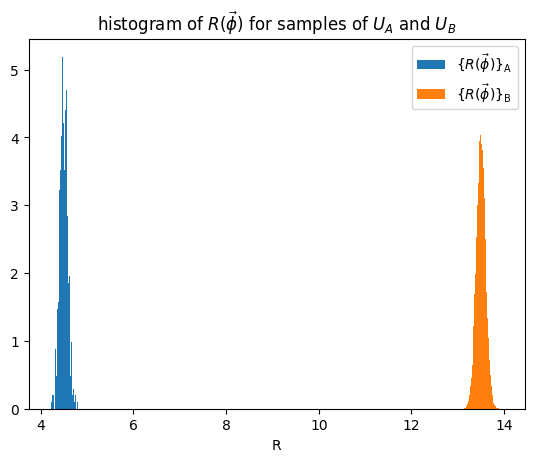

total number of samples 535000
samples for U_A 895
samples for U_B 40548
dF = F_B - F_A estimate from reweighting: [4.189516258641248]


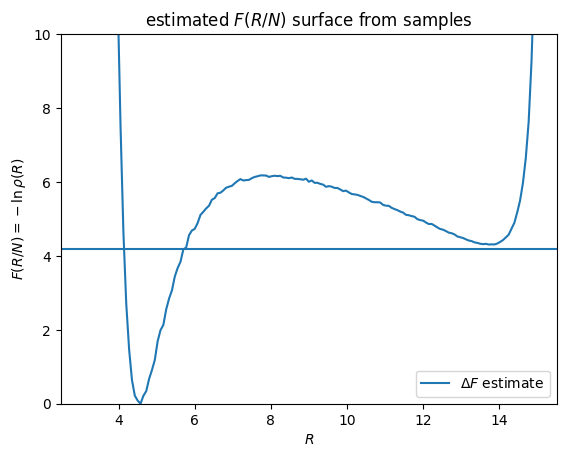

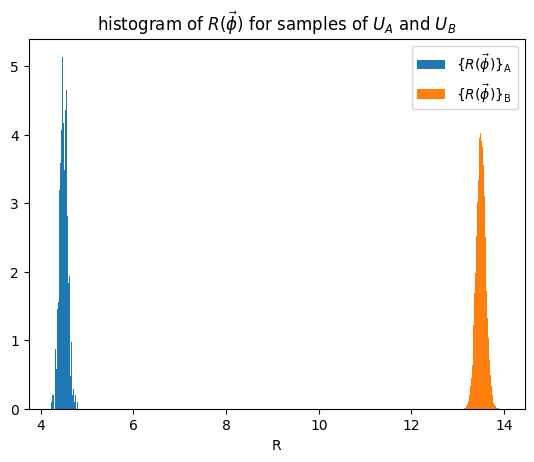

total number of samples 540000
samples for U_A 901
samples for U_B 40930
dF = F_B - F_A estimate from reweighting: [4.189971854498296]


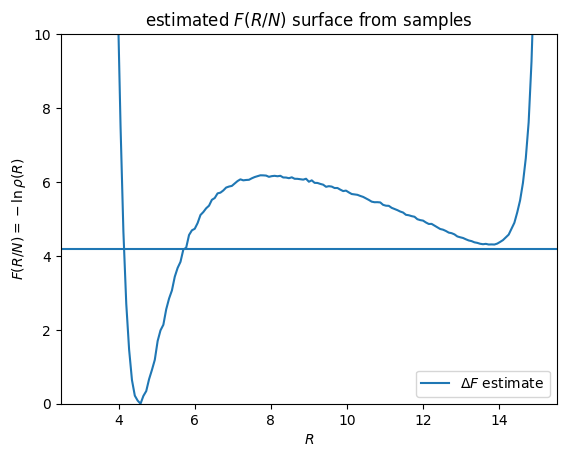

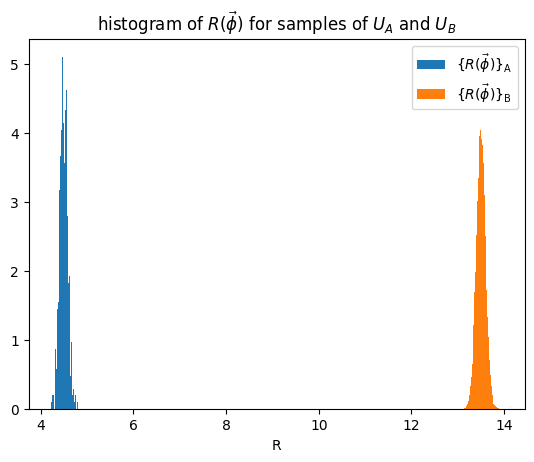

total number of samples 545000
samples for U_A 919
samples for U_B 41263
dF = F_B - F_A estimate from reweighting: [4.2005428985985915]


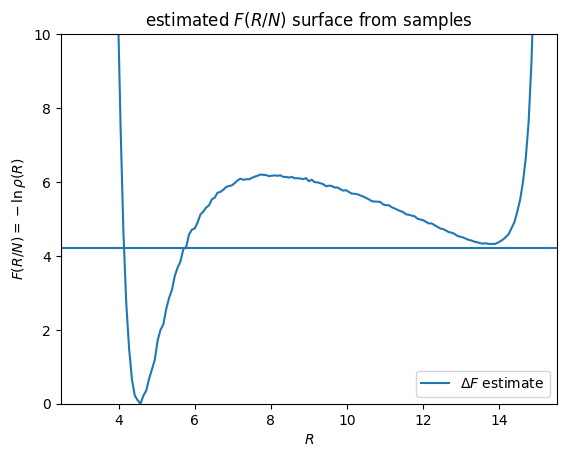

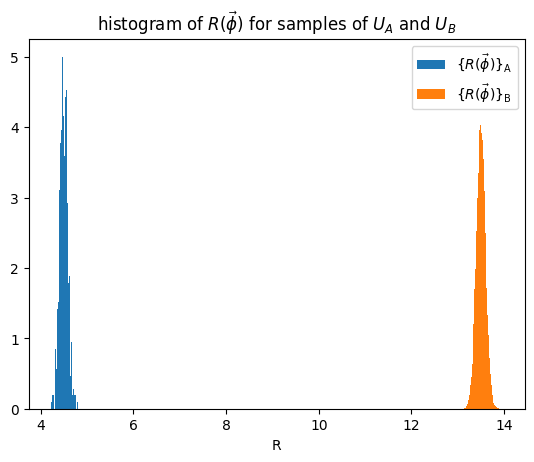

total number of samples 550000
samples for U_A 930
samples for U_B 41658
dF = F_B - F_A estimate from reweighting: [4.199141362805074]


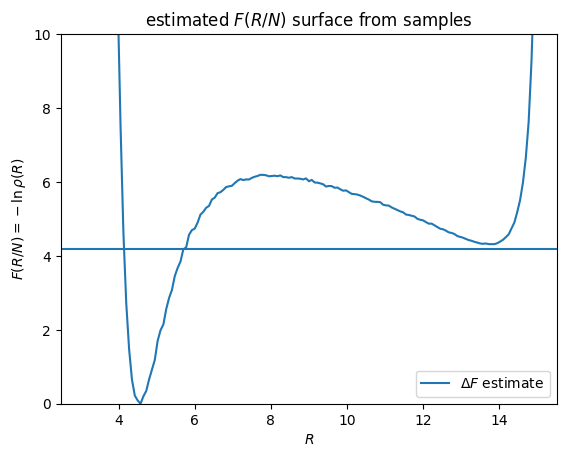

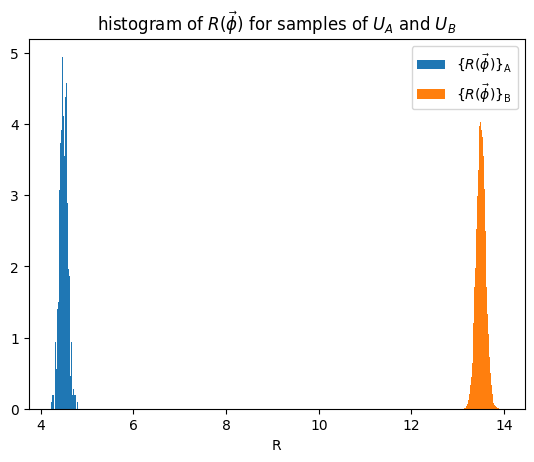

total number of samples 555000
samples for U_A 935
samples for U_B 42061
dF = F_B - F_A estimate from reweighting: [4.19540585631642]


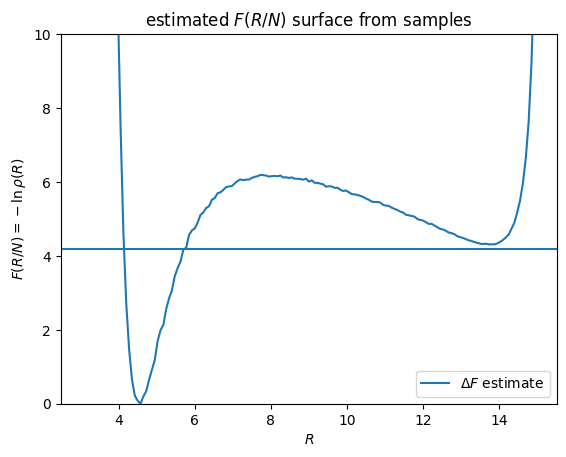

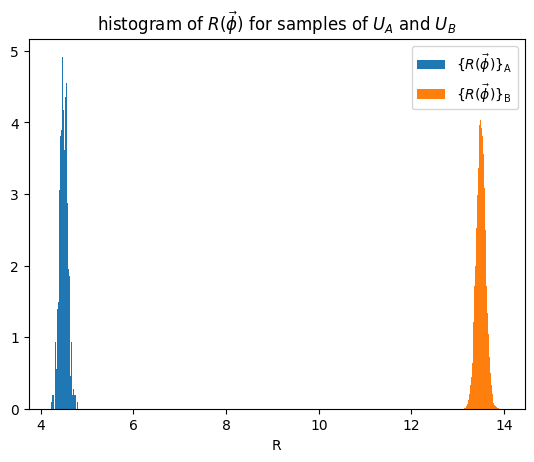

total number of samples 560000
samples for U_A 941
samples for U_B 42440
dF = F_B - F_A estimate from reweighting: [4.19416242782755]


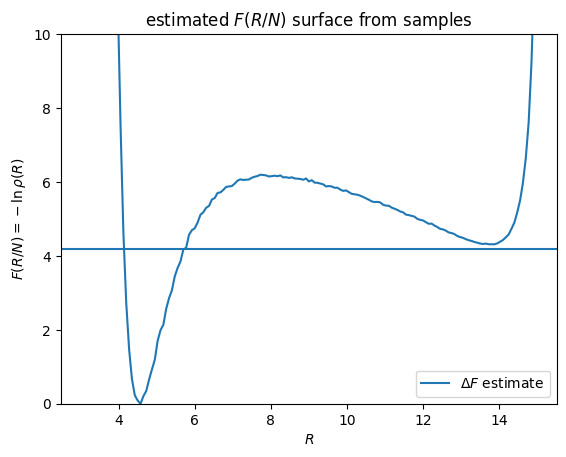

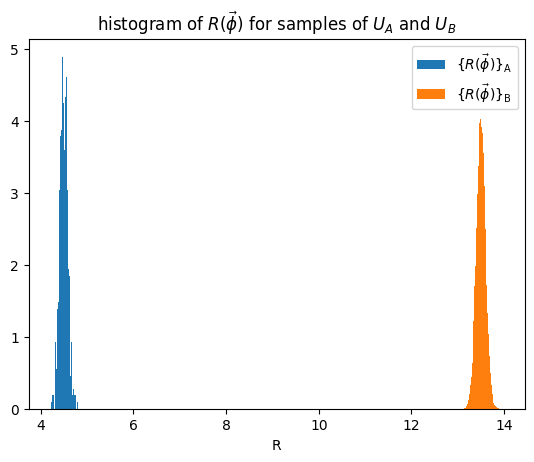

total number of samples 565000
samples for U_A 951
samples for U_B 42817
dF = F_B - F_A estimate from reweighting: [4.194927678424701]


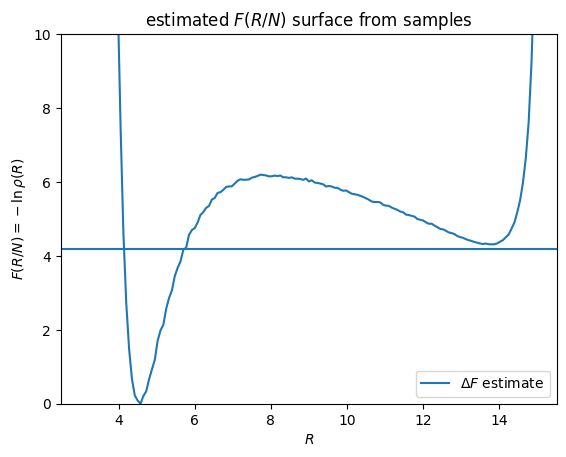

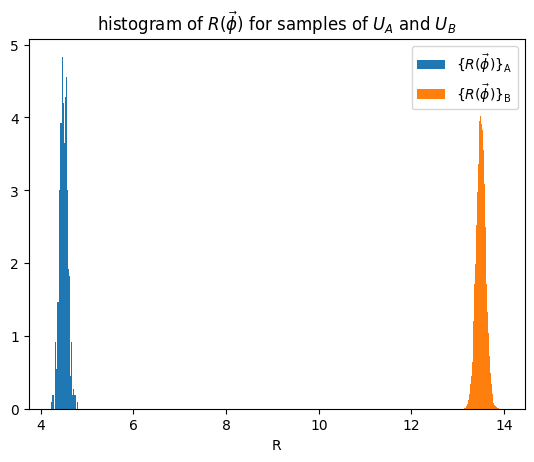

total number of samples 570000
samples for U_A 959
samples for U_B 43198
dF = F_B - F_A estimate from reweighting: [4.193819344446844]


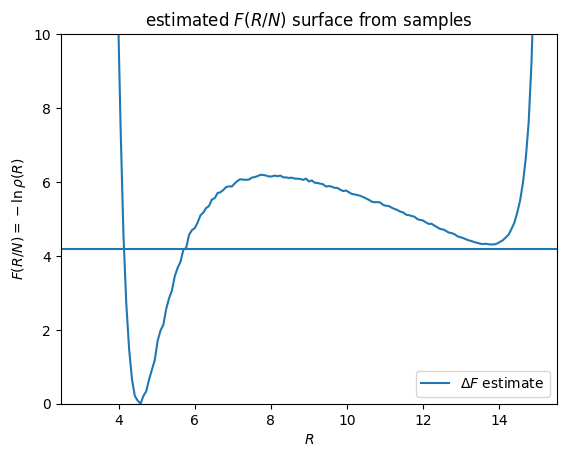

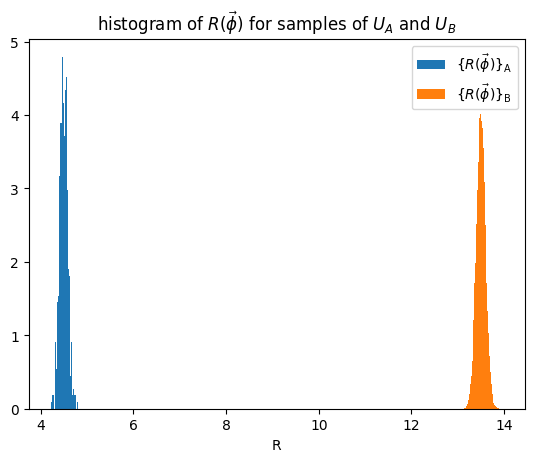

total number of samples 575000
samples for U_A 963
samples for U_B 43572
dF = F_B - F_A estimate from reweighting: [4.191086591650457]


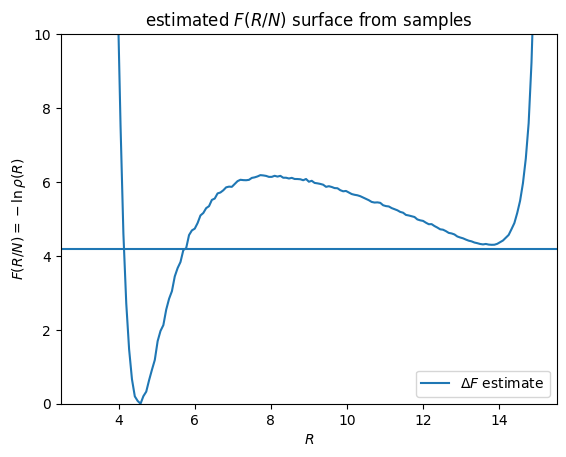

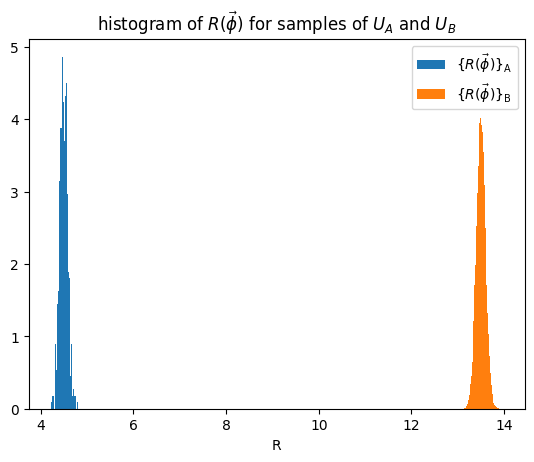

total number of samples 580000
samples for U_A 974
samples for U_B 43939
dF = F_B - F_A estimate from reweighting: [4.191223626590066]


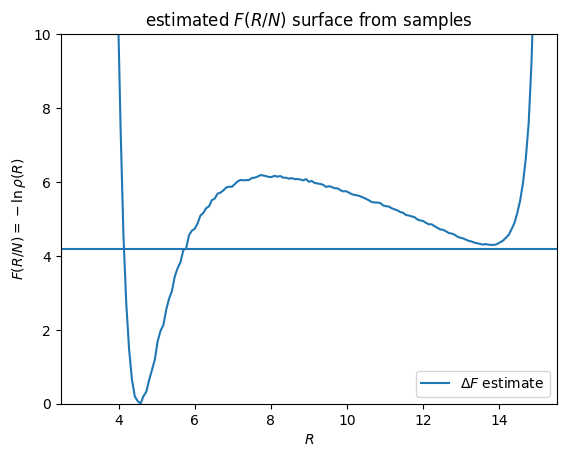

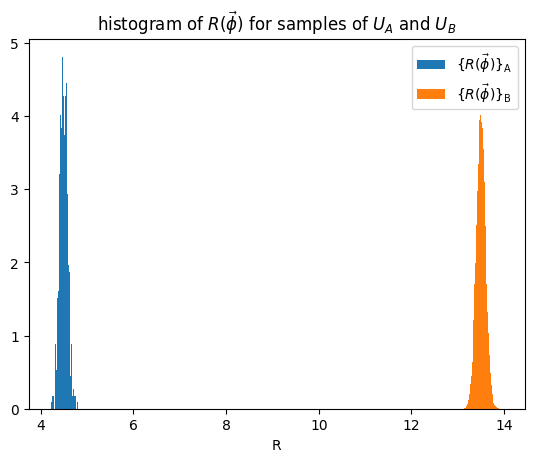

total number of samples 585000
samples for U_A 981
samples for U_B 44323
dF = F_B - F_A estimate from reweighting: [4.190607082561341]


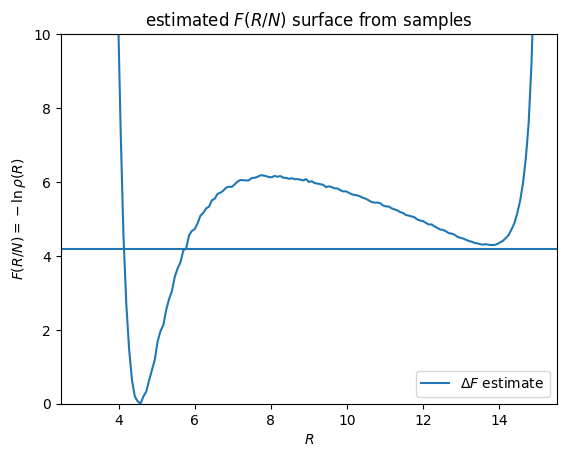

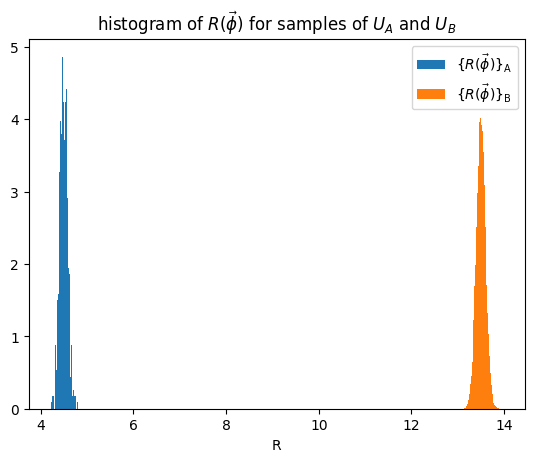

total number of samples 590000
samples for U_A 982
samples for U_B 44705
dF = F_B - F_A estimate from reweighting: [4.188078494322086]


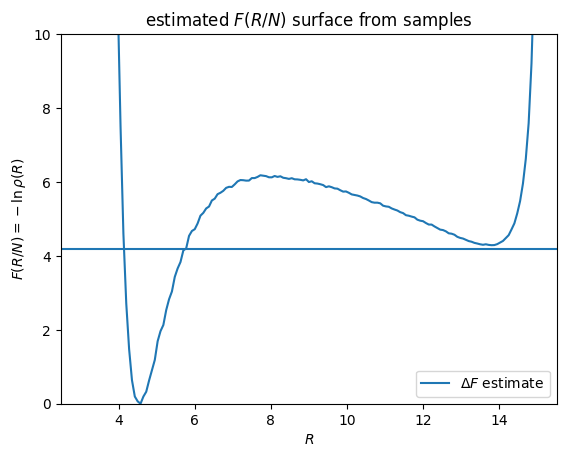

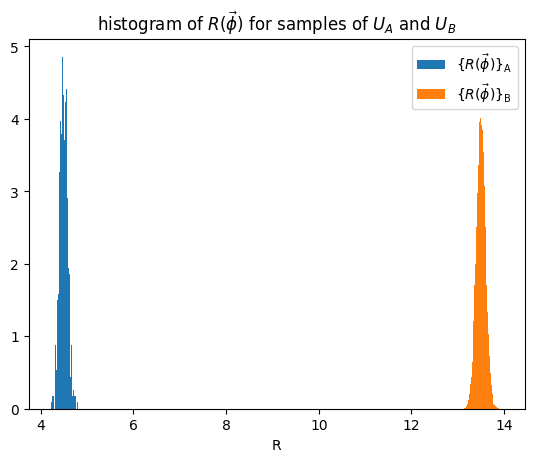

total number of samples 595000
samples for U_A 992
samples for U_B 45127
dF = F_B - F_A estimate from reweighting: [4.186685099961743]


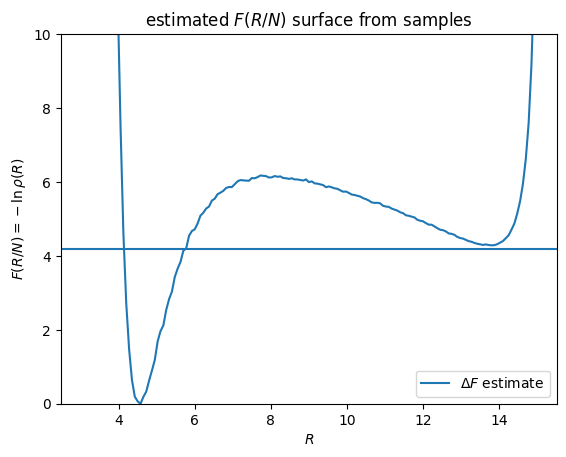

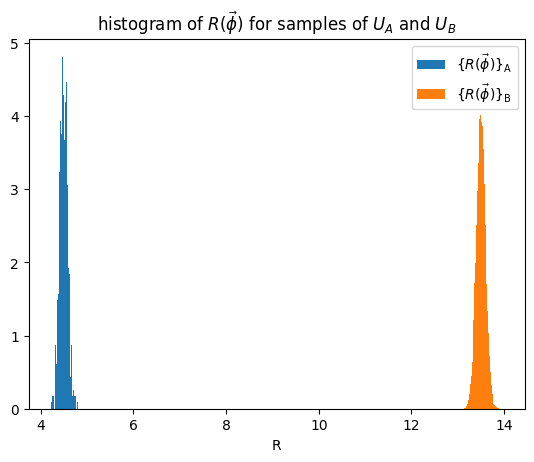

In [7]:
dt = 5e-2
steps_between_samples = 200


Rs = [] # array of all Rs


x = x0.copy()

x0s_A = []
x0s_B = [] 

Rs_A = []
Rs_B = []


bins_plot = np.linspace(0, 15, 201) # for plotting histograms



print("starting sample collection, until we have 1000 samples for U_A and U_B. continually saves to array")

# 
while min(len(x0s_A), len(x0s_B)) < 1000: # len(Rs) < 1e8: # this can be used to get more samples to make FE surface
    
    # if desired, we can plot the polymer
    # plot_polymer(x)

    # propagate steps_between_samples timesteps
    x = MALA(x, dt, steps_between_samples, verbose = False)

    # calculate R of sample
    R = np.sqrt(np.sum(np.cos(x))**2 + np.sum(np.sin(x))**2)
    Rs.append(R)
    

    if np.random.random() < np.exp(-(rho_A_weighting(R) - rho_A_weighting_offset)):
        # print("adding to ensemble A! with R:", R)
        x0s_A.append(x) 
        Rs_A.append(R)
        
    if np.random.random() < np.exp(-(rho_B_weighting(R) - rho_B_weighting_offset)):
        # print("adding to ensemble B! with R:", R)
        x0s_B.append(x) 
        Rs_B.append(R)
        
    
    if len(Rs) % 5000 == 0:
        print("total number of samples", len(Rs))
        print("samples for U_A", len(x0s_A))
        print("samples for U_B", len(x0s_B))

        ns, bins, ax = plt.hist(Rs, 
                 weights = np.exp(-(4*eps_LJ*(sig_LJ**12 / np.array(Rs)**12 - sig_LJ**6 / np.array(Rs)**6))),
                bins = bins_plot)
        plt.clf()
        
        plt.plot(bins[1:], -np.log(ns) - min(-np.log(ns)))
        plt.ylim(0, 10)
        
        
        
        dF_estimate = []
        dF_estimate.append(+ np.log(np.sum(np.exp(-rho_A_weighting(np.array(Rs)))))
                        - np.log(np.sum(np.exp(-rho_B_weighting(np.array(Rs))))))
            
        print("dF = F_B - F_A estimate from reweighting:", dF_estimate)
        
        
        plt.axhline(dF_estimate, label = r"$\Delta F$ estimate")
        
        
        plt.xlabel(r"$R$")        
        plt.ylabel(r"$F(R/N) = - \ln \rho(R)$")
        plt.title(r"estimated $F(R/N)$ surface from samples")
        
        plt.legend()
        plt.show() 
        

        
        
        plt.hist(Rs_A, density = True, bins = 50, label = r"$\{R(\vec{\phi})\}_\mathrm{A}$")
        plt.hist(Rs_B, density = True, bins = 50, label = r"$\{R(\vec{\phi})\}_\mathrm{B}$")
        
        plt.title(r"histogram of $R(\vec{\phi})$ for samples of $U_A$ and $U_B$")
        plt.xlabel("R")
        plt.legend()
        plt.show()
        
        
        
        # saves samples -- randomly selected without replacement
        # (otherwise, we might have a large disparity in file-size / number of samples)
        n_samples_min = min(len(x0s_A), len(x0s_B))
        np.save("_".join(map(str, (problemtype,) + problemparams + (lambda_i, lambda_f))) + "_x0s_A.npy", 
                np.array(x0s_A)[np.random.choice(np.arange(n_samples_min), size=n_samples_min, replace=False)])
        np.save("_".join(map(str, (problemtype,) + problemparams + (lambda_i, lambda_f))) + "_x0s_B.npy", 
                np.array(x0s_B)[np.random.choice(np.arange(n_samples_min), size=n_samples_min, replace=False)])
       
